In [1]:
import sys
print(sys.version)

3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 13:14:59) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [2]:
"""
Created on September 10 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)    

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
%load_ext autoreload
%autoreload 2

import Zernike_Module
from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

In [6]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  b

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

### 'unit test'

In [190]:
sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))

allparameters_proposal=np.array([20,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.0,0.0,0.02,0.5,
                                 0.5,2,-0.0,0.00,
                                 0.99,0.0,1,
                                 0.02,1,0,
                                 50000,50,2.5,10**-1.2,
                                 0.47,1.85,1.0])

model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1)   

res=model(allparameters_proposal)
print(res)
assert res<-5000 and res>-5050
print('ok')

-inf


AssertionError: 

### custom code 

In [1886]:
#specify number of observation which you want to analyze
obs='8603'
#specify single number which specifies which spot you want to anallyze - values are from 0 to 100, '55' is in the center of the detector 
single_number='55'
#load scientific and variance image
#sci_image =np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
#var_image =np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')

image_index=55
if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')


#obs_int=int(obs)
#obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
#z4Input_possibilites=np.array([28,24.5,21,17.5,14,10.5,7,3.5,0,0,-3.5,-7,-10.5,-14,-17.5,-21,-24.5,-28])
#z4Input=z4Input_possibilites[obs_possibilites==obs_int][0]

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent', 'x_ilum','y_ilum',
         'minorAxis','pupilAngle','effective_ilum_radiusInit','frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux'] 
"""
@param z4                     defocus parameter - if you give the observations number it will automaticly adjust but you can also pass the value manually below
@param z5-z11                 Zernike coefficents, following Noel convention

# pupil parameters
@param hscFracInit               Value determined how much of the exit pupil obscured by the central obscuration(detector) 
@param strutFracInit             Value determining how much of the exit pupil is obscured by a single strut
@param focalPlanePositionInit    2-tuple for position of the central obscuration(detector) in the focal plane
@param slitFracInit              Value determining how much of the exit pupil is obscured by slit
@param slitFrac_dy_Init          Value determining what is the vertical position of the slit in the exit pupil

#non-uniform illumination
@param radiometricEffectInit     parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param radiometricExponentInit   parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param x_ilumInit                x-position of the center of illumination of the exit pupil
@param y_ilumInit                y-position of the center of illumination of the exit pupil

# further pupil parameters
@param minorAxisInit             which fraction of major axis is the minor axis the ellipsoid describing the illumination of the exit pupil
@param pupilAngleInit            angle of the ellipsoid describing the illumination of the exit pupil
@param effective_ilum_radiusInit fraction of the maximal radius of the illumination of the exit pupil   
@param frd_sigma                 sigma of Gaussian convolving only outer edge, mimicking FRD
@param det_vert                  multiplicative factor determining vertical size of the detector obscuration
@param slitHolder_frac_dx        dx position of slit holder

# convolving parameters
@param grating_lines             number of effective lines in the grating
@param scattering_radiusInit     minimal radius to which extended the scattering [in units of microns] 
@param scattering_slopeInit      slope of scattering
@param scattering_amplitudeInit  amplitude of scattering compared to optical PSF
@param pixel_effectInit          sigma describing charge diffusion effect [in units of 15 microns]
@param fiber_rInit               radius of perfect tophat fiber, as seen on the detector [in units of 15 microns]         
@param fluxInit                  total flux in generated image compared to input image (probably 1 or close to 1)
"""

allparameters_proposal=np.array([    -0.08987438 ,     0.29065567  ,    0.57509303  ,   -1.1073552,  -0.21355587  ,   -0.32886583    ,  0.07912414    , -0.03618852,
      0.868281   ,    0.09993748   ,   0.0823797    ,  -0.00710934,  0.09049418  , -0.17724583  , 
     .2       ,       4.832551,   0.0116867  ,     0.22405513  , 
    0.99999195  ,    0.6555352, 0.9, 0.005,1.00,0.0,
 106886.664      ,   20.4317    ,      2.4772685 ,      0.01608282,   0.3870694  ,     1.8852437   ,    0.96219   ])

if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)  
    #model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,pupil_parameters=[0.65,0.1,0.,0.,0.08,0,0.99,0.0,1,0.04,1,0])   

modelP =LNP_PFS(sci_image,var_image)


model(allparameters_proposal)

-38435.787669943471

In [1512]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    #model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)  
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,pupil_parameters=np.array([ 0.65952266,  0.16735511 ,-0.02852821 , 0.09037884,  0.01630378,  0.08753993,
                                                                                    0.99295579, -0.07941925 , 0.71549089 , 0.05811413  ,0.98410936, -0.00104982])  ) 

modelP =LNP_PFS(sci_image,var_image)


model(allparameters_proposal)

-3619.9260841236292

In [1513]:
allparameters_proposal=np.array([z4Input,0.00,0.00,-0.0,0.0,0.0,0.00,0.0,
                                 0.65,0.1,0.0,0.0,0.08,0.0,
                                 0.7,2,-0.2,0.00,
                                 0.99,0.0,1,
                                 0.04,1,0,
                                 50000,50,2.5,10**-1.2,
                                 0.47,1.85,1.0]) 
allparameters_proposal

array([     0.        ,      0.        ,      0.        ,     -0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.65      ,      0.1       ,      0.        ,      0.        ,
            0.08      ,      0.        ,      0.7       ,      2.        ,
           -0.2       ,      0.        ,      0.99      ,      0.        ,
            1.        ,      0.04      ,      1.        ,      0.        ,
        50000.        ,     50.        ,      2.5       ,      0.06309573,
            0.47      ,      1.85      ,      1.        ])

In [1504]:
allparameters_proposal==add_pupil_parameters_to_all_parameters(allparameters_proposal_short,pupil_parameters)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

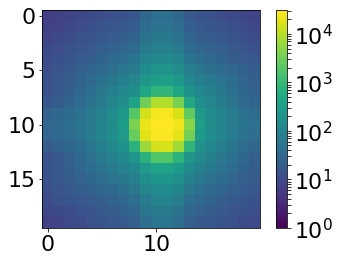

In [1514]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
r=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

plt.imshow(optPsf_cut_fiber_convolved_downsampled,norm=LogNorm(),vmax=np.max(optPsf_cut_fiber_convolved_downsampled),vmin=1)
plt.colorbar()

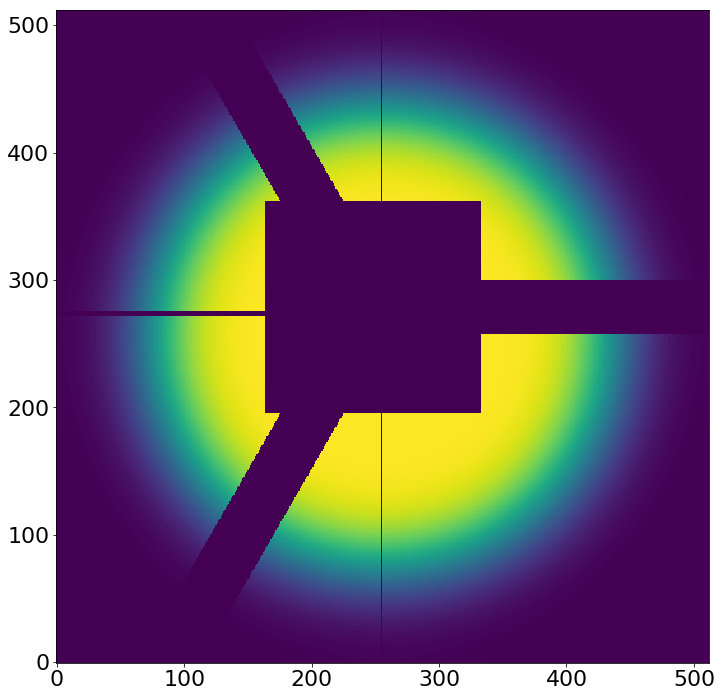

In [1515]:
plt.figure(figsize=(12,12))
plt.imshow(pupililluminated,origin='lower')

In [1386]:
allparameters_proposal

array([     -0.08987438,       0.29065567,       0.57509303,
            -1.1073552 ,      -0.21355587,      -0.32886583,
             0.07912414,      -0.03618852,       0.868281  ,
             0.09993748,       0.0823797 ,      -0.00710934,
             0.09049418,      -0.17724583,       0.2       ,
             4.832551  ,       0.0116867 ,       0.22405513,
             0.99999195,       0.6555352 ,       0.9       ,
             0.005     ,       1.        ,       0.        ,
        106886.664     ,      20.4317    ,       2.4772685 ,
             0.01608282,       0.3870694 ,       1.8852437 ,       0.96219   ])

In [1467]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,pupil_parameters=[0.868,0.099,0.09,-0.177,0.05,0.5,1,0.99,0.99,0.05,1,0])
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,pupil_parameters=[0.868,0.099,0.09,-0.177,0.05,0.5,1,0.99,0.99,0.06,1,0])   

model(remove_pupil_parameters_from_all_parameters(allparameters_proposal))

OrderedDict([('z4', -0.089874380000000004), ('z5', 0.29065566999999998), ('z6', 0.57509303000000001), ('z7', -1.1073552), ('z8', -0.21355587000000001), ('z9', -0.32886583000000003), ('z10', 0.079124139999999996), ('z11', -0.036188520000000002), ('dx', 0.0), ('dy', 0.0), ('hscFrac', 0.86799999999999999), ('strutFrac', 0.099000000000000005), ('dxFocal', 0.089999999999999997), ('dyFocal', -0.17699999999999999), ('slitFrac', 0.050000000000000003), ('slitFrac_dy', 0.5), ('fiber_r', 1.8852437), ('radiometricEffect', 0.20000000000000001), ('trace_value', 0), ('serial_trace_value', 0), ('pixel_effect', 0.38706940000000001), ('background', 0), ('flux', 0.96218999999999999), ('x_ilum', 0.0116867), ('y_ilum', 0.22405512999999999), ('radiometricExponent', 4.8325509999999996), ('minorAxis', 1.0), ('effective_ilum_radius', 0.98999999999999999), ('pupilAngle', 0.98999999999999999), ('grating_lines', 106886.664), ('scattering_radius', 20.431699999999999), ('scattering_slope', 2.4772685000000001), ('sc

-20968.055123075646

In [1446]:
remove_pupil_parameters_from_all_parameters(allparameters_proposal)



array([     -0.08987438,       0.29065567,       0.57509303,
            -1.1073552 ,      -0.21355587,      -0.32886583,
             0.07912414,      -0.03618852,       0.2       ,
             4.832551  ,       1.        ,       0.        ,
        106886.664     ,      20.4317    ,       2.4772685 ,
             0.01608282,       0.3870694 ,       1.8852437 ,       0.96219   ])

In [1452]:
test_par=remove_pupil_parameters_from_all_parameters(allparameters_proposal)
test_par

array([     -0.08987438,       0.29065567,       0.57509303,
            -1.1073552 ,      -0.21355587,      -0.32886583,
             0.07912414,      -0.03618852,       0.2       ,
             4.832551  ,       1.        ,       0.        ,
        106886.664     ,      20.4317    ,       2.4772685 ,
             0.01608282,       0.3870694 ,       1.8852437 ,       0.96219   ])

In [1465]:
def add_pupil_parameters_to_all_parameters(parameters,pupil_parameters):
    lenpar=len(parameters)
    return np.concatenate((parameters[:lenpar-11],pupil_parameters[:6],parameters[lenpar-11:lenpar-7],pupil_parameters[6:],parameters[lenpar-7:]),axis=0)

In [1464]:
pupil_parameters=[0.868,0.099,0.09,-0.177,0.05,0.5,1,0.99,0.99,0.05,1,0]
add_pupil_parameters_to_all_parameters(test_par,pupil_parameters)

array([     -0.08987438,       0.29065567,       0.57509303,
            -1.1073552 ,      -0.21355587,      -0.32886583,
             0.07912414,      -0.03618852,       0.868     ,
             0.099     ,       0.09      ,      -0.177     ,
             0.05      ,       0.5       ,       0.2       ,
             4.832551  ,       1.        ,       0.99      ,
             0.99      ,       0.05      ,       1.        ,
             0.        ,       1.        ,       0.        ,
        106886.664     ,      20.4317    ,       2.4772685 ,
             0.01608282,       0.3870694 ,       1.8852437 ,       0.96219   ])

In [1460]:
test_par[:len(test_par)-11]

array([-0.08987438,  0.29065567,  0.57509303, -1.1073552 , -0.21355587,
       -0.32886583,  0.07912414, -0.03618852])

In [1425]:
from functools import lru_cache
@lru_cache(maxsize=3200)
def test(test_par):
    return np.sum(test_par)

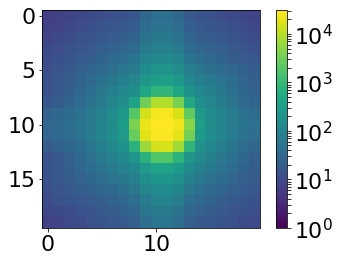

In [1522]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
r=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

plt.imshow(optPsf_cut_fiber_convolved_downsampled,norm=LogNorm(),vmax=np.max(optPsf_cut_fiber_convolved_downsampled),vmin=1)
plt.colorbar()

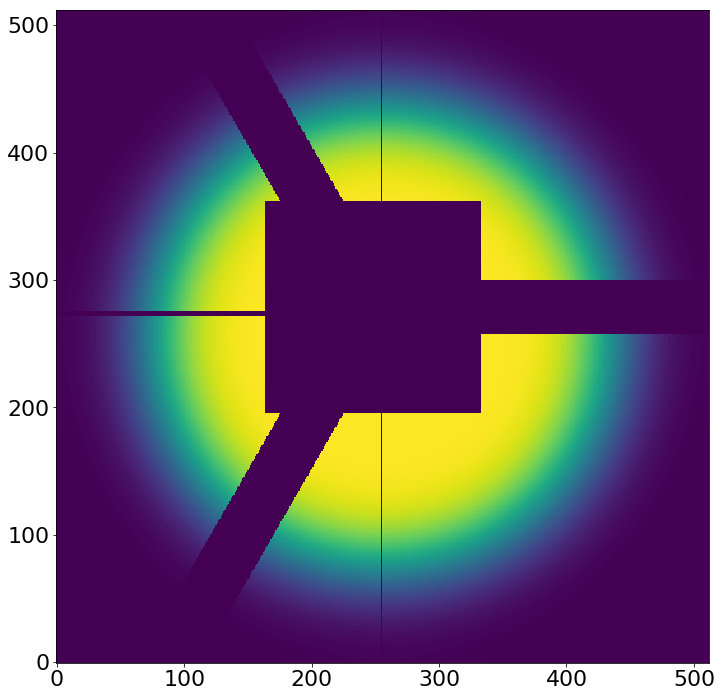

In [1523]:
plt.figure(figsize=(12,12))
plt.imshow(pupililluminated,origin='lower')

In [777]:
obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
z4Input_possibilites=np.array([28,24.5,21,17.5,14,10.5,7,3.5,0,0,-3.5,-7,-10.5,-14,-17.5,-21,-24.5,-28])
defocus_possibilites=np.array([-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0,0.5,1,1.5,2,2.5,3,3.5,4])

allparameters_proposal=np.array([-7,0.00,0.00,-0.0,0.0,0.0,0.00,0.0,0,0.00,0.00,-0.0,0.0,0.0,0.00,0.0,
                                 0.65,0.1,0.0,0.0,0.08,0.0,
                                 0.7,2,
                                 -0.2,0.00,
                                 0.99,0.0,1,
                                 50000,50,2.5,10**-1.2,
                                 0.47,1.85,1.0]) 

nT=2
parInit1=create_parInit(allparameters_proposal,multi=1)
parInit2=create_parInit(allparameters_proposal,multi=1)
parInitnT=np.array([parInit1,parInit2])

In [801]:
obs_int_array=[8567,8603,8606]
sci_image_array=[]
var_image_array=[]
for obs in obs_int_array:
    if obs=='8600':
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
    else:
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')
        
    sci_image_array.append(sci_image)
    var_image_array.append(var_image)

for i in range(len(obs_int_array)):
    globals()['model'+str(i)] = LN_PFS_single(sci_image_array[i],var_image_array[i],dithering=1,save=1)

In [802]:
sorter = np.argsort(obs_possibilites)
defocus_array=defocus_possibilites[sorter[np.searchsorted(obs_possibilites, obs_int_array, sorter=sorter)]]

In [799]:
def multi_model(parameters):
        
    res=[]
    for i in range(len(obs_int_array)):
        parameters_single=create_x(defocus_array[i],parameters)
        print(parameters_single)
        res.append(globals()['model'+str(i)](parameters_single))
    print(res)
    return np.sum(res)
    

In [803]:
multi_model(allparameters_proposal2)

[     7.2            -0.              0.              0.              0.
     -0.              0.              0.              0.65            0.1
      0.              0.              0.08            0.              0.7
      2.             -0.2             0.              0.99            0.
      1.          50000.             50.              2.5             0.06309573
      0.47            1.85            1.        ]
[     0.              0.              0.              0.              0.
      0.              0.              0.              0.65            0.1
      0.              0.              0.08            0.              0.7
      2.             -0.2             0.              0.99            0.
      1.          50000.             50.              2.5             0.06309573
      0.47            1.85            1.        ]
[    -2.4             0.              0.              0.              0.
      0.              0.              0.              0.65            0.1
   

-2603911.0521860463

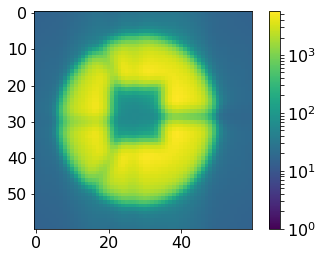

In [1195]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
r=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

plt.imshow(optPsf_cut_fiber_convolved_downsampled,norm=LogNorm(),vmax=np.max(optPsf_cut_fiber_convolved_downsampled),vmin=1)
plt.colorbar()

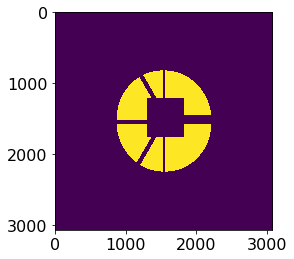

In [1197]:
plt.imshow(ilum)

In [59]:
airy = galsim.Airy(diam=0.138, lam=500)
stepk = airy.stepk

In [60]:
stepk

0.10372264323065072

In [63]:
good_pupil_scale = (stepk * 500 * 1.e-9 * (galsim.radians / galsim.arcsec)
                    / (2 * np.pi * 1))
good_pupil_scale

0.001702506759187914

In [38]:
import inspect

In [40]:
source_DF = inspect.getsource(galsim.Aperture)

In [41]:
print(source_DF)

class Aperture(object):
    """ Class representing a telescope aperture embedded in a larger pupil plane array -- for use
    with the PhaseScreenPSF class to create PSFs via Fourier or geometric optics.

    The pupil plane array is completely specified by its size, sampling interval, and pattern of
    illuminated pixels.  Pupil plane arrays can be specified either geometrically or using an image
    to indicate the illuminated pixels.  In both cases, various options exist to control the pupil
    plane size and sampling interval.

    Geometric pupil specification
    -----------------------------

    The first way to specify the details of the telescope aperture is through a series of keywords
    indicating the diameter, size of the central obscuration, and the nature of the struts
    holding up the secondary mirror (or prime focus cage, etc.).  The struts are assumed to be
    rectangular obscurations extending from the outer edge of the pupil to the outer edge of the
    obscu

# Analysis (Single)

## Scripts

### Early September

In [1520]:
for single_spot in [35,45,55,75,85,95]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(single_spot)+'Sep_P.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8552, 8564, 8603, 8615, 8627]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close() 
    
for single_spot in [35,45,55,75,85,95]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(2)+'S'+str(single_spot)+'Sep_P.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555, 8567, 8606, 8618]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()     
    
for single_spot in [35,45,55,75,85,95]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(3)+'S'+str(single_spot)+'Sep_P.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8558, 8570, 8609, 8621]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()     
  
for single_spot in [35,45,55,75,85,95]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(4)+'S'+str(single_spot)+'Sep_P.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8561, 8573, 8612, 8624]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()    
    
for single_spot in [5,25,35,45,55,75,85,95,56,57,58,59,54,52,51,50]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(single_spot)+'Sep_P_Multi.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    file.write("python /home/ncaplar/Code/ZernikeMulti_Sep.py "+'8552,8561,8573,8603,8606,8618,8627'+" "+str(single_spot)+" 160 1\n")
    file.close()    

In [1521]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for obs in [1]:
    for single_spot in [5,25,35,45,55,75,85,95,56,57,58,59,54,52,51,50]:
        file.write('sbatch /home/ncaplar/Scripts/T'+str(1)+'S'+str(single_spot)+'Sep_P_Multi.sh \n')

        
file.close()

In [1882]:
for single_spot in [5,25,35,45,55,75,85,95,56,57,58,59,54,52,51,50]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/P'+str(1)+'S'+str(single_spot)+'Sep_P.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8552, 8627, 8624, 8555]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 150 0\n")
    file.close()    

In [1883]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for obs in [1]:
    for single_spot in [5,25,35,45,55,75,85,95,56,57,58,59,54,52,51,50]:
        file.write('sbatch /home/ncaplar/Scripts/P'+str(1)+'S'+str(single_spot)+'Sep_P.sh \n')

        
file.close()

### Sep 21

#### Test for speed

In [2813]:
for single_spot in [999]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(999)+'S'+str(single_spot)+'Sep_P_Test.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+'8558'+" "+str(single_spot)+" 50 1\n")
    file.close()    

#### Real

In [3105]:
# single node

for single_spot in [51]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(single_spot)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8603,8552,8627,8558]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()    
    
    
for single_spot in [25,35,45,55,75,85,95,56,57,58,59,54,52,51,50]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(2)+'S'+str(single_spot)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8612,8567]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()        

In [3106]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for obs in [1]:
    for single_spot in [51]:
        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep.sh \n')

for obs in [2]:
    for single_spot in [25,35,45,55,75,85,95,56,57,58,59,54,52,51,50]:
        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep.sh \n')

        
file.close()

In [3113]:
#MPI
for single_spot in [7,27,37,77,87,97]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TMPI'+str(1)+'S'+str(single_spot)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8612,8567,8552,8627,8621]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in  [7,27,37,77,87,97]:
    file.write('sbatch /home/ncaplar/Scripts/TMPI'+str(1)+'S'+str(single_spot)+'Sep.sh \n')

        
file.close()

In [3112]:
for single_spot in [40,41,42,43,46,47,48,49]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/P'+str(1)+'S'+str(single_spot)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8603,8552,8627,8558]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()    
    
    
for single_spot in [40,41,42,43,46,47,48,49]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/P'+str(2)+'S'+str(single_spot)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8612,8567]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()  
    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for obs in [1,2]:
    for single_spot in [40,41,42,43,46,47,48,49]:
        file.write('sbatch /home/ncaplar/Scripts/P'+str(obs)+'S'+str(single_spot)+'Sep.sh \n')

        
file.close()    

### Sep 24

In [248]:
#MPI
for single_spot in [6,26,36,76,86,96,7,27,37,77,87,97]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TMPI'+str(1)+'S'+str(single_spot)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8612,8567,8552,8627,8621]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in  [6,26,36,76,86,96,7,27,37,77,87,97]:
    file.write('sbatch /home/ncaplar/Scripts/TMPI'+str(1)+'S'+str(single_spot)+'Sep.sh \n')

        
file.close()

In [250]:
#MPI
for obs in [8621]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TMPI'+str(18621)+'S'+str(1)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in [0,1,4,5,8,9,24,25,34,35,40,41,42,43]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()    
 
for obs in [8621]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TMPI'+str(28621)+'S'+str(1)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in [44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()    
    
    
for obs in [8621]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TMPI'+str(38621)+'S'+str(1)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in [64,65,80,81,84,85,88,89,90,91,94,95,98,99]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()        



file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

file.write('sbatch /home/ncaplar/Scripts/TMPI'+str(18621)+'S'+str(1)+'Sep.sh \n')
file.write('sbatch /home/ncaplar/Scripts/TMPI'+str(28621)+'S'+str(1)+'Sep.sh \n')
file.write('sbatch /home/ncaplar/Scripts/TMPI'+str(38621)+'S'+str(1)+'Sep.sh \n')

        
file.close()

### Sep 26 (made on Sep25)

In [11]:
#MPI
for single_spot in [4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,6,26,36,46,56,76,86,96,7,27,37,47,57,77,87,97]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TMPI'+str(1)+'S'+str(single_spot)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8612,8567,8552,8627,8621,8558]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in [4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,6,26,36,46,56,76,86,96,7,27,37,47,57,77,87,97]:
    file.write('sbatch /home/ncaplar/Scripts/TMPI'+str(1)+'S'+str(single_spot)+'Sep.sh \n')

        
file.close()

In [13]:
#MPI
for single_spot in [40,41,42,43,48,49,50,51,52,53,58,59,70,71,72,73,78,89]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/PMPI'+str(1)+'S'+str(single_spot)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8612,8567,8552,8627,8621,8558]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in [40,41,42,43,48,49,50,51,52,53,58,59,70,71,72,73,78,89]:
    file.write('sbatch /home/ncaplar/Scripts/PMPI'+str(1)+'S'+str(single_spot)+'Sep.sh \n')

        
file.close()

In [649]:
#MPI
for single_spot in [4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,6,26,36,46,56,76,86,96]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TMPI'+str(1)+'S'+str(single_spot)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8612,8567,8552,8627,8621,8558]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in [4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,6,26,36,46,56,76,86,96]:
    file.write('sbatch /home/ncaplar/Scripts/TMPI'+str(1)+'S'+str(single_spot)+'Sep.sh \n')

        
file.close()

In [650]:
#MPI
for single_spot in [7,27,37,47,57,77,87,97]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/PMPI'+str(1)+'S'+str(single_spot)+'Sep.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=6 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8612,8567,8552,8627,8621,8558]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+str(obs)+" "+str(single_spot)+" 80 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in [7,27,37,47,57,77,87,97]:
    file.write('sbatch /home/ncaplar/Scripts/PMPI'+str(1)+'S'+str(single_spot)+'Sep.sh \n')

        
file.close()

## Core Analysis (pandas dataframe creation)

In [651]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent', 'x_ilum','y_ilum',
         'minorAxis','pupilAngle','effective_radius_illumination','frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']     

columns_analysis=columns+['chi2','chi2max']



In [652]:
results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)

# arrange all results in one pandas 
date='Sep19'
#date='Sep26'
RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

single_defocus_list=[8552,8555,8558,8561,8564,8567,8570,8573,8600,8603,8606,8609,8612,8615,8618,8621,8624,8627]

single_number=75
image_index=single_number
method='P'
eps=5

res_likelihood=[]

for single_defocus in tqdm(range(0,len(single_defocus_list))):
    try:
        obs=single_defocus_list[single_defocus]
        try:

            chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
            likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
            print('obs (Emcee3): '+str(obs)+' is found!')
        except:    
            chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
            likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
            print('obs (Emcee2): '+str(obs)+' is found!')
        
        if obs==8600:
            sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
            var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
        else:       
            sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
            var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')

        likechain0=likechain

        chain0=chain
        minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
        chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2



        minchain_err=[]
        for i in range(len(columns)):
            #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
            minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

        minchain_err=np.array(minchain_err)
        results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
        err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err,np.array([1,1])),axis=0)
        


    except:
        ValueError

100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 96.01it/s]

obs (Emcee3): 8552 is found!
obs (Emcee3): 8555 is found!
obs (Emcee3): 8558 is found!
obs (Emcee3): 8567 is found!
obs (Emcee3): 8573 is found!
obs (Emcee3): 8603 is found!
obs (Emcee3): 8606 is found!
obs (Emcee3): 8612 is found!
obs (Emcee3): 8624 is found!
obs (Emcee3): 8627 is found!


In [653]:
results_of_fit_single_full=np.copy(results_of_fit_single)
err_results_of_fit_single_full=np.copy(err_results_of_fit_single)

results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]

results_of_fit_single_without_focus=results_of_fit_single.copy()
err_results_of_fit_single_without_focus=err_results_of_fit_single.copy()
results_of_fit_single_without_focus=results_of_fit_single_without_focus[results_of_fit_single_without_focus.index.values!='0']
err_results_of_fit_single_without_focus=err_results_of_fit_single_without_focus[err_results_of_fit_single_without_focus.index.values!='0']

results_of_fit_single_only_focus=results_of_fit_single.copy()
err_results_of_fit_single_only_focus=err_results_of_fit_single.copy()
results_of_fit_single_only_focus=results_of_fit_single_only_focus[results_of_fit_single_only_focus.index.values=='0']
err_results_of_fit_single_only_focus=err_results_of_fit_single[err_results_of_fit_single_only_focus.index.values=='0']

results_of_fit_single

z4        z5        z6        z7        z8        z9       z10  \
-4.0  25.264322  0.212473  0.296381  0.393714 -0.529454 -0.148168 -0.250324   
-3.5  30.018191 -0.046942 -1.034255  0.461336 -0.149557 -0.154030 -0.269664   
-3.0  19.271842 -0.060333 -0.451002  0.252388 -0.064444 -0.107765 -0.213874   
-1.5  13.593758 -0.282934 -0.750003  0.738608  0.325819 -0.254089 -0.283952   
-0.5   2.537873 -0.271112 -0.258937  0.538344  0.199130 -0.104883 -0.136816   
0     -0.250839 -1.201207  0.652465  0.342373  0.352464  0.457113  0.328251   
0.5   -4.341726  0.102814 -0.017999 -0.241706  0.640693  0.068263 -0.132855   
1.5  -10.692153 -0.159616 -0.098610  0.217289 -0.146436 -0.116773 -0.253725   
3.5  -26.406648 -0.144695  0.219494  0.221836 -0.299135 -0.110903 -0.296843   
4    -28.449600 -0.080987  0.317505  0.210936 -0.404348 -0.071539 -0.309312   

           z11   hscFrac  strutFrac     ...       slitHolder_frac_dx  \
-4.0 -0.271794  0.698060   0.071810     ...                -0.467884   
-3.5 -0.427141  0.768227   0.093340     ...                -0.076214   
-3.0 -0.518126  0.679773   0.070939     ...                -0.056429   
-1.5 -0.899710  0.717473   0.082875     ...                 0.084435   
-0.5 -0.298164  0.934338   0.062370     ...                -0.199482   
0    -0.166063  0.621543   0.196262     ...                 0.120297   
0.5   0.157290  0.711637   0.171719     ...                 0.044501   
1.5  -0.288920  0.664118   0.078630     ...                -0.055565   
3.5   0.121992  0.578012   0.063955     ...                 0.000053   
4     0.024347  0.623699   0.073015     ...                 0.035339   

      grating_lines  scattering_radius  scattering_slope  \
-4.0   81359.127197          41.098793          3.093734   
-3.5   62944.353957          26.172283          2.509187   
-3.0   65003.433973          19.475699          2.396784   
-1.5   54798.007938          40.672063          1.402753   
-0.5  119992.921484          26.813661          2.055359   
0      96442.492370           1.272780          2.376553   
0.5   115589.003666           6.762878          2.228503   
1.5   119848.344307          48.712399          2.849213   
3.5   119891.444683          34.286748          2.313733   
4     119511.574454          29.665195          2.273679   

      scattering_amplitude  pixel_effect   fiber_r      flux        chi2  \
-4.0              0.087872      0.694532  1.885649  0.984384  111.601961   
-3.5              0.075668      0.666256  1.910621  0.995134   43.378762   
-3.0              0.068075      0.558268  1.787757  0.993404   43.343945   
-1.5              0.025247      0.458315  1.889563  0.998684   15.729851   
-0.5              0.044212      0.380870  1.684183  0.998886    7.870198   
0                 0.274922      0.389716  1.677753  0.997640   13.333837   
0.5               0.075322      1.004397  1.947839  0.996835   11.792708   
1.5               0.073467      0.291574  1.859870  0.995806   15.187390   
3.5               0.061198      0.369217  1.773377  0.992974   30.343759   
4                 0.069126      0.330494  1.946769  0.991497   47.404794   

          chi2max  
-4.0  7513.049805  
-3.5  7801.781250  
-3.0  9918.143555  
-1.5  9391.582031  
-0.5  5504.507324  
0     5541.990723  
0.5   4297.758301  
1.5   3415.056641  
3.5   4122.223145  
4     5444.190918  

[10 rows x 33 columns]

In [654]:
index_arr=np.array(err_results_of_fit_single.index).astype(float)

q='z8'
z4_arr=np.array(results_of_fit_single[q])
z4_arr_err=np.array(err_results_of_fit_single[q])
popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)

In [655]:
fit_res=[]
for i in np.linspace(-4.5,4.5,19):
    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))

In [656]:
columns_multi=['z4a','z4b','z5a','z5b','z6','z6b','z7a','z7b','z8a','z8b','z9a','z9b','z10a','z10b','z11a','z11b',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
                      'minorAxis','pupilAngle','effective_radius_illumination', 'frd_sigma','det_vert','slitHolder_frac_dx',
                      'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
                      'pixel_effect','fiber_r','flux']  

In [657]:
IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

solution_at_0=[]

for q in columns_analysis:
    z4_arr=np.array(results_of_fit_single[q])
    z4_arr_err=np.array(err_results_of_fit_single[q])
    
    z4_arr_no0=np.array(results_of_fit_single_without_focus[q])
    z4_arr_no0_err=np.array(err_results_of_fit_single_without_focus[q])
    
    z4_arr_only0=np.array(results_of_fit_single_only_focus[q])
    z4_arr_only0_err=np.array(err_results_of_fit_single_only_focus[q])
  
    
    
    #popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)
    
    #index_arr=np.array(results_of_fit_single.index.values)
    #index_arr=np.array(map(float,index_arr))
    index_arr_plot=np.copy(index_arr)
    #index_arr_plot[5]=index_arr_plot[5]+0.01
    
    index_arr_no0=np.array(results_of_fit_single_without_focus.index).astype(float)

    if len(results_of_fit_single_only_focus.index)>10:
        index_arr_only0=np.array([0])
    else:
        index_arr_only0=np.array(results_of_fit_single_only_focus.index).astype(float)       
    

     
    
    fit_res=[]
    if q in columns[:8]:
        # these variables are fit via linear fit
        popt, pcov = curve_fit(lin_fit_1D, index_arr_no0, z4_arr_no0, sigma=z4_arr_no0_err)
        for i in np.linspace(-4.5,4.5,19):
            fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
        solution_at_0.append(fit_res[9])
    if q in np.concatenate((np.array(columns[8:21]),np.array(['pixel_effect','frd_sigma','det_vert','slitHolder_frac_dx',])),axis=0):
        # these variables are set at mean value (constant fit)
        popt, pcov = curve_fit(lin_fit_1DConstant, index_arr_no0, z4_arr_no0, sigma=z4_arr_no0_err)
        for i in np.linspace(-4.5,4.5,19):
            fit_res.append(lin_fit_1DConstant(i,popt[0]))
        solution_at_0.append(fit_res[9])
    if q in np.array(['grating_lines','scattering_radius', 'scattering_slope', 'scattering_amplitude','fiber_r','flux','chi2','chi2max']):
        # these variables are set at value at 0
        if z4_arr_only0.size==1:
            for i in np.linspace(-4.5,4.5,19):
                fit_res.append(z4_arr_only0) 
            solution_at_0.append(fit_res[9])
        else:
            popt, pcov = curve_fit(lin_fit_1DConstant, index_arr_only0, z4_arr_only0, sigma=z4_arr_only0_err)
            for i in np.linspace(-4.5,4.5,19):
                fit_res.append(lin_fit_1DConstant(i,popt[0]))    
            solution_at_0.append(fit_res[9])
            

    #solution_at_0.append(fit_res[5])
    plt.figure(figsize=(20,10))
    plt.errorbar(index_arr_plot,z4_arr,yerr=z4_arr_err,color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
    plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
    plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),'--',color='black')
    plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red")
    plt.title(q,size=40)
    plt.legend(fontsize=25)
    plt.xlabel('defocus lab [mm]',size=30)
    plt.ylabel('defocus model',size=30)
    
    if not os.path.exists(IMAGES_FOLDER+'Defocus/'):
        os.makedirs(IMAGES_FOLDER+'Defocus/')
    plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q))
    plt.close()
    
solution_at_0=np.array(solution_at_0)

In [219]:
prediction_for_multi=np.zeros(len(columns_multi))
prediction_for_multi

fit_res=[]
for q in columns_analysis:
    
    z4_arr=np.array(results_of_fit_single[q])
    z4_arr_err=np.array(err_results_of_fit_single[q])
    
    z4_arr_no0=np.array(results_of_fit_single_without_focus[q])
    z4_arr_no0_err=np.array(err_results_of_fit_single_without_focus[q])
    
    z4_arr_only0=np.array(results_of_fit_single_only_focus[q])
    z4_arr_only0_err=np.array(err_results_of_fit_single_only_focus[q])
  
    
    
    #popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)
    
    #index_arr=np.array(results_of_fit_single.index.values)
    #index_arr=np.array(map(float,index_arr))
    index_arr_plot=np.copy(index_arr)
    #index_arr_plot[5]=index_arr_plot[5]+0.01
    
    index_arr_no0=np.array(results_of_fit_single_without_focus.index).astype(float)

    if len(results_of_fit_single_only_focus.index)>10:
        index_arr_only0=np.array([0])
    else:
        index_arr_only0=np.array(results_of_fit_single_only_focus.index).astype(float)          
    
    
    

    if q in columns[:8]:
        # these variables are fit via linear fit
        popt, pcov = curve_fit(lin_fit_1D, index_arr_no0, z4_arr_no0, sigma=z4_arr_no0_err)
        prediction_for_multi[columns.index(q)*2]=popt[0]
        prediction_for_multi[columns.index(q)*2+1]=popt[1]
        
    if q in np.concatenate((np.array(columns[8:21]),np.array(['pixel_effect','frd_sigma','det_vert','slitHolder_frac_dx'])),axis=0):
        # these variables are set at mean value (constant fit)
        popt, pcov = curve_fit(lin_fit_1DConstant, index_arr_no0, z4_arr_no0, sigma=z4_arr_no0_err)
        prediction_for_multi[np.array(columns_multi)==q]=popt[0]

    if q in np.array(['grating_lines','scattering_radius', 'scattering_slope', 'scattering_amplitude','fiber_r','flux','chi2','chi2max']):
        # these variables are set at value at 0
        if z4_arr_only0.size==1:
            #print(z4_arr_only0)
            prediction_for_multi[np.array(columns_multi)==q]=z4_arr_only0
        else:
            popt, pcov = curve_fit(lin_fit_1DConstant, index_arr_only0, z4_arr_only0, sigma=z4_arr_only0_err)

            prediction_for_multi[np.array(columns_multi)==q]=popt[0]
            
            
prediction_for_multi

array([    -7.21241664,     -0.19562609,      0.04782752,     -0.16089387,
            0.19679191,     -0.47841333,     -0.14462647,      0.54845992,
            0.07849087,     -0.4508998 ,      0.00605959,     -0.16432458,
           -0.00017755,     -0.26238418,      0.16928108,     -0.57370036,
            0.63340633,      0.09744599,     -0.05375328,      0.11855616,
            0.06713553,      0.15740286,      0.86271813,      1.18917915,
            0.03423366,      0.19112448,      0.97865616,     -0.26137698,
            0.9370796 ,      0.00743844,      1.02567713,     -0.16009249,
        89607.48645443,      2.13339767,      2.11687956,      0.09970916,
            0.42813428,      1.72628021,      0.99851582])

In [658]:
allparameters_proposal=prediction_for_multi
allparameters_proposal_err=[1,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,
                        0.1,0.1,0.1,0.1,0.05,0.1,
                        0.2, 0.4,0.1,0.1,
                        0.1,0.2,0.1,0.02,0.2,0.1,
                        30000,10,0.5,0.01,
                        0.1,0.05,0.01]  

zparameters_flatten=allparameters_proposal[0:8*2]
zparameters_flatten_err=allparameters_proposal_err[0:8*2]
globalparameters_flatten=allparameters_proposal[8*2:]
globalparameters_flatten_err=allparameters_proposal_err[8*2:]

nwalkers=100

for i in range(8*2):
    zparameters_flat_single_par=np.concatenate(([zparameters_flatten[i]],np.random.normal(zparameters_flatten[i],zparameters_flatten_err[i],nwalkers-1)))
    if i==0:
        zparameters_flat=zparameters_flat_single_par
    else:
        zparameters_flat=np.column_stack((zparameters_flat,zparameters_flat_single_par))

In [659]:
solution_at_0

array([     0.267783  ,     -0.15116969,     -0.27844527,      0.3627797 ,
            0.02817621,     -0.11849636,     -0.22379273,     -0.31243769,
            0.71835459,      0.08732657,      0.056416  ,      0.05515173,
            0.04969079,      0.10368134,      0.74145762,      1.17520966,
            0.10891853,      0.08430347,      0.92911604,      0.12394409,
            0.94637942,      0.00915446,      1.04275982,     -0.04522032,
        96442.49236958,      1.27278039,      2.37655293,      0.27492151,
            0.50944521,      1.67775255,      0.99764009,     13.3338375 ,
         5541.99072266])

## Look at result of the analysis at one single point

In [661]:
obs='8555'
single_number='75'
image_index=int(single_number)
eps=5
date='Sep19'

obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

In [662]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Images/Sep19/' + 'results_of_fit_many_interpolation.pkl', 'rb') as f:
    results_of_fit_many_interpolation=pickle.load(f)

allparameters_proposal=results_of_fit_many_interpolation[labelInput].loc[int(single_number)].values[:len(columns)]

In [663]:
allparameters_proposal

dfz22 = pd.DataFrame(np.array([np.array([allparameters_proposal])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([allparameters_proposal])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([allparameters_proposal])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([allparameters_proposal])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

          z4        z5        z6        z7        z8       z9       z10  \
0  25.176074 -0.133051 -0.600478  0.326008  0.001733 -0.18768 -0.246098   

        z11  
0 -0.449902  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.705536   0.091609 -0.006336  0.123417  0.067136     0.129294   

   radiometricEffect  radiometricExponent    x_ilum   y_ilum  
0           0.861359             1.089894  0.037659  0.02193  
   minorAxis  pupilAngle  effective_radius_illumination  frd_sigma  det_vert  \
0   0.951916    0.044522                       0.941666   0.010463  1.010711   

   slitHolder_frac_dx  grating_lines  scattering_radius  scattering_slope  \
0            -0.05106       100000.0          14.334112           2.33527   

   scattering_amplitude  pixel_effect   fiber_r      flux  
0               0.06627           0.5  1.763272  0.997549  


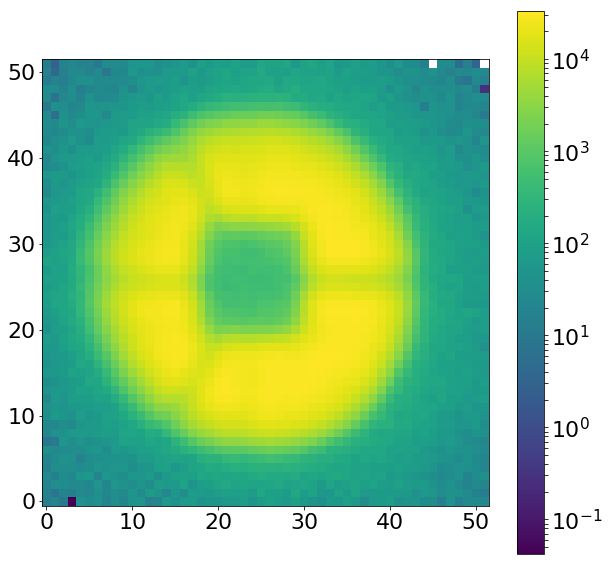

In [664]:
plt.figure(figsize=(10,10))
plt.imshow(sci_image,norm=LogNorm(),origin='lower')
plt.colorbar()

In [665]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (248, 80, 31)
minimal likelihood is: 58637.1225371
minimal chi2 reduced is: 43.363882701


In [666]:
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

          z4        z5        z6        z7        z8       z9       z10  \
0  30.018191 -0.046942 -1.034255  0.461336 -0.149557 -0.15403 -0.269664   

        z11  
0 -0.427141  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.768227    0.09334 -0.034651  0.058203  0.082399      0.08961   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  
0           0.938745             0.409157  0.032613  0.014295  
   minorAxis  pupilAngle  effective_radius_illumination  frd_sigma  det_vert  \
0   0.962441    0.635889                       1.009991   0.002491  1.025599   

   slitHolder_frac_dx  grating_lines  scattering_radius  scattering_slope  \
0           -0.076214   62944.353957          26.172283          2.509187   

   scattering_amplitude  pixel_effect   fiber_r      flux  
0              0.075668      0.666256  1.910621  0.995134  


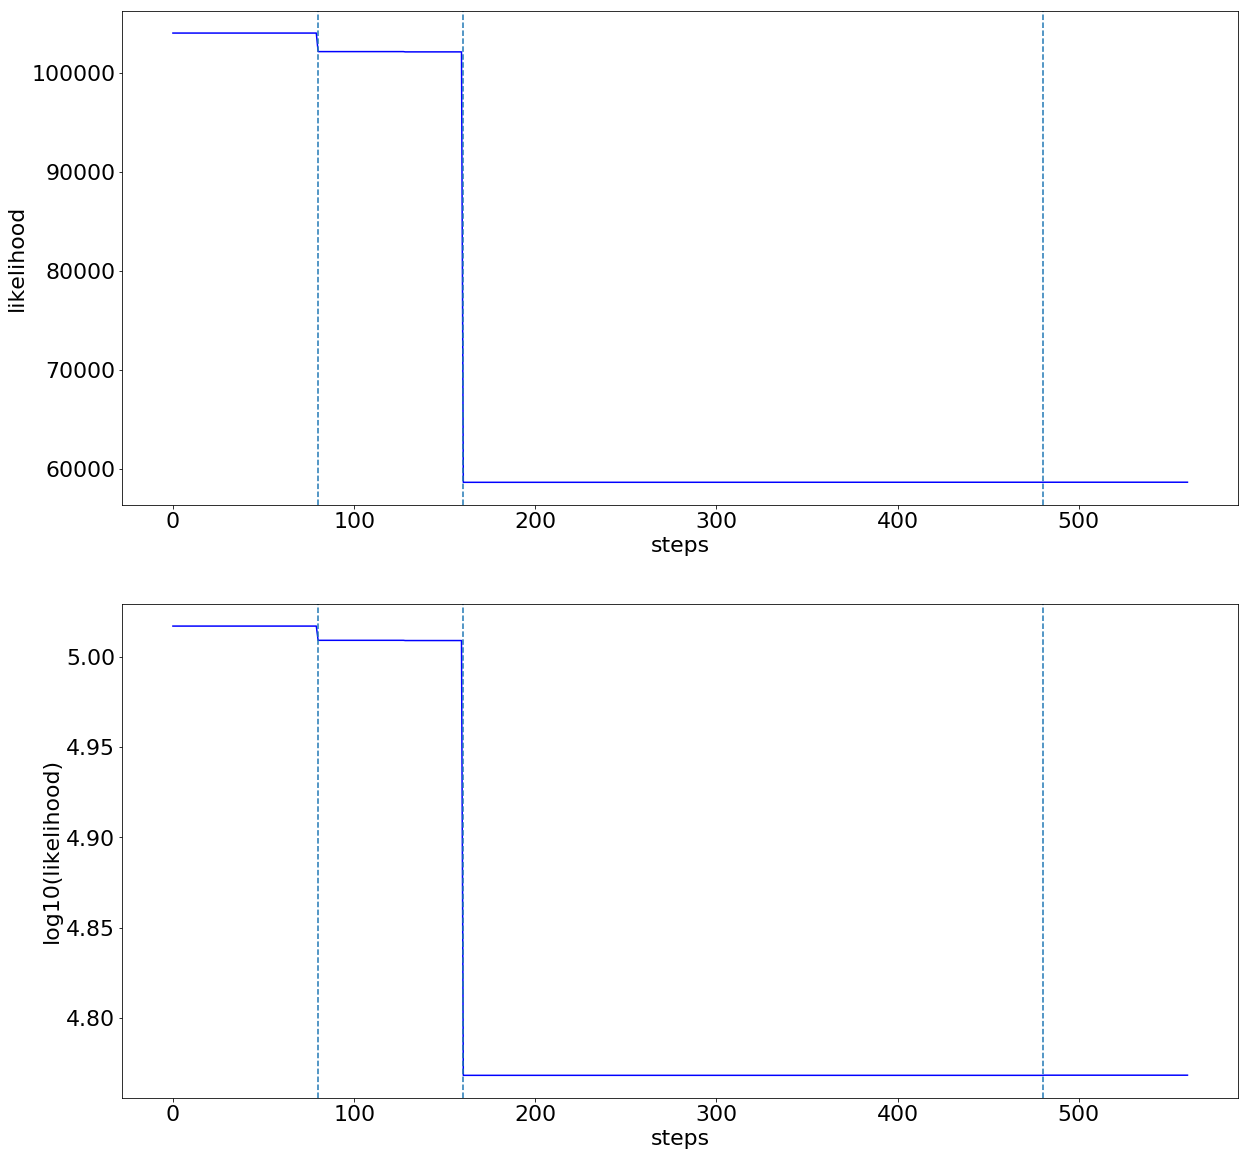

In [667]:
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(0,len(like_min),len(like_min)),like_min,'blue',ls='-')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(80,ls='--')
plt.axvline(160,ls='--')
plt.axvline(160+4*80,ls='--')
plt.subplot(212)
plt.plot(np.linspace(0,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(80,ls='--')
plt.axvline(160,ls='--')
plt.axvline(160+4*80,ls='--')

In [668]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   

#model(minchain)
model(allparameters_proposal)


-513936.14908023813

In [231]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

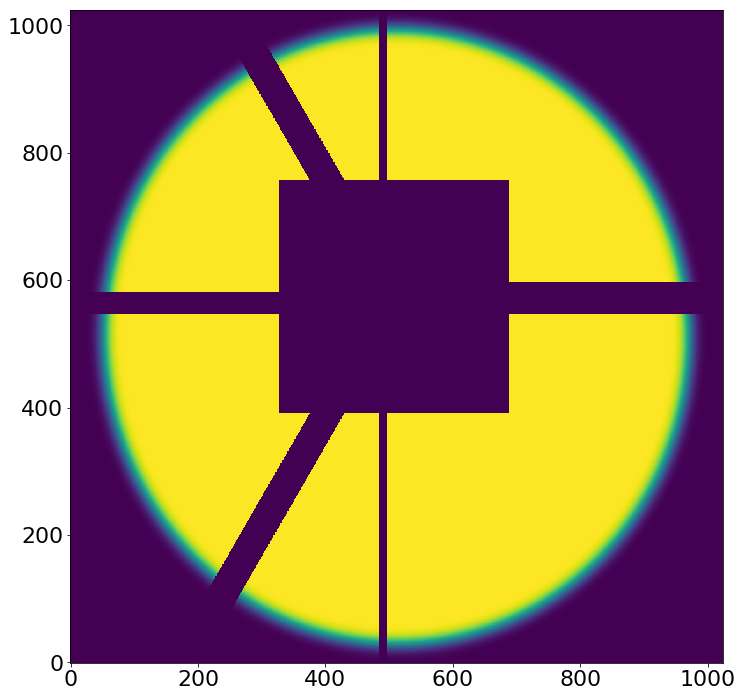

In [669]:
plt.figure(figsize=(12,12))
plt.imshow(pupililluminated,origin='lower')

chi**2 reduced is: 377.541788748
Abs of residual divided by total flux is: 0.157561021152
Abs of residual divided by largest value of a flux in the image is: 0.351360019713


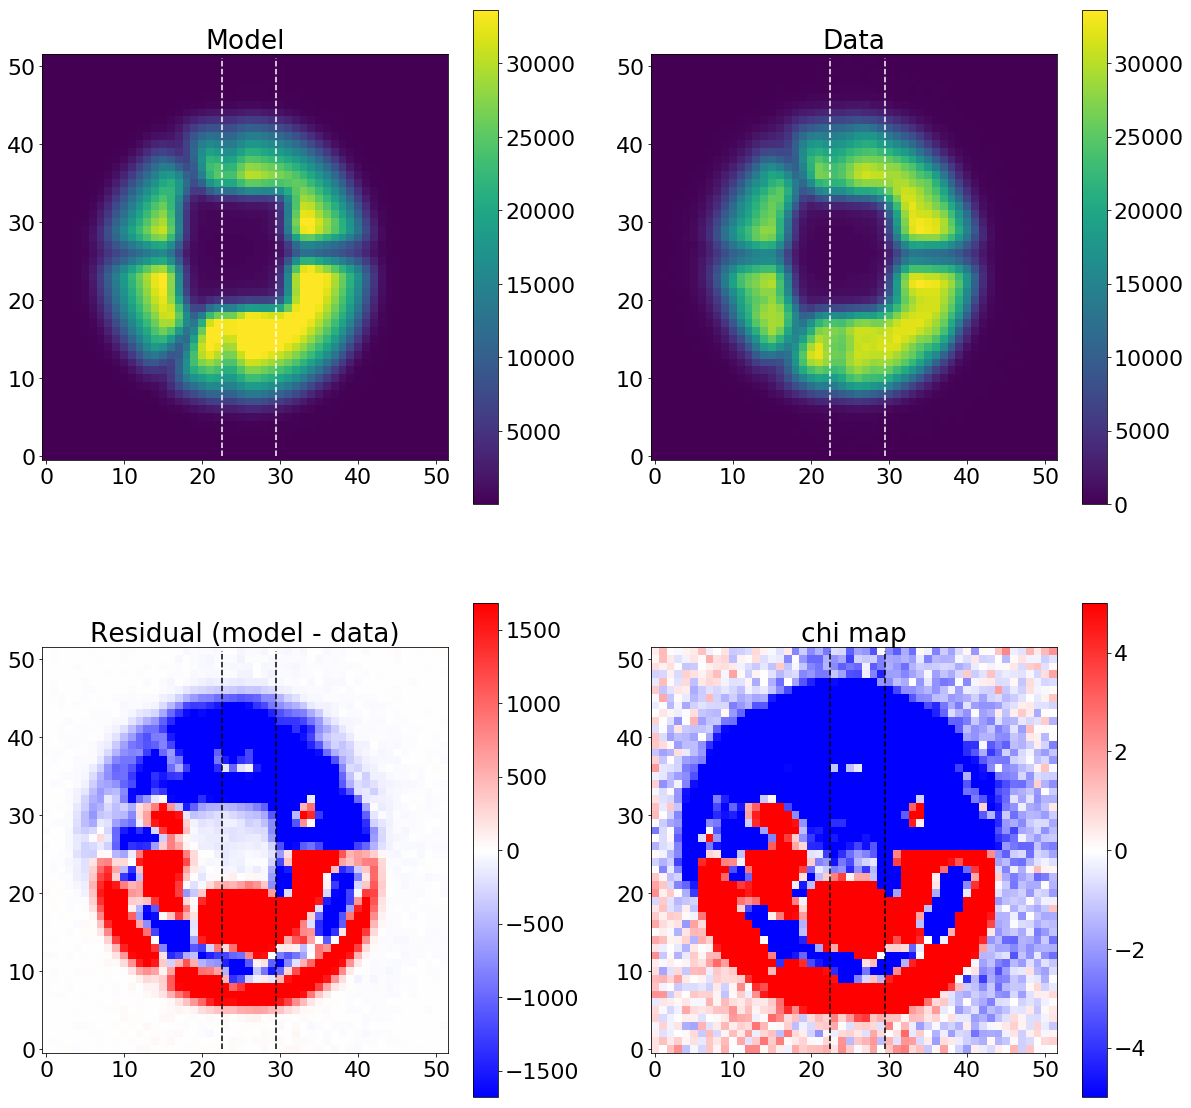

In [670]:
single_analysis.create_basic_comparison_plot()

50.0841966191
chi**2 reduced is: 50.0841966191
Abs of residual divided by total flux is: 0.0609682137019
Abs of residual divided by largest value of a flux in the image is: 0.154697428951


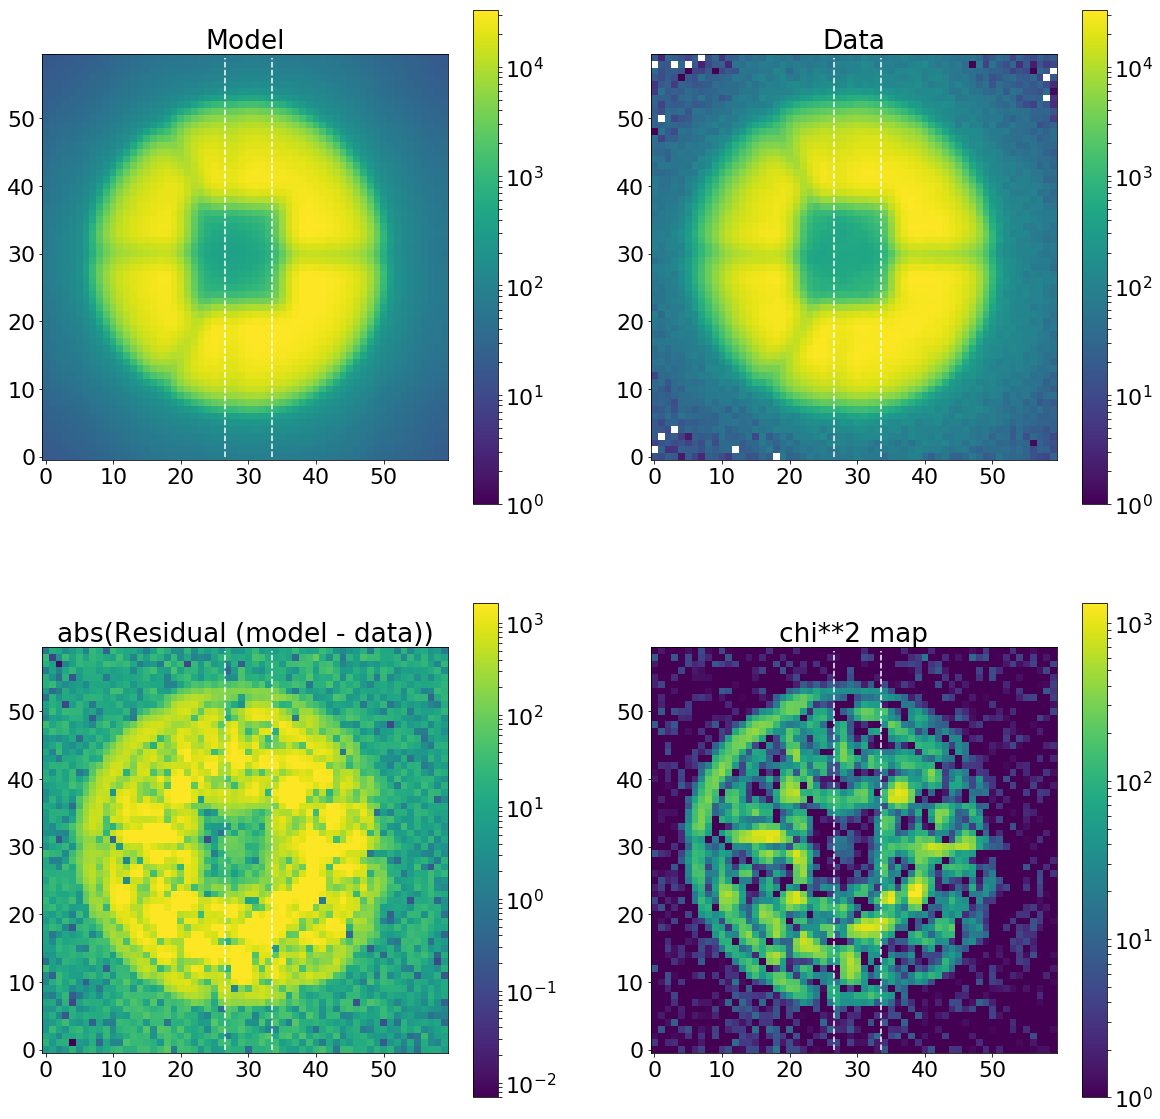

In [133]:
single_analysis.create_basic_comparison_plot_log()

In [134]:
artifical_noise=single_analysis.create_artificial_noise()

50.0841966191


0.060968213701893412

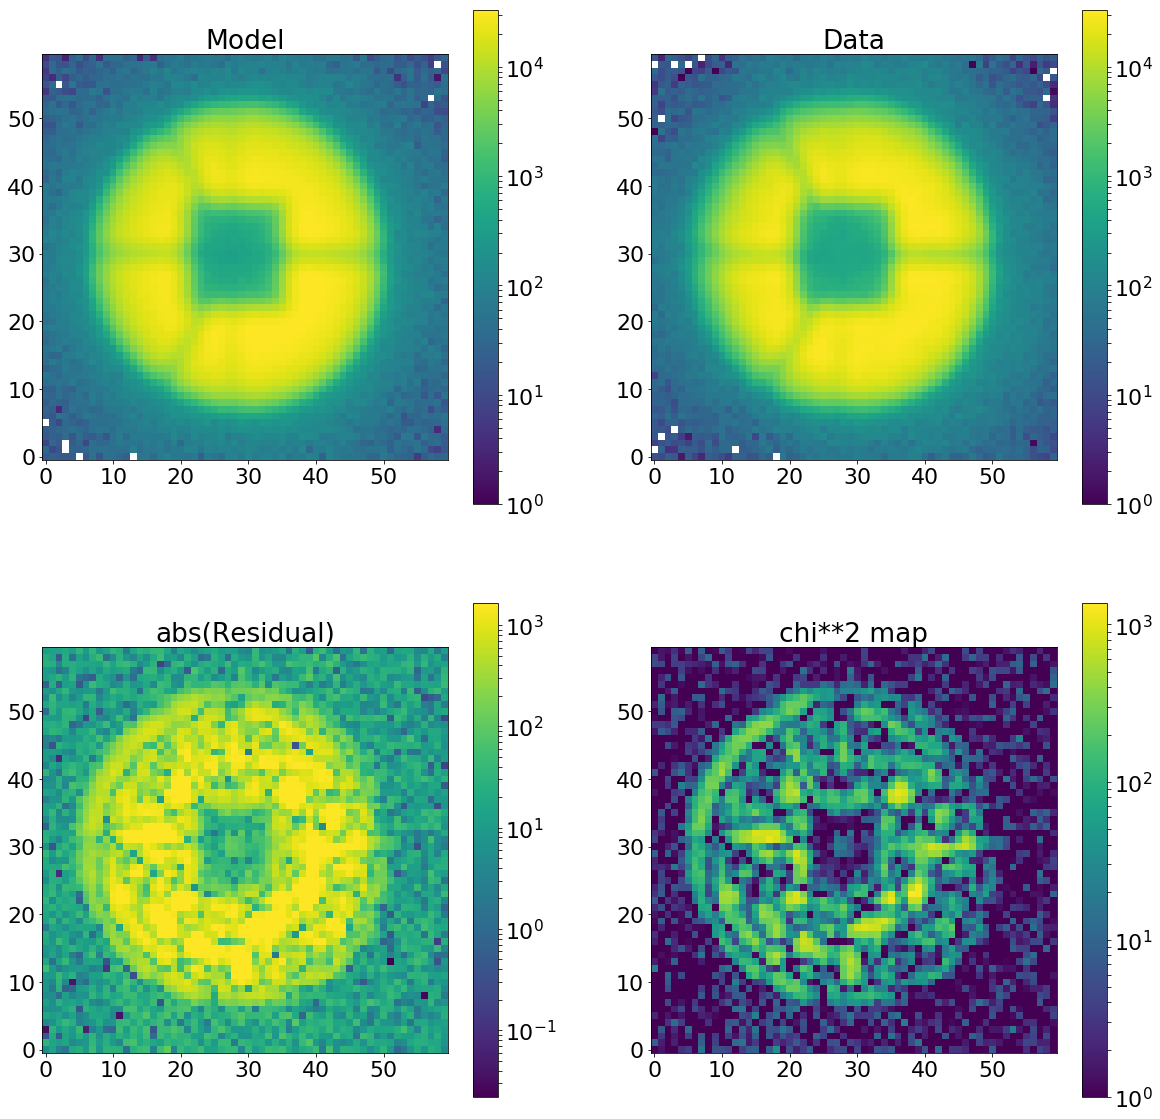

In [135]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

159.832534216
347.955655947


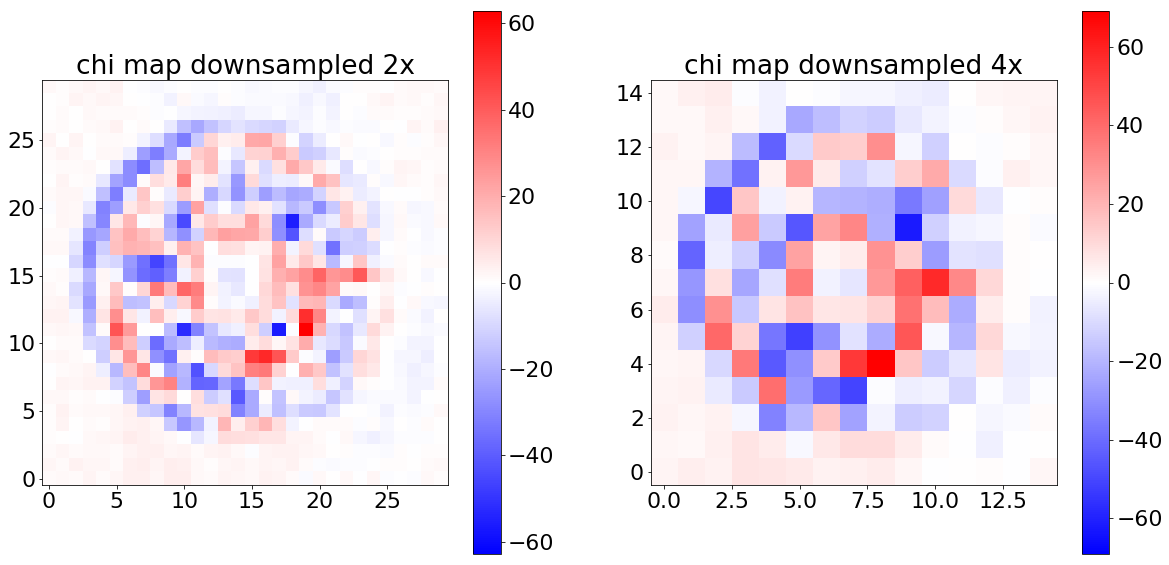

In [136]:
sci_image_2=downsample_manual_function(sci_image,int(sci_image.shape[0]/2))
sci_image_4=downsample_manual_function(sci_image,int(sci_image.shape[0]/4))

res_iapetus_2=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/2))
res_iapetus_4=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/4))

var_image_2=downsample_manual_function(var_image,int(var_image.shape[0]/2))
var_image_4=downsample_manual_function(var_image,int(var_image.shape[0]/4))

chi_downsample_2=(res_iapetus_2-sci_image_2)/np.sqrt(var_image_2)
chi_downsample_4=(res_iapetus_4-sci_image_4)/np.sqrt(var_image_4)

print(np.mean(chi_downsample_2**2))
print(np.mean(chi_downsample_4**2))


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(chi_downsample_2,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_2)),vmax=np.max(np.abs(chi_downsample_2)))
plt.colorbar()
plt.title('chi map downsampled 2x')
plt.subplot(122)
plt.imshow(chi_downsample_4,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_4)),vmax=np.max(np.abs(chi_downsample_4)))
plt.colorbar()
plt.title('chi map downsampled 4x')

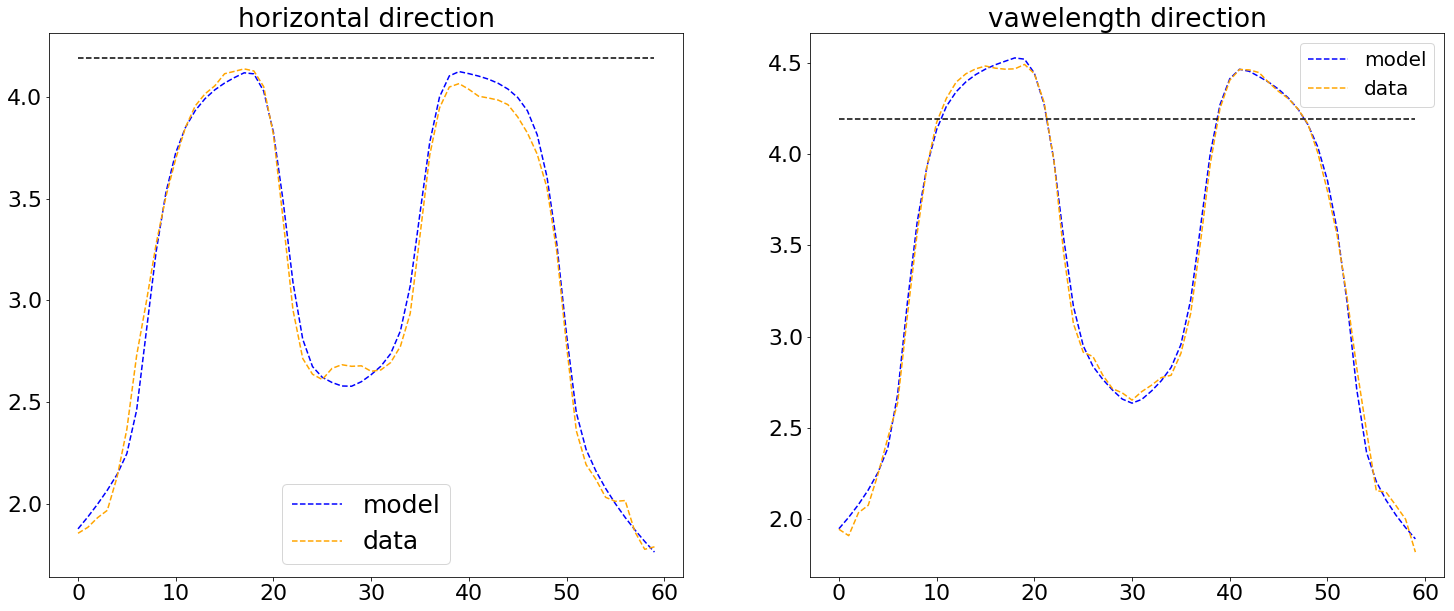

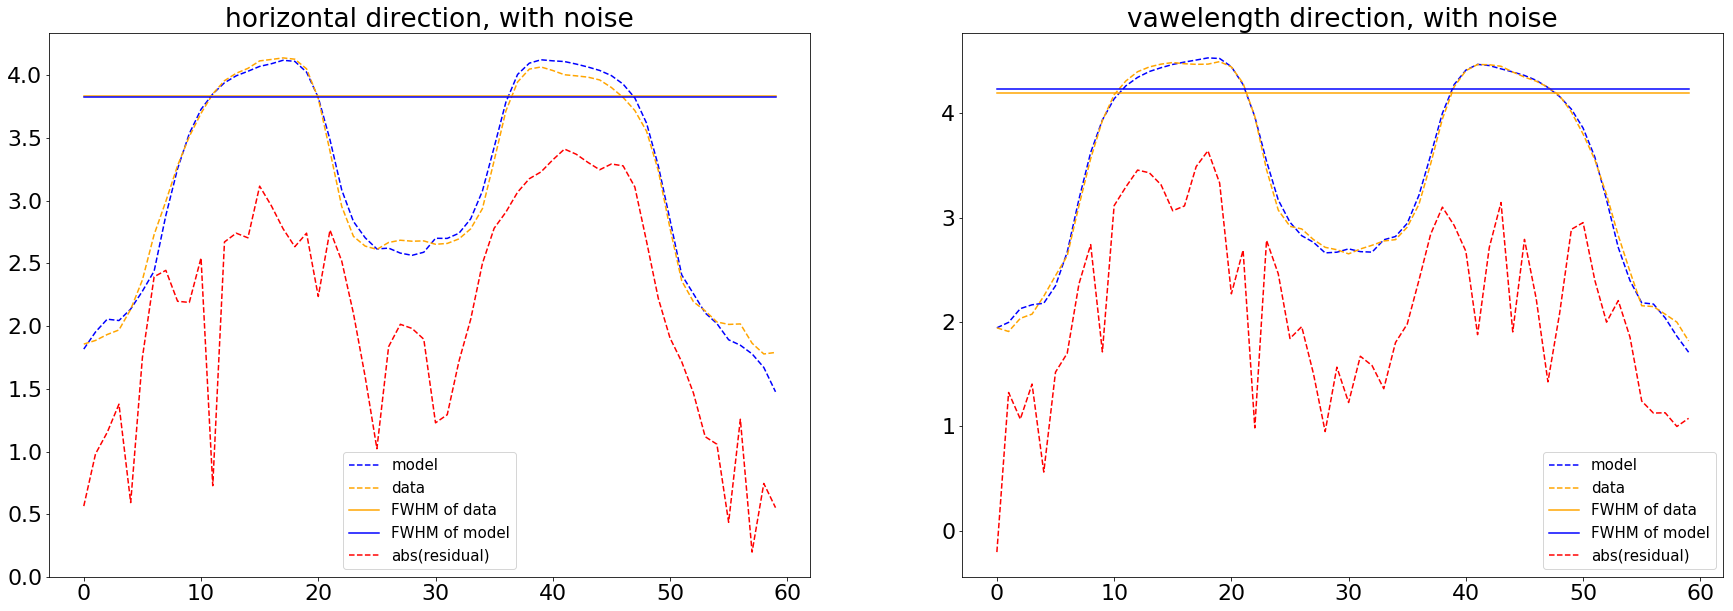

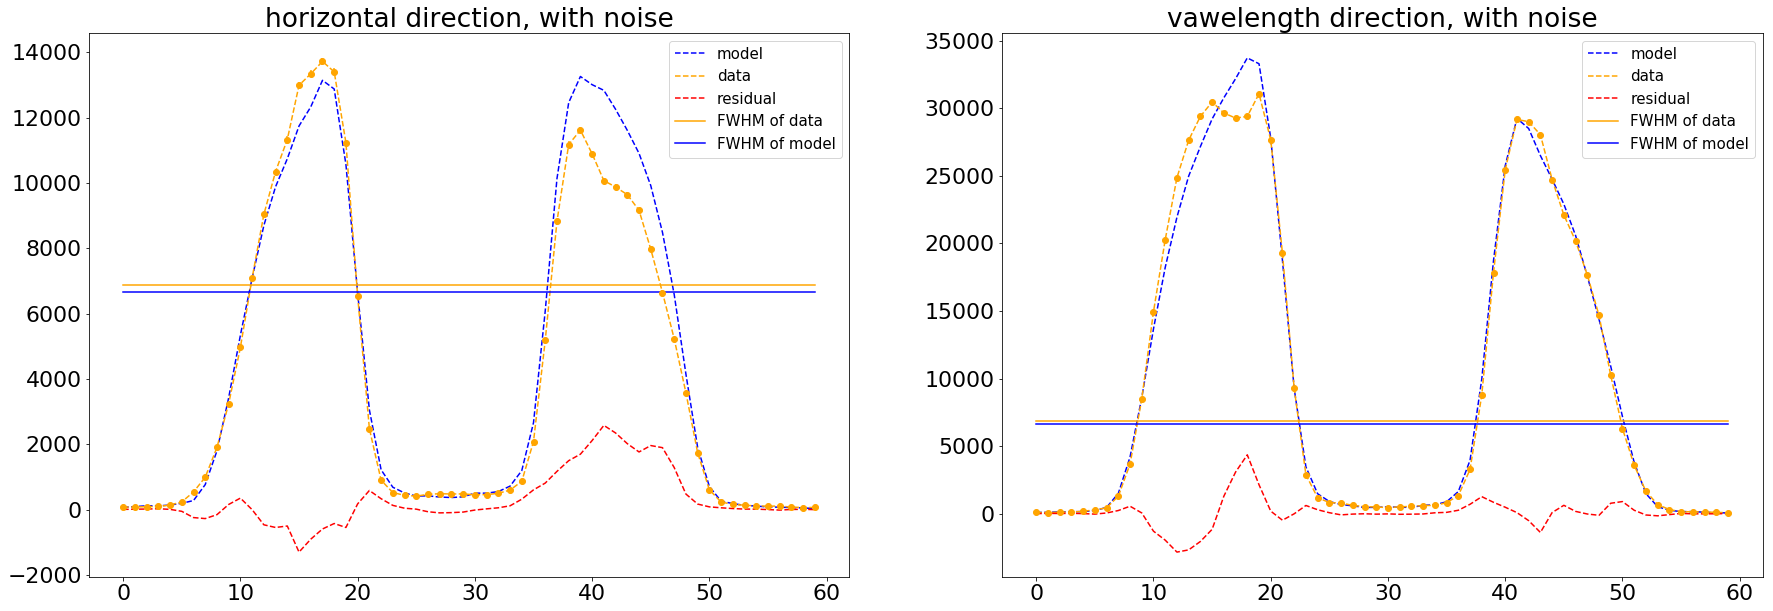

In [137]:
single_analysis.create_cut_plots()

In [270]:
#single_analysis.create_corner_plots()

## Prediction

In [68]:
minchain=solution_at_0

In [69]:
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(minchain)-2]]),columns=columns[8:])
print(dfglobal)

        z4        z5       z6        z7        z8        z9       z10  \
0  1.99845 -0.040228 -1.37404  0.375377  0.113178 -0.268723 -0.293751   

        z11  
0  0.003898  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.668673   0.108248 -0.011915 -0.136592  0.067136      0.10389   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum    ...     \
0           0.987071             0.782297  0.047788  0.050456    ...      

   frd_sigma  det_vert  slitHolder_frac_dx  grating_lines  scattering_radius  \
0   0.001507  1.112715           -0.057484   33790.407753          16.424449   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0          2.131348              0.078438      0.569668  1.719151  0.997081  

[1 rows x 23 columns]


In [70]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   

model(minchain)


-inf

In [3080]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

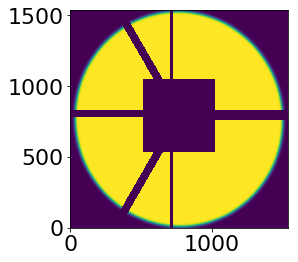

In [3081]:
plt.imshow(pupililluminated,origin='lower')

ValueError: operands could not be broadcast together with shapes (60,60) (20,20) 

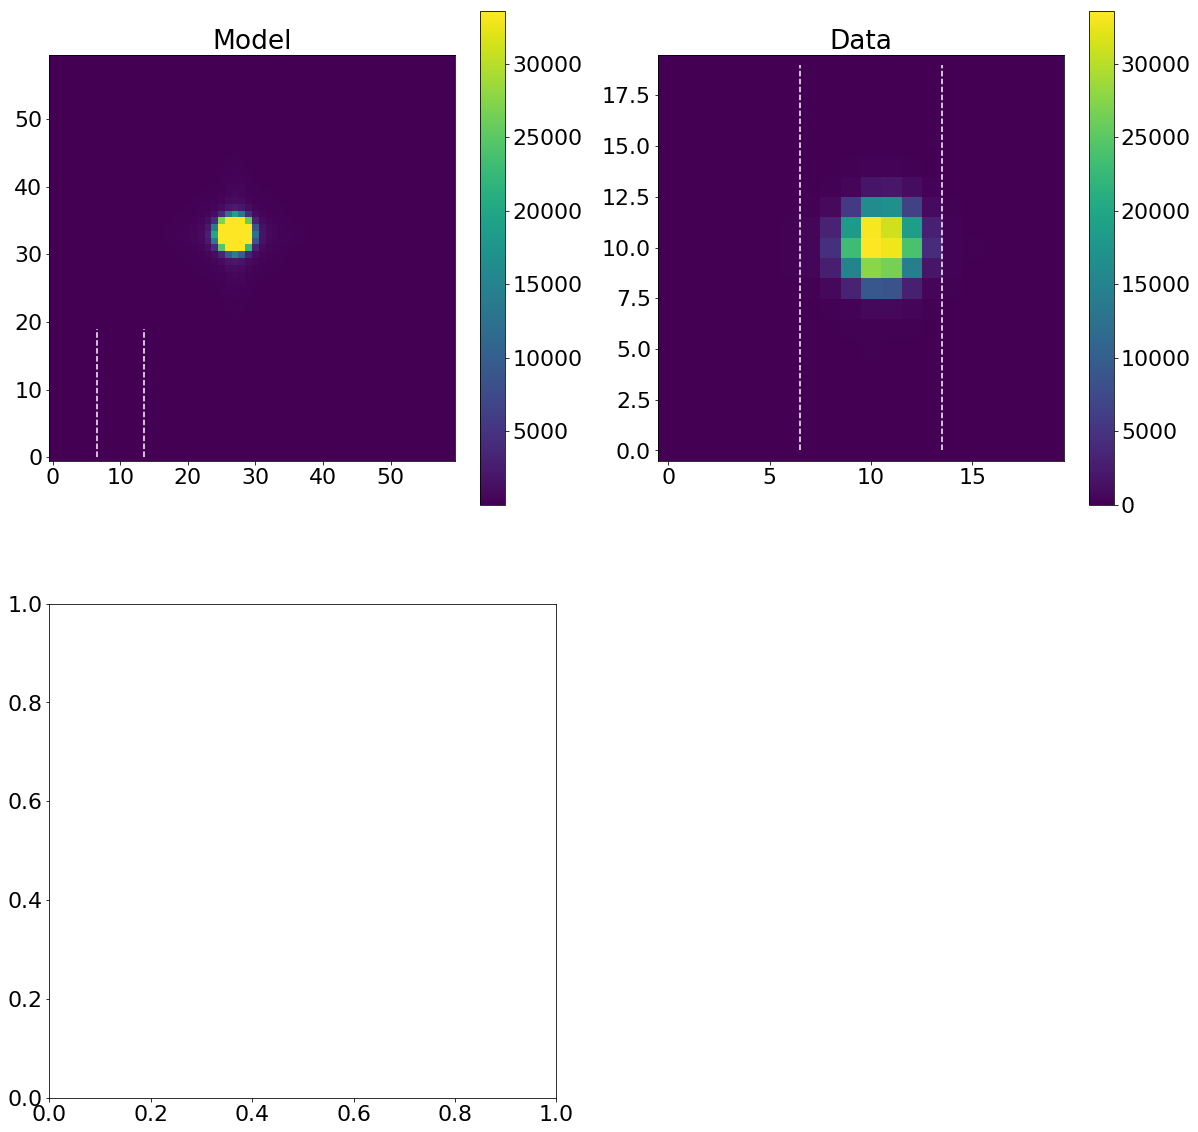

In [3082]:
single_analysis.create_basic_comparison_plot()

22.7791330249
chi**2 reduced is: 22.7791330249
Abs of residual divided by total flux is: 0.0893576720799
Abs of residual divided by largest value of a flux in the image is: 0.102783680643


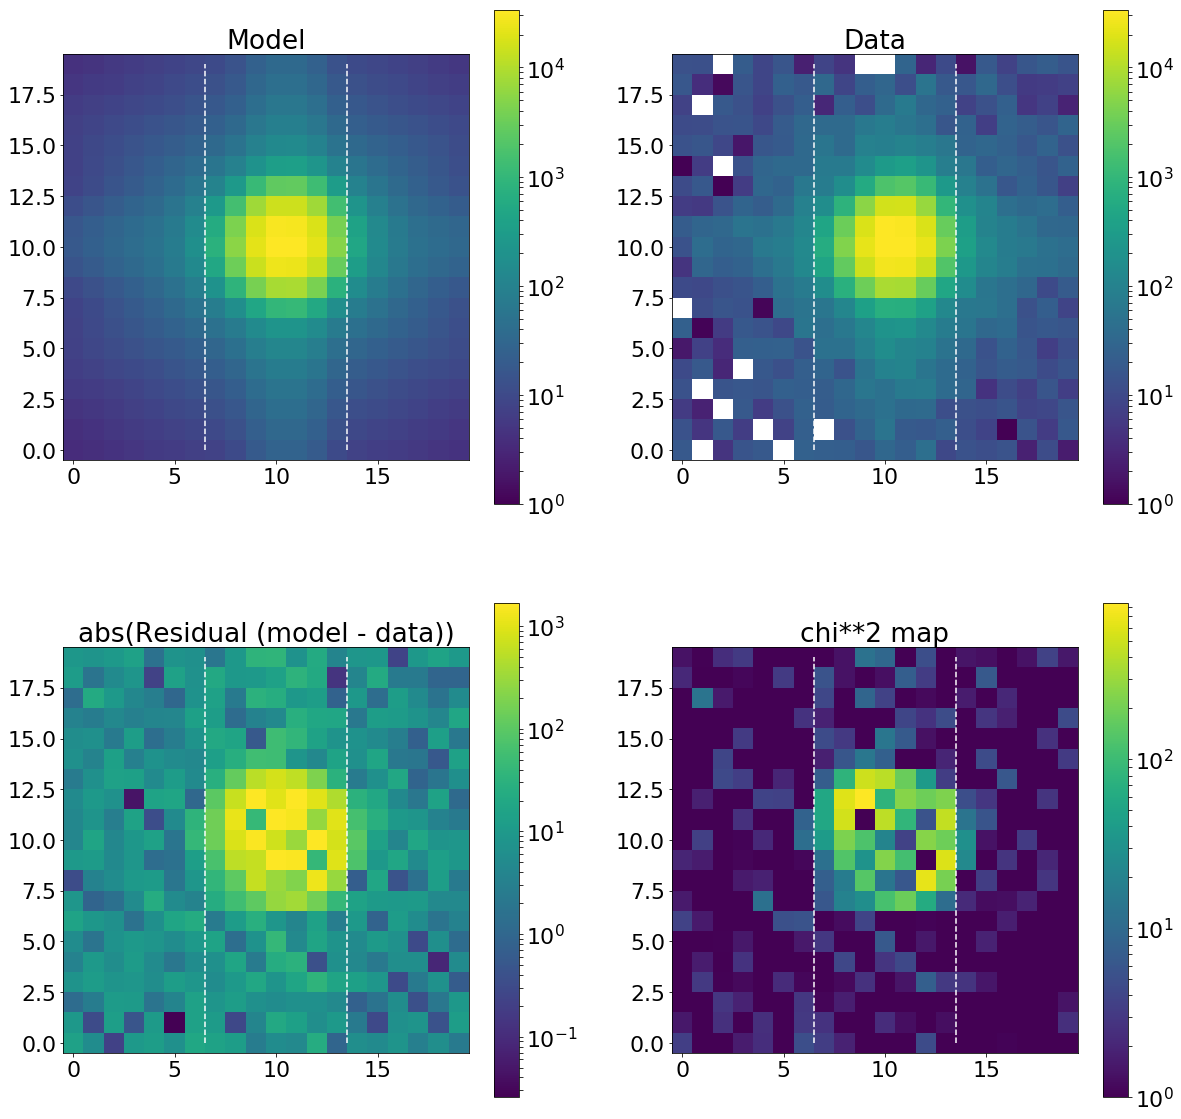

In [2928]:
single_analysis.create_basic_comparison_plot_log()

In [2929]:
artifical_noise=single_analysis.create_artificial_noise()

22.7791330249


0.089357672079854206

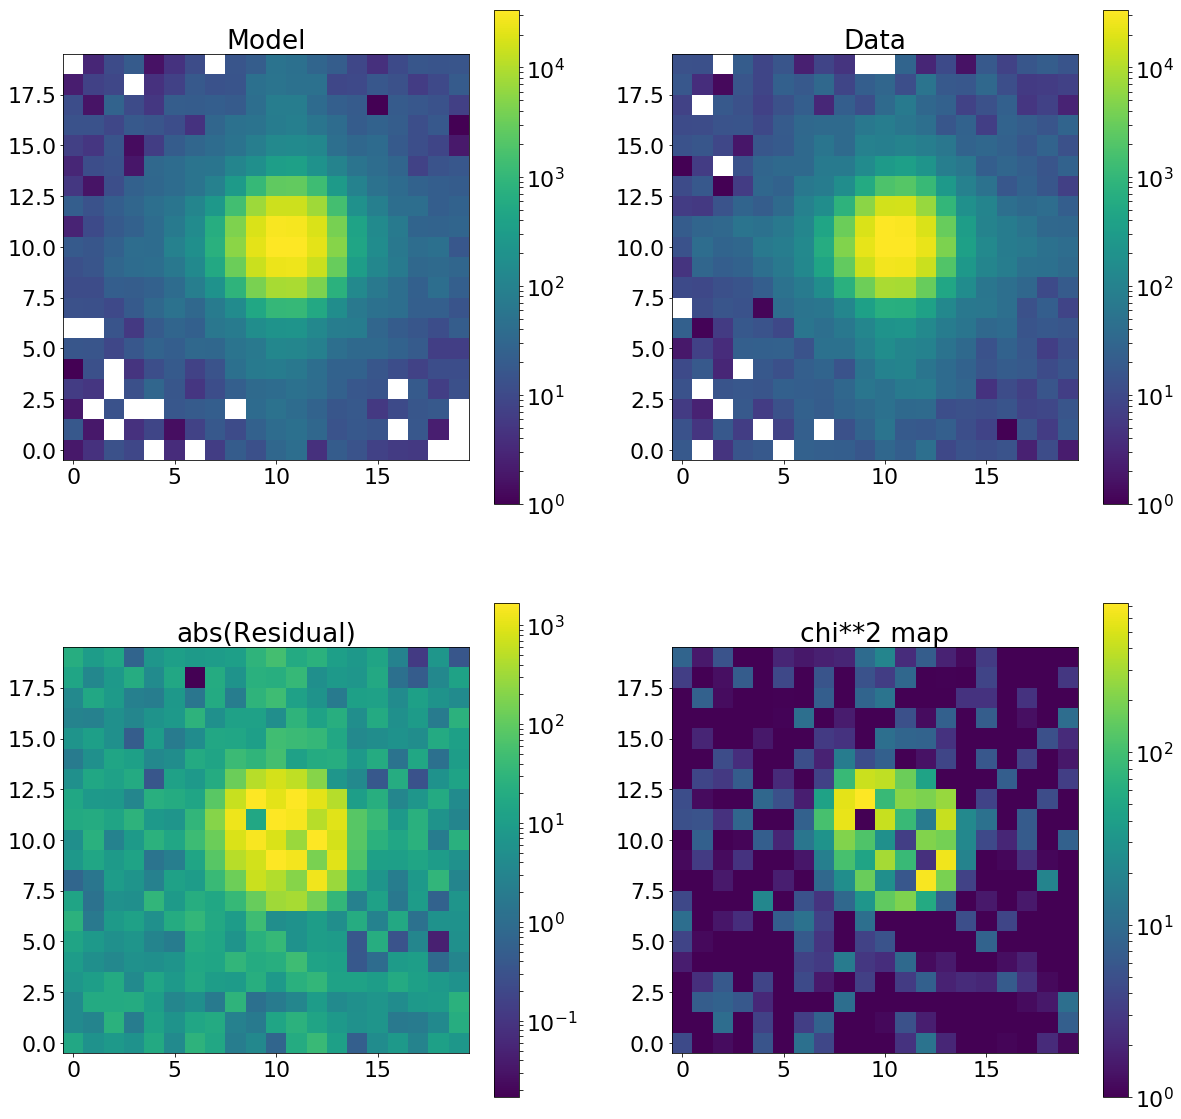

In [2930]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

40.2307191103
48.3508789667


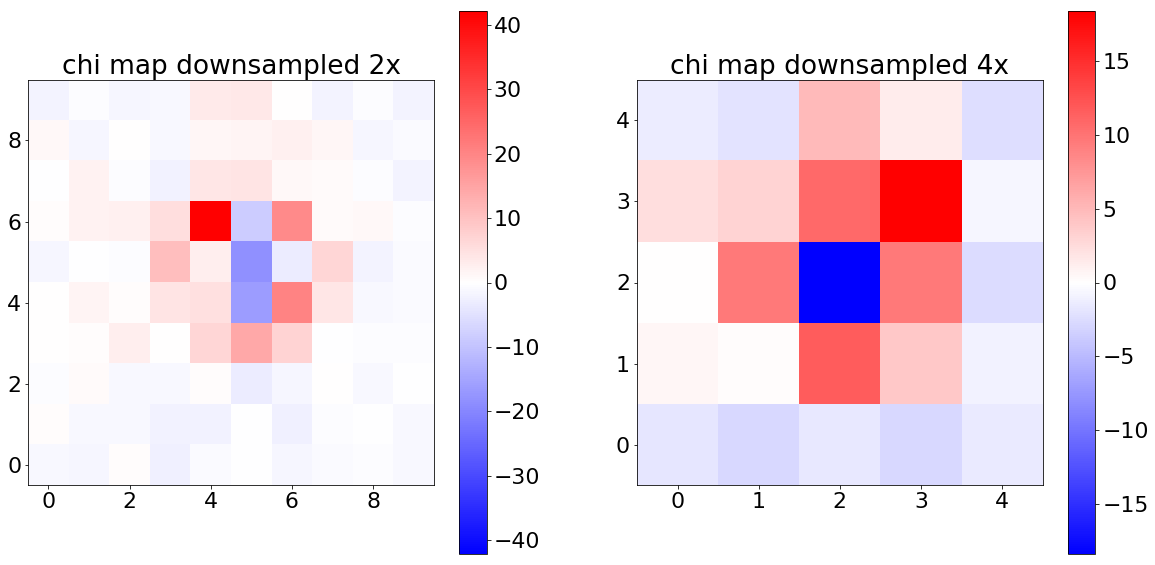

In [2931]:
sci_image_2=downsample_manual_function(sci_image,int(sci_image.shape[0]/2))
sci_image_4=downsample_manual_function(sci_image,int(sci_image.shape[0]/4))

res_iapetus_2=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/2))
res_iapetus_4=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/4))

var_image_2=downsample_manual_function(var_image,int(var_image.shape[0]/2))
var_image_4=downsample_manual_function(var_image,int(var_image.shape[0]/4))

chi_downsample_2=(res_iapetus_2-sci_image_2)/np.sqrt(var_image_2)
chi_downsample_4=(res_iapetus_4-sci_image_4)/np.sqrt(var_image_4)

print(np.mean(chi_downsample_2**2))
print(np.mean(chi_downsample_4**2))


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(chi_downsample_2,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_2)),vmax=np.max(np.abs(chi_downsample_2)))
plt.colorbar()
plt.title('chi map downsampled 2x')
plt.subplot(122)
plt.imshow(chi_downsample_4,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_4)),vmax=np.max(np.abs(chi_downsample_4)))
plt.colorbar()
plt.title('chi map downsampled 4x')

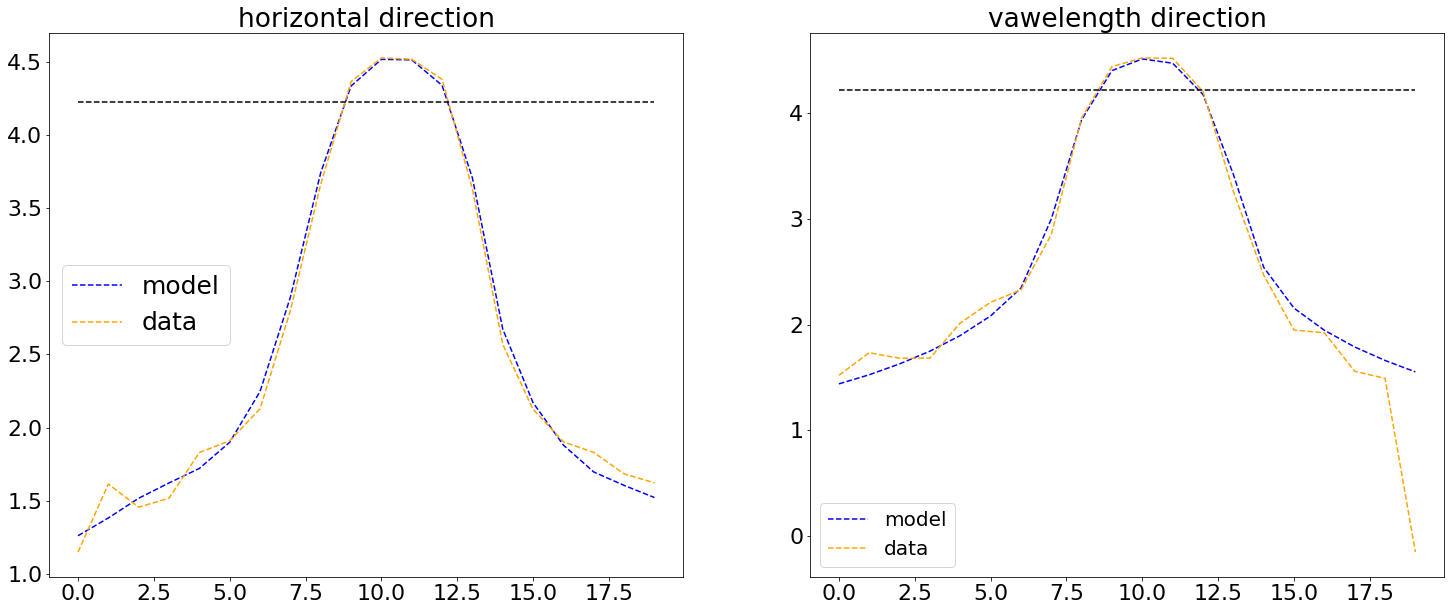

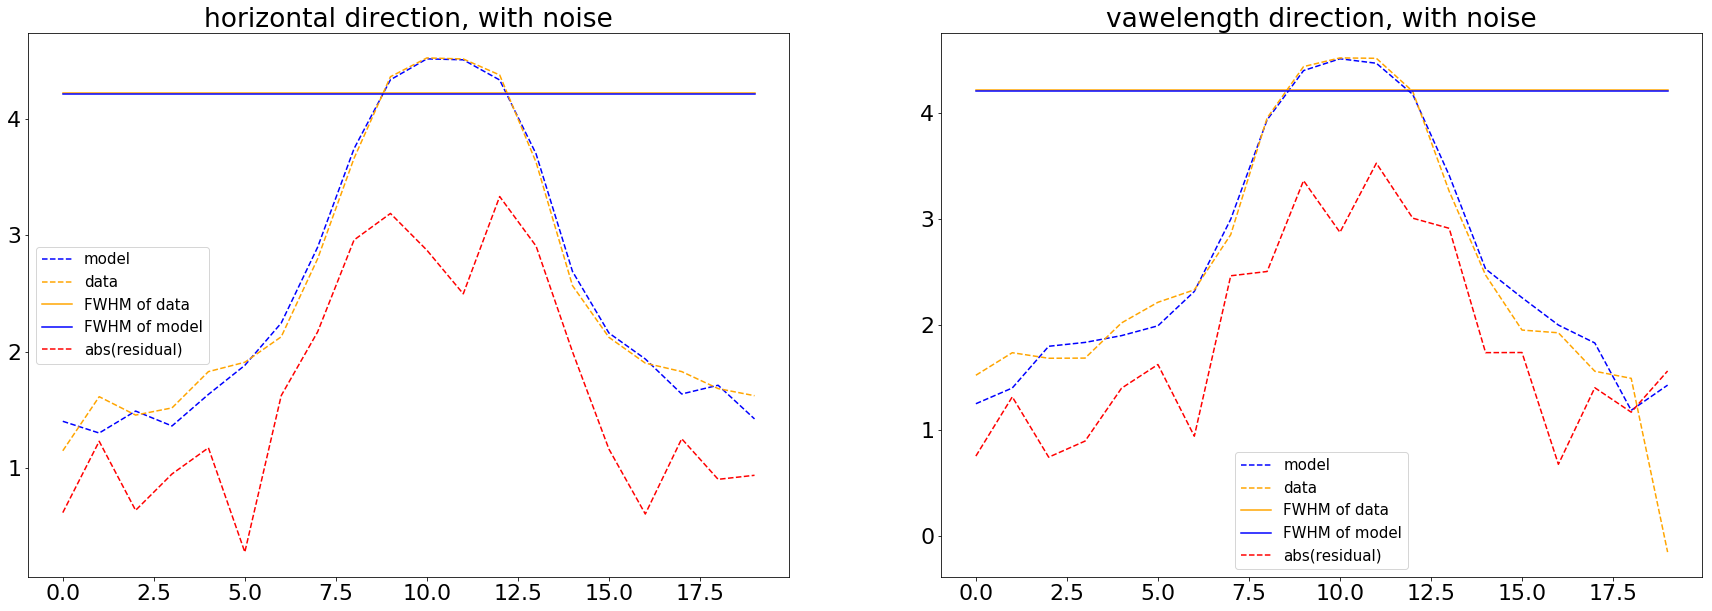

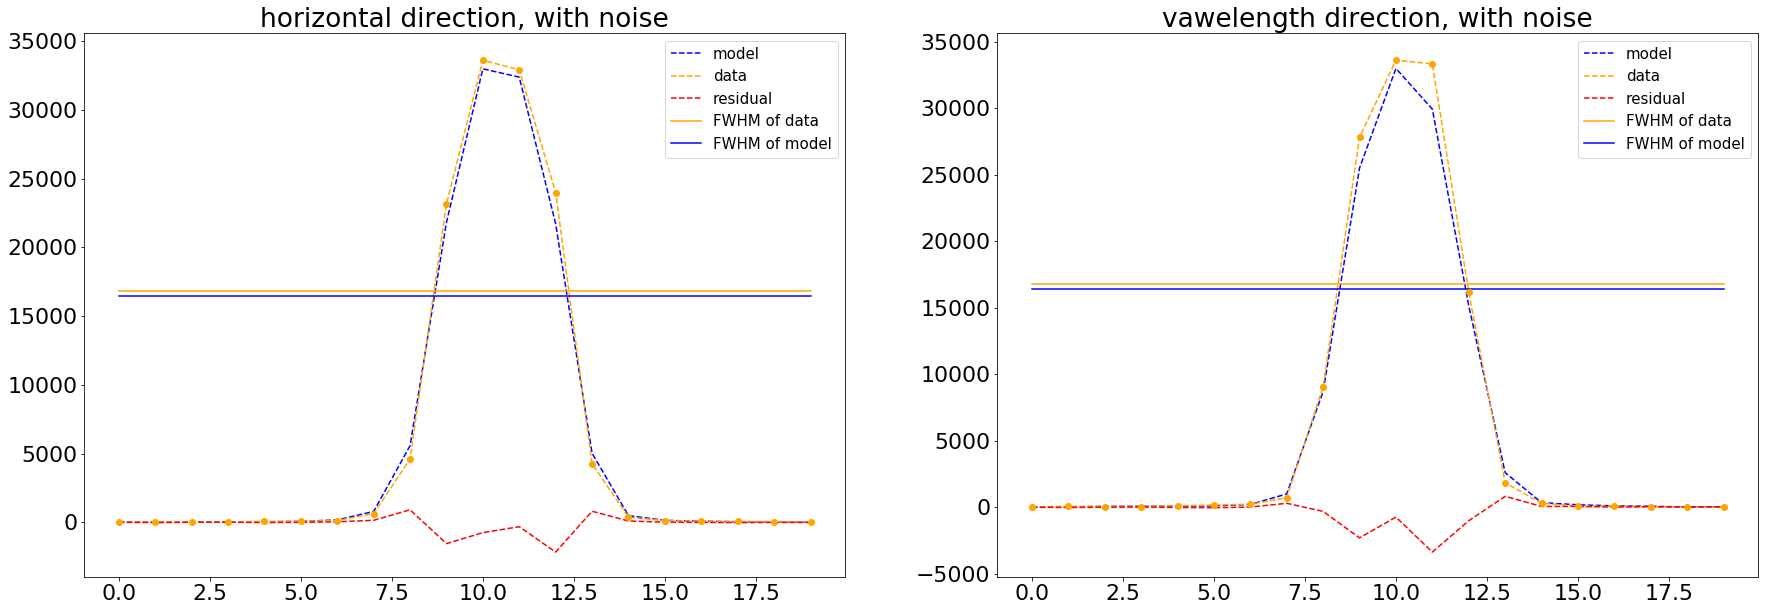

In [2932]:
single_analysis.create_cut_plots()

In [2933]:
#single_analysis.create_corner_plots()

## Across focal plane

In [251]:
single_number_for_single_pos_full\
=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15/single_number_for_single_pos_full.npy") 

In [252]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent', 'x_ilum','y_ilum',
         'minorAxis','pupilAngle','effective_radius_illumination','frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']     

columns_analysis=columns+['chi2','chi2max']


results_of_fit_many_single_defocus=pd.DataFrame(np.zeros((len(single_number_for_single_pos_full[:,0]),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=single_number_for_single_pos_full[:,0],columns=columns_analysis)
err_results_of_fit_many_single_defocus=pd.DataFrame(np.zeros((len(single_number_for_single_pos_full[:,0]),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=single_number_for_single_pos_full[:,0],columns=columns_analysis)

results_of_fit_many_single_defocus_pd=pd.DataFrame(results_of_fit_many_single_defocus)
err_results_of_fit_many_single_defocus_pd=pd.DataFrame(err_results_of_fit_many_single_defocus)

In [253]:
results_of_fit_many = {'m4': results_of_fit_many_single_defocus_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_pd.copy(),
                       '0d' : results_of_fit_many_single_defocus_pd.copy(),
                       '0' :  results_of_fit_many_single_defocus_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_pd.copy()}


In [254]:
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']

# arrange all results in one pandas 
date='Sep19'

RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

single_defocus_list=[8552,8555,8558,8561,8564,8567,8570,8573,8600,8603,8606,8609,8612,8615,8618,8621,8624,8627]

for single_number in range(100):
    
    results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)


    image_index=single_number
    method='P'
    eps=5

    res_likelihood=[]

    for single_defocus in tqdm(range(0,len(single_defocus_list))):
        try:
            obs=single_defocus_list[single_defocus]
            try:

                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
                print('obs'+str(single_number)+' (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
                print('obs'+str(single_number)+'  (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
                var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
            else:       
                sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
                var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')

            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2



            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err,np.array([1,1])),axis=0)



        except:
            ValueError

    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:
        #print(single_number,i)
        results_of_fit_many[label[i]].at[single_number]=results_of_fit_single.iloc[i]
        #print(results_of_fit_many[label[9]].iloc[single_number])
    
    
    results_of_fit_single_full=np.copy(results_of_fit_single)
    err_results_of_fit_single_full=np.copy(err_results_of_fit_single)

    results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    
    results_of_fit_single_without_focus=results_of_fit_single.copy()
    err_results_of_fit_single_without_focus=err_results_of_fit_single.copy()
    results_of_fit_single_without_focus=results_of_fit_single_without_focus[results_of_fit_single_without_focus.index.values!='0']
    err_results_of_fit_single_without_focus=err_results_of_fit_single_without_focus[err_results_of_fit_single_without_focus.index.values!='0']

    results_of_fit_single_only_focus=results_of_fit_single.copy()
    err_results_of_fit_single_only_focus=err_results_of_fit_single.copy()
    results_of_fit_single_only_focus=results_of_fit_single_only_focus[results_of_fit_single_only_focus.index.values=='0']
    err_results_of_fit_single_only_focus=err_results_of_fit_single[err_results_of_fit_single_only_focus.index.values=='0']
    
    if len(np.array(results_of_fit_single[q]))<=3:
        pass
    else:
        solution_at_0=[]
        for q in columns_analysis:
                z4_arr=np.array(results_of_fit_single[q])
                z4_arr_err=np.array(err_results_of_fit_single[q])

                z4_arr_no0=np.array(results_of_fit_single_without_focus[q])
                z4_arr_no0_err=np.array(err_results_of_fit_single_without_focus[q])

                z4_arr_only0=np.array(results_of_fit_single_only_focus[q])
                z4_arr_only0_err=np.array(err_results_of_fit_single_only_focus[q])


                index_arr=np.array(err_results_of_fit_single.index).astype(float)
                #popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)

                #index_arr=np.array(results_of_fit_single.index.values)
                #index_arr=np.array(map(float,index_arr))
                index_arr_plot=np.copy(index_arr)
                #index_arr_plot[5]=index_arr_plot[5]+0.01

                index_arr_no0=np.array(results_of_fit_single_without_focus.index).astype(float)

                if len(results_of_fit_single_only_focus.index)>10:
                    index_arr_only0=np.array([0])
                else:
                    index_arr_only0=np.array(results_of_fit_single_only_focus.index).astype(float)       




                fit_res=[]
                if q in columns[:8]:
                    # these variables are fit via linear fit
                    popt, pcov = curve_fit(lin_fit_1D, index_arr_no0, z4_arr_no0, sigma=z4_arr_no0_err)
                    for i in np.linspace(-4.5,4.5,19):
                        fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
                    solution_at_0.append(fit_res[9])
                if q in np.concatenate((np.array(columns[8:21]),np.array(['pixel_effect','frd_sigma','det_vert','slitHolder_frac_dx',])),axis=0):
                    # these variables are set at mean value (constant fit)
                    popt, pcov = curve_fit(lin_fit_1DConstant, index_arr_no0, z4_arr_no0, sigma=z4_arr_no0_err)
                    for i in np.linspace(-4.5,4.5,19):
                        fit_res.append(lin_fit_1DConstant(i,popt[0]))
                    solution_at_0.append(fit_res[9])
                if q in np.array(['grating_lines','scattering_radius', 'scattering_slope', 'scattering_amplitude','fiber_r','flux','chi2','chi2max']):
                    # these variables are set at value at 0
                    if z4_arr_only0.size==1:
                        for i in np.linspace(-4.5,4.5,19):
                            fit_res.append(z4_arr_only0) 
                        solution_at_0.append(fit_res[9])
                    else:
                        popt, pcov = curve_fit(lin_fit_1DConstant, index_arr_only0, z4_arr_only0, sigma=z4_arr_only0_err)
                        for i in np.linspace(-4.5,4.5,19):
                            fit_res.append(lin_fit_1DConstant(i,popt[0]))    
                        solution_at_0.append(fit_res[9])


                #solution_at_0.append(fit_res[5])
                plt.figure(figsize=(20,10))
                plt.errorbar(index_arr_plot,z4_arr,yerr=z4_arr_err,color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
                plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
                plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),'--',color='black')
                plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red")
                plt.title(q,size=40)
                plt.legend(fontsize=25)
                plt.xlabel('defocus lab [mm]',size=30)
                plt.ylabel('defocus model',size=30)

                if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'):
                    os.makedirs(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
                plt.savefig(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'+str(q))

                if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(q)+'/'):
                    os.makedirs(IMAGES_FOLDER+'Defocus/'+str(q)+'/')
                plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q)+'/'+str(single_number))

                plt.close()

        solution_at_0=np.array(solution_at_0)    
        results_of_fit_many[label[18]].at[single_number]=solution_at_0    
    
    
        
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many[label[i]]=results_of_fit_many[label[i]][np.abs(results_of_fit_many[label[i]]['z4'])>0]




  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 189.60it/s]

obs0 (Emcee3): 8552 is found!
obs0  (Emcee2): 8555 is found!
obs0 (Emcee3): 8558 is found!
obs0 (Emcee3): 8603 is found!
obs0 (Emcee3): 8621 is found!
obs0 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 208.23it/s]

obs1 (Emcee3): 8552 is found!
obs1  (Emcee2): 8555 is found!
obs1 (Emcee3): 8558 is found!
obs1 (Emcee3): 8603 is found!
obs1 (Emcee3): 8621 is found!
obs1 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 5840.29it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 5995.67it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 72%|████████████████████████████████████████▍               | 13/18 [00:00<00:00, 125.15it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 116.28it/s]

obs4 (Emcee3): 8552 is found!
obs4 (Emcee3): 8567 is found!
obs4 (Emcee3): 8573 is found!
obs4 (Emcee3): 8603 is found!
obs4 (Emcee3): 8606 is found!
obs4 (Emcee3): 8612 is found!
obs4 (Emcee3): 8621 is found!
obs4 (Emcee3): 8624 is found!
obs4 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 262.35it/s]

obs5 (Emcee3): 8555 is found!
obs5 (Emcee3): 8603 is found!
obs5 (Emcee3): 8621 is found!
obs5  (Emcee2): 8624 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 61%|██████████████████████████████████▏                     | 11/18 [00:00<00:00, 106.21it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 104.40it/s]

obs6 (Emcee3): 8552 is found!
obs6 (Emcee3): 8555 is found!
obs6 (Emcee3): 8567 is found!
obs6 (Emcee3): 8573 is found!
obs6 (Emcee3): 8603 is found!
obs6 (Emcee3): 8606 is found!
obs6 (Emcee3): 8612 is found!
obs6 (Emcee3): 8621 is found!
obs6 (Emcee3): 8624 is found!
obs6 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 72%|████████████████████████████████████████▍               | 13/18 [00:00<00:00, 114.56it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 108.84it/s]

obs7 (Emcee3): 8552 is found!
obs7 (Emcee3): 8555 is found!
obs7 (Emcee3): 8567 is found!
obs7 (Emcee3): 8573 is found!
obs7 (Emcee3): 8603 is found!
obs7 (Emcee3): 8606 is found!
obs7 (Emcee3): 8612 is found!
obs7 (Emcee3): 8621 is found!
obs7 (Emcee3): 8624 is found!
obs7 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 359.37it/s]

obs8  (Emcee2): 8552 is found!
obs8  (Emcee2): 8555 is found!
obs8 (Emcee3): 8603 is found!
obs8 (Emcee3): 8621 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 271.76it/s]

obs9  (Emcee2): 8552 is found!
obs9  (Emcee2): 8555 is found!
obs9 (Emcee3): 8603 is found!
obs9 (Emcee3): 8621 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 4012.19it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 6828.64it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 4973.48it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 4846.42it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 5540.29it/s]


  0%|                      

obs15 (Emcee3): 8552 is found!
obs15 (Emcee3): 8555 is found!
obs15 (Emcee3): 8558 is found!
obs15 (Emcee3): 8603 is found!
obs15  (Emcee2): 8624 is found!
obs15 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 8686.86it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████| 18/18 [00:00<00:00, 10260.60it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 5120.56it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 6765.01it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 9444.27it/s]


  0%|                      

obs24 (Emcee3): 8552 is found!
obs24 (Emcee3): 8567 is found!
obs24 (Emcee3): 8573 is found!
obs24 (Emcee3): 8603 is found!
obs24 (Emcee3): 8606 is found!
obs24 (Emcee3): 8612 is found!
obs24 (Emcee3): 8621 is found!
obs24 (Emcee3): 8624 is found!
obs24 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 93.34it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 93.64it/s]

obs25 (Emcee3): 8552 is found!
obs25 (Emcee3): 8555 is found!
obs25 (Emcee3): 8558 is found!
obs25 (Emcee3): 8567 is found!
obs25 (Emcee3): 8573 is found!
obs25 (Emcee3): 8603 is found!
obs25 (Emcee3): 8606 is found!
obs25 (Emcee3): 8612 is found!
obs25  (Emcee2): 8621 is found!
obs25 (Emcee3): 8624 is found!
obs25 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 92.58it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 87.86it/s]

obs26 (Emcee3): 8552 is found!
obs26 (Emcee3): 8555 is found!
obs26 (Emcee3): 8567 is found!
obs26 (Emcee3): 8573 is found!
obs26 (Emcee3): 8603 is found!
obs26 (Emcee3): 8606 is found!
obs26 (Emcee3): 8612 is found!
obs26 (Emcee3): 8621 is found!
obs26 (Emcee3): 8624 is found!
obs26 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 85.61it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 86.97it/s]

obs27 (Emcee3): 8552 is found!
obs27 (Emcee3): 8555 is found!
obs27 (Emcee3): 8567 is found!
obs27 (Emcee3): 8573 is found!
obs27 (Emcee3): 8603 is found!
obs27 (Emcee3): 8606 is found!
obs27 (Emcee3): 8612 is found!
obs27 (Emcee3): 8621 is found!
obs27 (Emcee3): 8624 is found!
obs27 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2859.43it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2764.26it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 4708.29it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 5727.32it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 7103.64it/s]


  0%|                      

obs34 (Emcee3): 8552 is found!
obs34 (Emcee3): 8567 is found!
obs34 (Emcee3): 8573 is found!
obs34 (Emcee3): 8603 is found!
obs34 (Emcee3): 8606 is found!
obs34 (Emcee3): 8612 is found!
obs34 (Emcee3): 8624 is found!
obs34 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 97.42it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 110.47it/s]

obs35 (Emcee3): 8552 is found!
obs35 (Emcee3): 8555 is found!
obs35 (Emcee3): 8558 is found!
obs35 (Emcee3): 8567 is found!
obs35 (Emcee3): 8573 is found!
obs35 (Emcee3): 8603 is found!
obs35 (Emcee3): 8606 is found!
obs35 (Emcee3): 8612 is found!
obs35 (Emcee3): 8624 is found!
obs35 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 89.48it/s]

obs36 (Emcee3): 8552 is found!
obs36 (Emcee3): 8555 is found!
obs36 (Emcee3): 8567 is found!
obs36 (Emcee3): 8573 is found!
obs36 (Emcee3): 8603 is found!
obs36 (Emcee3): 8606 is found!
obs36 (Emcee3): 8612 is found!
obs36 (Emcee3): 8621 is found!
obs36 (Emcee3): 8624 is found!
obs36 (Emcee3): 8627 is found!





100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 83.17it/s]





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 90.76it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 87.15it/s]

obs37 (Emcee3): 8552 is found!
obs37 (Emcee3): 8555 is found!
obs37 (Emcee3): 8567 is found!
obs37 (Emcee3): 8573 is found!
obs37 (Emcee3): 8603 is found!
obs37 (Emcee3): 8606 is found!
obs37 (Emcee3): 8612 is found!
obs37 (Emcee3): 8621 is found!
obs37 (Emcee3): 8624 is found!
obs37 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2536.28it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 3660.84it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 44%|█████████████████████████▊                                | 8/18 [00:00<00:00, 75.44it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 89.71it/s]

obs40 (Emcee3): 8552 is found!
obs40 (Emcee3): 8555 is found!
obs40 (Emcee3): 8558 is found!
obs40 (Emcee3): 8567 is found!
obs40 (Emcee3): 8573 is found!
obs40 (Emcee3): 8603 is found!
obs40 (Emcee3): 8606 is found!
obs40 (Emcee3): 8612 is found!
obs40 (Emcee3): 8624 is found!
obs40 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 87.95it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 94.59it/s]

obs41 (Emcee3): 8552 is found!
obs41 (Emcee3): 8555 is found!
obs41 (Emcee3): 8558 is found!
obs41 (Emcee3): 8567 is found!
obs41 (Emcee3): 8573 is found!
obs41 (Emcee3): 8603 is found!
obs41 (Emcee3): 8606 is found!
obs41 (Emcee3): 8612 is found!
obs41 (Emcee3): 8624 is found!
obs41 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 86.58it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 101.53it/s]

obs42 (Emcee3): 8552 is found!
obs42 (Emcee3): 8555 is found!
obs42 (Emcee3): 8558 is found!
obs42 (Emcee3): 8567 is found!
obs42 (Emcee3): 8573 is found!
obs42 (Emcee3): 8603 is found!
obs42 (Emcee3): 8606 is found!
obs42 (Emcee3): 8612 is found!
obs42 (Emcee3): 8624 is found!
obs42 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 44%|█████████████████████████▊                                | 8/18 [00:00<00:00, 77.80it/s]

obs43 (Emcee3): 8552 is found!
obs43 (Emcee3): 8555 is found!
obs43 (Emcee3): 8558 is found!
obs43 (Emcee3): 8567 is found!
obs43 (Emcee3): 8573 is found!
obs43 (Emcee3): 8603 is found!
obs43 (Emcee3): 8606 is found!
obs43 (Emcee3): 8612 is found!
obs43 (Emcee3): 8624 is found!
obs43 (Emcee3): 8627 is found!





100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 82.83it/s]





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 61%|██████████████████████████████████▊                      | 11/18 [00:00<00:00, 97.71it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 94.33it/s]

obs44 (Emcee3): 8552 is found!
obs44 (Emcee3): 8567 is found!
obs44 (Emcee3): 8573 is found!
obs44 (Emcee3): 8603 is found!
obs44 (Emcee3): 8606 is found!
obs44 (Emcee3): 8612 is found!
obs44 (Emcee3): 8621 is found!
obs44 (Emcee3): 8624 is found!
obs44 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 44%|█████████████████████████▊                                | 8/18 [00:00<00:00, 78.09it/s]




obs45 (Emcee3): 8552 is found!
obs45 (Emcee3): 8555 is found!
obs45 (Emcee3): 8558 is found!
obs45 (Emcee3): 8567 is found!
obs45 (Emcee3): 8573 is found!
obs45 (Emcee3): 8603 is found!
obs45 (Emcee3): 8606 is found!
obs45 (Emcee3): 8612 is found!
obs45 (Emcee3): 8621 is found!
obs45 (Emcee3): 8624 is found!
obs45 (Emcee3): 8627 is found!


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 85.52it/s]





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 89.51it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 86.91it/s]

obs46 (Emcee3): 8552 is found!
obs46 (Emcee3): 8555 is found!
obs46 (Emcee3): 8558 is found!
obs46 (Emcee3): 8567 is found!
obs46 (Emcee3): 8573 is found!
obs46 (Emcee3): 8603 is found!
obs46 (Emcee3): 8606 is found!
obs46 (Emcee3): 8612 is found!
obs46 (Emcee3): 8621 is found!
obs46 (Emcee3): 8624 is found!
obs46 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 44%|█████████████████████████▊                                | 8/18 [00:00<00:00, 70.32it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 83.92it/s]

obs47 (Emcee3): 8552 is found!
obs47 (Emcee3): 8555 is found!
obs47 (Emcee3): 8558 is found!
obs47 (Emcee3): 8567 is found!
obs47 (Emcee3): 8573 is found!
obs47 (Emcee3): 8603 is found!
obs47 (Emcee3): 8606 is found!
obs47 (Emcee3): 8612 is found!
obs47 (Emcee3): 8621 is found!
obs47 (Emcee3): 8624 is found!
obs47 (Emcee3): 8627 is found!








  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 44%|█████████████████████████▊                                | 8/18 [00:00<00:00, 74.41it/s]

obs48 (Emcee3): 8552 is found!
obs48 (Emcee3): 8555 is found!
obs48 (Emcee3): 8558 is found!
obs48 (Emcee3): 8567 is found!
obs48 (Emcee3): 8573 is found!
obs48 (Emcee3): 8603 is found!
obs48 (Emcee3): 8606 is found!
obs48 (Emcee3): 8612 is found!
obs48 (Emcee3): 8621 is found!
obs48 (Emcee3): 8624 is found!
obs48 (Emcee3): 8627 is found!





100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 81.40it/s]





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 86.01it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 86.27it/s]

obs49 (Emcee3): 8552 is found!
obs49 (Emcee3): 8555 is found!
obs49 (Emcee3): 8558 is found!
obs49 (Emcee3): 8567 is found!
obs49 (Emcee3): 8573 is found!
obs49 (Emcee3): 8603 is found!
obs49 (Emcee3): 8606 is found!
obs49 (Emcee3): 8612 is found!
obs49 (Emcee3): 8621 is found!
obs49 (Emcee3): 8624 is found!
obs49 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 61%|██████████████████████████████████▊                      | 11/18 [00:00<00:00, 98.45it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 100.80it/s]

obs50 (Emcee3): 8552 is found!
obs50 (Emcee3): 8555 is found!
obs50 (Emcee3): 8567 is found!
obs50 (Emcee3): 8573 is found!
obs50 (Emcee3): 8603 is found!
obs50 (Emcee3): 8606 is found!
obs50 (Emcee3): 8612 is found!
obs50 (Emcee3): 8621 is found!
obs50 (Emcee3): 8624 is found!
obs50  (Emcee2): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 61%|██████████████████████████████████▊                      | 11/18 [00:00<00:00, 95.99it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 102.75it/s]

obs51 (Emcee3): 8552 is found!
obs51 (Emcee3): 8555 is found!
obs51 (Emcee3): 8558 is found!
obs51 (Emcee3): 8567 is found!
obs51 (Emcee3): 8573 is found!
obs51 (Emcee3): 8603 is found!
obs51 (Emcee3): 8606 is found!
obs51 (Emcee3): 8612 is found!
obs51  (Emcee2): 8621 is found!
obs51 (Emcee3): 8624 is found!
obs51 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 50%|█████████████████████████████                             | 9/18 [00:00<00:00, 88.62it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 91.89it/s]

obs52 (Emcee3): 8552 is found!
obs52 (Emcee3): 8555 is found!
obs52 (Emcee3): 8558 is found!
obs52 (Emcee3): 8567 is found!
obs52 (Emcee3): 8573 is found!
obs52 (Emcee3): 8603 is found!
obs52 (Emcee3): 8606 is found!
obs52 (Emcee3): 8612 is found!
obs52 (Emcee3): 8624 is found!
obs52 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2802.43it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 44%|█████████████████████████▊                                | 8/18 [00:00<00:00, 67.18it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 93.53it/s]

obs54 (Emcee3): 8552 is found!
obs54 (Emcee3): 8555 is found!
obs54 (Emcee3): 8558 is found!
obs54 (Emcee3): 8567 is found!
obs54 (Emcee3): 8573 is found!
obs54 (Emcee3): 8603 is found!
obs54 (Emcee3): 8606 is found!
obs54 (Emcee3): 8612 is found!
obs54 (Emcee3): 8624 is found!
obs54 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 33%|███████████████████▎                                      | 6/18 [00:00<00:00, 45.97it/s]

obs55 (Emcee3): 8552 is found!
obs55 (Emcee3): 8555 is found!
obs55 (Emcee3): 8558 is found!
obs55 (Emcee3): 8567 is found!





 44%|█████████████████████████▊                                | 8/18 [00:00<00:00, 31.45it/s]


 61%|██████████████████████████████████▊                      | 11/18 [00:00<00:00, 27.75it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 40.48it/s]

obs55 (Emcee3): 8573 is found!
obs55 (Emcee3): 8603 is found!
obs55 (Emcee3): 8606 is found!
obs55 (Emcee3): 8612 is found!
obs55 (Emcee3): 8624 is found!
obs55 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 61%|██████████████████████████████████▊                      | 11/18 [00:00<00:00, 98.07it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 115.03it/s]

obs56 (Emcee3): 8552 is found!
obs56 (Emcee3): 8555 is found!
obs56 (Emcee3): 8558 is found!
obs56  (Emcee2): 8567 is found!
obs56 (Emcee3): 8573 is found!
obs56 (Emcee3): 8603 is found!
obs56 (Emcee3): 8606 is found!
obs56 (Emcee3): 8612 is found!
obs56 (Emcee3): 8624 is found!
obs56 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 44%|█████████████████████████▊                                | 8/18 [00:00<00:00, 76.20it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 101.42it/s]

obs57 (Emcee3): 8552 is found!
obs57 (Emcee3): 8555 is found!
obs57 (Emcee3): 8558 is found!
obs57 (Emcee3): 8567 is found!
obs57 (Emcee3): 8573 is found!
obs57 (Emcee3): 8603 is found!
obs57 (Emcee3): 8606 is found!
obs57 (Emcee3): 8612 is found!
obs57 (Emcee3): 8624 is found!
obs57 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 89.49it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 105.19it/s]

obs58 (Emcee3): 8552 is found!
obs58 (Emcee3): 8555 is found!
obs58 (Emcee3): 8558 is found!
obs58 (Emcee3): 8567 is found!
obs58 (Emcee3): 8573 is found!
obs58 (Emcee3): 8603 is found!
obs58 (Emcee3): 8606 is found!
obs58 (Emcee3): 8612 is found!
obs58 (Emcee3): 8624 is found!
obs58 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 98.86it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 113.63it/s]

obs59 (Emcee3): 8552 is found!
obs59 (Emcee3): 8555 is found!
obs59 (Emcee3): 8558 is found!
obs59 (Emcee3): 8567 is found!
obs59 (Emcee3): 8573 is found!
obs59 (Emcee3): 8603 is found!
obs59 (Emcee3): 8606 is found!
obs59 (Emcee3): 8612 is found!
obs59 (Emcee3): 8624 is found!
obs59 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 4386.07it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 6050.45it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 6849.09it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 7490.57it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 823.64it/s]


  0%|                      

obs64 (Emcee3): 8621 is found!
obs65 (Emcee3): 8621 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 9735.33it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 94%|████████████████████████████████████████████████████▉   | 17/18 [00:00<00:00, 153.83it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.48it/s]

obs74 (Emcee3): 8552 is found!
obs74 (Emcee3): 8567 is found!
obs74 (Emcee3): 8573 is found!
obs74 (Emcee3): 8603 is found!
obs74 (Emcee3): 8606 is found!
obs74 (Emcee3): 8612 is found!
obs74 (Emcee3): 8624 is found!
obs74 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 61%|██████████████████████████████████▊                      | 11/18 [00:00<00:00, 97.95it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 112.61it/s]

obs75 (Emcee3): 8552 is found!
obs75 (Emcee3): 8555 is found!
obs75 (Emcee3): 8558 is found!
obs75 (Emcee3): 8567 is found!
obs75 (Emcee3): 8573 is found!
obs75 (Emcee3): 8603 is found!
obs75 (Emcee3): 8606 is found!
obs75 (Emcee3): 8612 is found!
obs75 (Emcee3): 8624 is found!
obs75 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 61%|██████████████████████████████████▏                     | 11/18 [00:00<00:00, 107.93it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 105.68it/s]

obs76 (Emcee3): 8552 is found!
obs76 (Emcee3): 8555 is found!
obs76 (Emcee3): 8567 is found!
obs76 (Emcee3): 8573 is found!
obs76 (Emcee3): 8603 is found!
obs76 (Emcee3): 8606 is found!
obs76 (Emcee3): 8612 is found!
obs76 (Emcee3): 8621 is found!
obs76 (Emcee3): 8624 is found!
obs76 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 72%|████████████████████████████████████████▍               | 13/18 [00:00<00:00, 115.66it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 114.21it/s]

obs77 (Emcee3): 8552 is found!
obs77 (Emcee3): 8555 is found!
obs77 (Emcee3): 8567 is found!
obs77 (Emcee3): 8573 is found!
obs77 (Emcee3): 8603 is found!
obs77 (Emcee3): 8606 is found!
obs77 (Emcee3): 8612 is found!
obs77 (Emcee3): 8621 is found!
obs77 (Emcee3): 8624 is found!
obs77 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████| 18/18 [00:00<00:00, 10733.22it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████| 18/18 [00:00<00:00, 10796.15it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 234.64it/s]

obs80  (Emcee2): 8552 is found!
obs80  (Emcee2): 8555 is found!
obs80 (Emcee3): 8603 is found!
obs80 (Emcee3): 8621 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 288.10it/s]

obs81  (Emcee2): 8552 is found!
obs81  (Emcee2): 8555 is found!
obs81 (Emcee3): 8603 is found!
obs81 (Emcee3): 8621 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████| 18/18 [00:00<00:00, 13462.46it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████| 18/18 [00:00<00:00, 12446.01it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 72%|████████████████████████████████████████▍               | 13/18 [00:00<00:00, 127.22it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.95it/s]

obs84 (Emcee3): 8552 is found!
obs84 (Emcee3): 8567 is found!
obs84 (Emcee3): 8573 is found!
obs84 (Emcee3): 8603 is found!
obs84 (Emcee3): 8606 is found!
obs84 (Emcee3): 8612 is found!
obs84 (Emcee3): 8621 is found!
obs84 (Emcee3): 8624 is found!
obs84 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]

obs85 (Emcee3): 8552 is found!
obs85 (Emcee3): 8555 is found!
obs85 (Emcee3): 8558 is found!
obs85 (Emcee3): 8567 is found!





 44%|█████████████████████████▊                                | 8/18 [00:00<00:00, 31.06it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 50.47it/s]

obs85 (Emcee3): 8573 is found!
obs85 (Emcee3): 8603 is found!
obs85 (Emcee3): 8606 is found!
obs85 (Emcee3): 8612 is found!
obs85 (Emcee3): 8621 is found!
obs85 (Emcee3): 8624 is found!
obs85 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 790.31it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 44%|█████████████████████████▊                                | 8/18 [00:00<00:00, 78.07it/s]

obs86 (Emcee3): 8555 is found!
obs87 (Emcee3): 8552 is found!
obs87 (Emcee3): 8555 is found!
obs87 (Emcee3): 8567 is found!
obs87 (Emcee3): 8573 is found!
obs87 (Emcee3): 8603 is found!
obs87 (Emcee3): 8606 is found!
obs87 (Emcee3): 8612 is found!
obs87 (Emcee3): 8621 is found!





100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 86.14it/s]




obs87 (Emcee3): 8624 is found!
obs87 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 230.26it/s]

obs88 (Emcee3): 8552 is found!
obs88  (Emcee2): 8555 is found!
obs88 (Emcee3): 8603 is found!
obs88  (Emcee2): 8621 is found!
obs88  (Emcee2): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 184.36it/s]

obs89 (Emcee3): 8552 is found!
obs89  (Emcee2): 8555 is found!
obs89 (Emcee3): 8603 is found!
obs89  (Emcee2): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 361.19it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 332.40it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 5475.99it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████| 18/18 [00:00<00:00, 5165.05it/s]


  0%|                                                                  | 0/18 [00:00<?, ?it/s]

obs90  (Emcee2): 8552 is found!
obs90  (Emcee2): 8555 is found!
obs90 (Emcee3): 8603 is found!
obs91  (Emcee2): 8552 is found!
obs91  (Emcee2): 8555 is found!
obs91 (Emcee3): 8603 is found!
obs94 (Emcee3): 8552 is found!





 61%|██████████████████████████████████▏                     | 11/18 [00:00<00:00, 102.35it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 104.64it/s]

obs94 (Emcee3): 8567 is found!
obs94 (Emcee3): 8573 is found!
obs94 (Emcee3): 8603 is found!
obs94 (Emcee3): 8606 is found!
obs94 (Emcee3): 8612 is found!
obs94 (Emcee3): 8624 is found!
obs94 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 44%|█████████████████████████▊                                | 8/18 [00:00<00:00, 78.22it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 91.80it/s]

obs95 (Emcee3): 8552 is found!
obs95 (Emcee3): 8555 is found!
obs95 (Emcee3): 8558 is found!
obs95 (Emcee3): 8567 is found!
obs95 (Emcee3): 8573 is found!
obs95 (Emcee3): 8603 is found!
obs95 (Emcee3): 8606 is found!
obs95 (Emcee3): 8612 is found!
obs95 (Emcee3): 8624 is found!
obs95 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 56%|███████████████████████████████▋                         | 10/18 [00:00<00:00, 89.75it/s]


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 88.69it/s]

obs96 (Emcee3): 8552 is found!
obs96 (Emcee3): 8555 is found!
obs96 (Emcee3): 8567 is found!
obs96 (Emcee3): 8573 is found!
obs96 (Emcee3): 8603 is found!
obs96 (Emcee3): 8606 is found!
obs96 (Emcee3): 8612 is found!
obs96 (Emcee3): 8621 is found!
obs96 (Emcee3): 8624 is found!
obs96 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


 61%|██████████████████████████████████▊                      | 11/18 [00:00<00:00, 99.36it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 100.24it/s]

obs97 (Emcee3): 8552 is found!
obs97 (Emcee3): 8555 is found!
obs97 (Emcee3): 8567 is found!
obs97 (Emcee3): 8573 is found!
obs97 (Emcee3): 8603 is found!
obs97 (Emcee3): 8606 is found!
obs97 (Emcee3): 8612 is found!
obs97 (Emcee3): 8621 is found!
obs97 (Emcee3): 8624 is found!
obs97 (Emcee3): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 275.85it/s]

obs98 (Emcee3): 8552 is found!
obs98  (Emcee2): 8555 is found!
obs98 (Emcee3): 8603 is found!
obs98  (Emcee2): 8627 is found!





  0%|                                                                  | 0/18 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 217.33it/s]

obs99 (Emcee3): 8552 is found!
obs99  (Emcee2): 8555 is found!
obs99 (Emcee3): 8558 is found!
obs99 (Emcee3): 8603 is found!
obs99 (Emcee3): 8627 is found!


In [255]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

descriptions=results_of_fit_many[label[0]].columns
for j in tqdm([0,1,2,7,9,10,16,17,18]):
    for i in range(0,len(descriptions)):

        x=single_number_for_single_pos_full[np.array(results_of_fit_many[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
        y=4294-single_number_for_single_pos_full[np.array(results_of_fit_many[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()
        values=np.array(results_of_fit_many[label[j]][descriptions[i]])
        colors=values
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+min_dif
            min_colors=median_color-min_dif
            

            
        #'z4,dx,dy,chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()




  0%|                                                                   | 0/9 [00:00<?, ?it/s]


 11%|██████▌                                                    | 1/9 [00:13<01:51, 13.93s/it]


 22%|█████████████                                              | 2/9 [00:42<02:28, 21.26s/it]


 33%|███████████████████▋                                       | 3/9 [00:55<01:51, 18.61s/it]


 44%|██████████████████████████▏                                | 4/9 [01:09<01:26, 17.35s/it]


 56%|████████████████████████████████▊                          | 5/9 [01:23<01:06, 16.71s/it]


 67%|███████████████████████████████████████▎                   | 6/9 [01:37<00:48, 16.21s/it]


 78%|█████████████████████████████████████████████▉             | 7/9 [01:51<00:31, 15.95s/it]


 89%|████████████████████████████████████████████████████▍      | 8/9 [02:05<00:15, 15.69s/it]


100%|███████████████████████████████████████████████████████████| 9/9 [02:19<00:00, 15.48s/it]




## 1D plots

In [437]:
res_y=[]
for i in [5,25,35,45,55,75,85,95]:
    res_y.append(4294-single_number_for_single_pos_full[i][4])
res_y=np.array(res_y)

In [438]:
res_x=[]
for i in [40,41,42,43,44,45,46,47,48,49]:
    res_x.append(single_number_for_single_pos_full[i][3])
res_x=np.array(res_x)

In [486]:
loc_w=[[4,5,6,7],[24,25,26,27],[34,35,36,37],[44,45,46,47],[54,55,56,57],[74,75,76,77],[84,85,86,87],[94,95,96,97]]
label_short=['m4','m35','m3','m05','0','p05','p3','p35','p4']
 
description='hscFrac'

for description in columns:

    res0=[]
    for w in [0,1,2,3,4,5,6,7]:
        res0.append(np.median(results_of_fit_many[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))

    res1=[]
    for w in [0,1,2,3,4,5,6,7]:
        res1.append(np.median(results_of_fit_many[label_short[1]].loc[loc_w[w]][description].dropna(how='all')))

    res2=[]
    for w in [0,1,2,3,4,5,6,7]:
        res2.append(np.median(results_of_fit_many[label_short[2]].loc[loc_w[w]][description].dropna(how='all')))

    res3=[]
    for w in [0,1,2,3,4,5,6,7]:
        res3.append(np.median(results_of_fit_many[label_short[3]].loc[loc_w[w]][description].dropna(how='all')))

    res4=[]
    for w in [0,1,2,3,4,5,6,7]:
        res4.append(np.median(results_of_fit_many[label_short[4]].loc[loc_w[w]][description].dropna(how='all')))

    res5=[]
    for w in [0,1,2,3,4,5,6,7]:
        res5.append(np.median(results_of_fit_many[label_short[5]].loc[loc_w[w]][description].dropna(how='all')))

    res6=[]
    for w in [0,1,2,3,4,5,6,7]:
        res6.append(np.median(results_of_fit_many[label_short[6]].loc[loc_w[w]][description].dropna(how='all')))

    res7=[]
    for w in [0,1,2,3,4,5,6,7]:
        res7.append(np.median(results_of_fit_many[label_short[7]].loc[loc_w[w]][description].dropna(how='all')))

    res8=[]
    for w in [0,1,2,3,4,5,6,7]:
        res8.append(np.median(results_of_fit_many[label_short[8]].loc[loc_w[w]][description].dropna(how='all')))

    res_defocused=np.array([res0,res1,res2,res6,res7,res8])
    #res_y_defocused=res_y[0,1,2,6,7,8]
    res_focused=np.array([res3,res4,res5])
        
    res_defocused_median=[]
    for i in range(res_defocused.shape[1]):
        x=res_defocused[:,i]
        x=x[~np.isnan(x)]
        res_defocused_median.append(np.median(x))
        
    popt, pcov = curve_fit(lin_fit_1DConstant, res_y, res_defocused_median)
        
    plt.figure(figsize=(30,12))
    plt.plot(res_y,res0,label='m4',color='red',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res1,label='m35',color='orange',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res2,label='m3',color='yellow',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res3,label='m05',color='brown',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_y,res4,label='0',color='black',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_y,res5,label='p05',color='violet',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_y,res6,label='p3',color='magenta',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res7,label='p35',color='cyan',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res8,label='p3',color='blue',lw=3,marker='o',markersize=15)
    plt.plot(res_y,np.ones(len(res_y))*popt,label='def median',color='black',lw=3,marker='o',markersize=15,ls=':')
    plt.title('y: '+str(description))

    plt.legend()  

    IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/1D/'

    if not os.path.exists(IMAGES_FOLDER2):
        os.makedirs(IMAGES_FOLDER2)
        print('Images are in folder: '+str(IMAGES_FOLDER2))

    plt.savefig(IMAGES_FOLDER2+'y'+str(description))
    plt.close()
    

    

/Users/nevencaplar/Documents/PFS/lsst_stack3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [442]:
loc_w=[[40,50],[41,51],[42,52],[43,53],[44,54],[45,55],[46,56],[47,57],[48,58],[49,59]]
label_short=['m4','m35','m3','m05','0','p05','p3','p35','p4']

for description in columns:

    res0=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res0.append(np.mean(results_of_fit_many[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))

    res1=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res1.append(np.mean(results_of_fit_many[label_short[1]].loc[loc_w[w]][description].dropna(how='all')))

    res2=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res2.append(np.mean(results_of_fit_many[label_short[2]].loc[loc_w[w]][description].dropna(how='all')))

    res3=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res3.append(np.mean(results_of_fit_many[label_short[3]].loc[loc_w[w]][description].dropna(how='all')))

    res4=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res4.append(np.mean(results_of_fit_many[label_short[4]].loc[loc_w[w]][description].dropna(how='all')))

    res5=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res5.append(np.mean(results_of_fit_many[label_short[5]].loc[loc_w[w]][description].dropna(how='all')))

    res6=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res6.append(np.mean(results_of_fit_many[label_short[6]].loc[loc_w[w]][description].dropna(how='all')))

    res7=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res7.append(np.mean(results_of_fit_many[label_short[7]].loc[loc_w[w]][description].dropna(how='all')))

    res8=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res8.append(np.mean(results_of_fit_many[label_short[8]].loc[loc_w[w]][description].dropna(how='all')))

    plt.figure(figsize=(30,12))
    plt.plot(res_x,res0,label='m4',color='red',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res1,label='m35',color='orange',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res2,label='m3',color='yellow',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res3,label='m05',color='brown',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_x,res4,label='0',color='black',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_x,res5,label='p05',color='violet',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_x,res6,label='p3',color='magenta',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res7,label='p35',color='cyan',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res8,label='p3',color='blue',lw=3,marker='o',markersize=15)
    plt.title('x: '+str(description))

    plt.legend()
    
    

    IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/1D/'

    if not os.path.exists(IMAGES_FOLDER2):
        os.makedirs(IMAGES_FOLDER2)
        print('Images are in folder: '+str(IMAGES_FOLDER2))

    plt.savefig(IMAGES_FOLDER2+'x'+str(description))
    plt.close()
    

/Users/nevencaplar/Documents/PFS/lsst_stack3/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [475]:
res_defocused=np.array([res0,res1,res2,res6,res7,res8])
#res_y_defocused=res_y[0,1,2,6,7,8]
res_focused=np.array([res3,res4,res5])
#res_y_sed=res_y[3,4,5]

In [477]:
res_defocused.shape

(6, 8)

In [478]:

res_defocused_median=[]
for i in range(res_defocused.shape[1]):
    x=res_defocused[:,i]
    x=x[~np.isnan(x)]
    res_defocused_median.append(np.median(x))

In [483]:
popt, pcov = curve_fit(lin_fit_1DConstant, res_y, res_defocused_median)

In [487]:
pcov

array([[ 0.00000008]])

## Creation of prediction for next fit 

In [784]:
def lin_fit_2D(x_y, a, b,c):
    x=x_y[:,0]
    y=x_y[:,1]
    return a * x + b*y+c

def lin_fit_3D(dz_dx_dy, a, b,c,d):
    z=dz_dx_dy[:,0]
    x=dz_dx_dy[:,1]
    y=dz_dx_dy[:,2]
    return a * z + b*x+c*y+d

label_short=['m4','m35','m3','m05','0','p05','p3','p35','p4']
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
mm=np.array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5, -0. , -0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4.,0 ])

In [790]:
results_of_fit_many_interpolation = {'m4': results_of_fit_many_single_defocus_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_pd.copy(),
                       '0d' : results_of_fit_many_single_defocus_pd.copy(),
                       '0' :  results_of_fit_many_single_defocus_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_pd.copy()}

In [791]:
all_x=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,3]
all_y=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,4]

In [792]:
# constant factors, deduced from defocused data
inerpolation_mean_par_defocused=[]
for j in ['hscFrac','strutFrac','slitFrac','radiometricEffect','radiometricExponent','minorAxis','pupilAngle','effective_radius_illumination','frd_sigma']:
    res=[]
    for i in ['m4','m35','m3','p4','p35','p3']:
        res.append(np.median(results_of_fit_many[i][j]))
    
    inerpolation_mean_par.append([j,np.mean(res),np.std(res)])
    
    for i in label:
        results_of_fit_many_interpolation[i].at[:,j]=np.full(len(results_of_fit_many_interpolation[i]),np.mean(res))


In [793]:
# constant factors, deduced from focused data
inerpolation_mean_par_focused=[]
for j in ['scattering_radius','scattering_slope','scattering_amplitude','pixel_effect','fiber_r','flux']:
    res=[]
    for i in ['m05','0','p05']:
        res.append(np.median(results_of_fit_many[i][j]))
    
    inerpolation_mean_par_focused.append([j,np.mean(res),np.std(res)])
    
    for i in label:
        results_of_fit_many_interpolation[i].at[:,j]=np.full(len(results_of_fit_many_interpolation[i]),np.mean(res))
    

In [828]:
# special treatment for pixel_effect
inerpolation_mean_par_focused=[]
for j in ['pixel_effect']:
    res=[]
    for i in ['m05','0','p05']:
        res.append(np.median(results_of_fit_many[i][j]))
    
    inerpolation_mean_par_focused.append([j,np.mean(res),np.std(res)])
    
    for i in label:
        results_of_fit_many_interpolation[i].at[:,j]=np.full(len(results_of_fit_many_interpolation[i]),0.5)
    

In [829]:
# factors depending on dx
inerpolation_mean_par_dx=[]
for j in ['dxFocal','x_ilum','slitHolder_frac_dx']:
    dx=[]
    values=[]
    for i in ['m4','m35','m3','p4','p35','p3']:
        if len(dx)==0:
            dx=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,3]
            values=results_of_fit_many[i][j]
        else:
            dx=np.hstack((dx,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,3]))
            values=np.hstack((values,results_of_fit_many[i][j]))                                        
                                                 
                                                     
    popt, pcov = curve_fit(lin_fit_1D,dx,values)
    inerpolation_mean_par_dx.append([j,popt])
    for i in label:
        results_of_fit_many_interpolation[i].at[:,j]=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,3]*popt[0]+popt[1]

In [830]:
# factors depending on dy
inerpolation_mean_par_dy=[]
for j in ['dyFocal','y_ilum','slitFrac_dy']:
    dy=[]
    values=[]
    for i in ['m4','m35','m3','p4','p35','p3']:
        if len(dy)==0:
            dy=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,4]
            values=results_of_fit_many[i][j]
        else:
            dy=np.hstack((dy,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,4]))
            values=np.hstack((values,results_of_fit_many[i][j]))                                        
                                                 
                                                     
    popt, pcov = curve_fit(lin_fit_1D,dy,values)
    inerpolation_mean_par_dy.append([j,popt])

    popt, pcov = curve_fit(lin_fit_1D,dy,values)
    inerpolation_mean_par_dy.append([j,popt])
    for i in label:
        results_of_fit_many_interpolation[i].at[:,j]=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,4]*popt[0]+popt[1]

In [831]:
# factors depending on both dx and dy
# at the moment just dy
inerpolation_mean_par_dx_dy=[]
for j in ['det_vert']:
    dx_dy=[]
    values=[]
    for i in ['m4','m35','m3','p4','p35','p3']:
        if len(dx_dy)==0:
            dx_dy=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,4]
            values=results_of_fit_many[i][j]
        else:
            dx_dy=np.hstack((dx_dy,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,4]))
            values=np.hstack((values,results_of_fit_many[i][j]))                                        
                                                 
                                                     
    popt, pcov = curve_fit(lin_fit_1D,dx_dy,values)
    inerpolation_mean_par_dx_dy.append([j,popt])

    popt, pcov = curve_fit(lin_fit_1D,dx_dy,values)
    inerpolation_mean_par_dx_dy.append([j,popt])
    for i in label:
        results_of_fit_many_interpolation[i].at[:,j]=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,4]*popt[0]+popt[1]

In [832]:
# factors depending on dy as a non-smooth function

inerpolation_mean_par_dy=[]
for j in ['grating_lines']:
    dy=[]
    values=[]
    for i in ['m05','0','p05']:
        if len(dy)==0:
            dy=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,4]
            values=results_of_fit_many[i][j]
        else:
            dy=np.hstack((dy,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,4]))
            values=np.hstack((values,results_of_fit_many[i][j]))                                        
                                              
    dy=[]
    for i in label:
        dy=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,4]
        values=[]
        for l in dy:
            if l<500: 
                values.append(25000)
            elif l>1400 and l<2200:
                values.append(25000)
            else:
                values.append(100000)  
                
        values=np.array(values)     
        results_of_fit_many_interpolation[i].at[:,j]=values

In [833]:
# Zernike
inerpolation_mean_par_dx_dy=[]
for j in ['z4','z5','z6','z7','z8','z9','z10','z11']:
    dz_dx_dy=[]
    values=[]
    for i in ['m4','m35','m3','p3','p35','p4']:
        defocus=mm[label.index(i)]
        
        if len(dz_dx_dy)==0:
            dz_dx_dy=np.insert(single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,[3,4]],0,defocus,axis=1)
            values=results_of_fit_many[i][j]
        else:
            dz_dx_dy=np.vstack((dz_dx_dy,np.insert(single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,[3,4]],0,defocus,axis=1)))
            values=np.hstack((values,results_of_fit_many[i][j]))    
    

    popt, pcov = curve_fit(lin_fit_3D,dz_dx_dy,values)    
    
    for i in label:       
        defocus=mm[label.index(i)]
        dz_dx_dy=np.insert(single_number_for_single_pos_full[results_of_fit_many_interpolation[i][j].index.astype(int)][:,[3,4]],0,defocus,axis=1) 
        all_z=dz_dx_dy[:,0]
        values=all_z*popt[0]+all_x*popt[1]+all_y*popt[2]+popt[3]
        results_of_fit_many_interpolation[i].at[:,j]=values

In [835]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Images/Sep19/results_of_fit_many_interpolation.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation,f, pickle.HIGHEST_PROTOCOL)

In [963]:
columns

['z4',
 'z5',
 'z6',
 'z7',
 'z8',
 'z9',
 'z10',
 'z11',
 'hscFrac',
 'strutFrac',
 'dxFocal',
 'dyFocal',
 'slitFrac',
 'slitFrac_dy',
 'radiometricEffect',
 'radiometricExponent',
 'x_ilum',
 'y_ilum',
 'minorAxis',
 'pupilAngle',
 'effective_ilum_radiusInit',
 'frd_sigma',
 'det_vert',
 'slitHolder_frac_dx',
 'grating_lines',
 'scattering_radius',
 'scattering_slope',
 'scattering_amplitude',
 'pixel_effect',
 'fiber_r',
 'flux']

In [969]:
results_of_fit_many_interpolation['m4']['effective_radius_illumination']

0.0     0.941666
1.0     0.941666
2.0     0.941666
3.0     0.941666
4.0     0.941666
5.0     0.941666
6.0     0.941666
7.0     0.941666
8.0     0.941666
9.0     0.941666
10.0    0.941666
11.0    0.941666
12.0    0.941666
13.0    0.941666
14.0    0.941666
15.0    0.941666
16.0    0.941666
17.0    0.941666
18.0    0.941666
19.0    0.941666
20.0    0.941666
21.0    0.941666
22.0    0.941666
23.0    0.941666
24.0    0.941666
25.0    0.941666
26.0    0.941666
27.0    0.941666
28.0    0.941666
29.0    0.941666
          ...   
70.0    0.941666
71.0    0.941666
72.0    0.941666
73.0    0.941666
74.0    0.941666
75.0    0.941666
76.0    0.941666
77.0    0.941666
78.0    0.941666
79.0    0.941666
80.0    0.941666
81.0    0.941666
82.0    0.941666
83.0    0.941666
84.0    0.941666
85.0    0.941666
86.0    0.941666
87.0    0.941666
88.0    0.941666
89.0    0.941666
90.0    0.941666
91.0    0.941666
92.0    0.941666
93.0    0.941666
94.0    0.941666
95.0    0.941666
96.0    0.941666
97.0    0.9416

## verification

In [766]:
res_y=[]
for i in [5,25,35,45,55,75,85,95]:
    res_y.append(4294-single_number_for_single_pos_full[i][4])
res_y=np.array(res_y)

In [767]:
res_x=[]
for i in [40,41,42,43,44,45,46,47,48,49]:
    res_x.append(single_number_for_single_pos_full[i][3])
res_x=np.array(res_x)

In [771]:
loc_w=[[4,5,6,7],[24,25,26,27],[34,35,36,37],[44,45,46,47],[54,55,56,57],[74,75,76,77],[84,85,86,87],[94,95,96,97]]
label_short=['m4','m35','m3','m05','0','p05','p3','p35','p4']
 
for description in columns:

    res0=[]
    res0_int=[]
    for w in [0,1,2,3,4,5,6,7]:
        res0.append(np.median(results_of_fit_many[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))
        res0_int.append(np.median(results_of_fit_many_interpolation[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))
        
    res1=[]
    res1_int=[]
    for w in [0,1,2,3,4,5,6,7]:
        res1.append(np.median(results_of_fit_many[label_short[1]].loc[loc_w[w]][description].dropna(how='all')))
        res1_int.append(np.median(results_of_fit_many_interpolation[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))
        
    res2=[]
    res2_int=[]
    for w in [0,1,2,3,4,5,6,7]:
        res2.append(np.median(results_of_fit_many[label_short[2]].loc[loc_w[w]][description].dropna(how='all')))
        res2_int.append(np.median(results_of_fit_many_interpolation[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))
        
    res3=[]
    res3_int=[]
    for w in [0,1,2,3,4,5,6,7]:
        res3.append(np.median(results_of_fit_many[label_short[3]].loc[loc_w[w]][description].dropna(how='all')))
        res3_int.append(np.median(results_of_fit_many_interpolation[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))
        
    res4=[]
    res4_int=[]
    for w in [0,1,2,3,4,5,6,7]:
        res4.append(np.median(results_of_fit_many[label_short[4]].loc[loc_w[w]][description].dropna(how='all')))
        res4_int.append(np.median(results_of_fit_many_interpolation[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))
        
    res5=[]
    res5_int=[]
    for w in [0,1,2,3,4,5,6,7]:
        res5.append(np.median(results_of_fit_many[label_short[5]].loc[loc_w[w]][description].dropna(how='all')))
        res5_int.append(np.median(results_of_fit_many_interpolation[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))
        
    res6=[]
    res6_int=[]
    for w in [0,1,2,3,4,5,6,7]:
        res6.append(np.median(results_of_fit_many[label_short[6]].loc[loc_w[w]][description].dropna(how='all')))
        res6_int.append(np.median(results_of_fit_many_interpolation[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))
        
    res7=[]
    res7_int=[]
    for w in [0,1,2,3,4,5,6,7]:
        res7.append(np.median(results_of_fit_many[label_short[7]].loc[loc_w[w]][description].dropna(how='all')))
        res7_int.append(np.median(results_of_fit_many_interpolation[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))
        
    res8=[]
    res8_int=[]
    for w in [0,1,2,3,4,5,6,7]:
        res8.append(np.median(results_of_fit_many[label_short[8]].loc[loc_w[w]][description].dropna(how='all')))
        res8_int.append(np.median(results_of_fit_many_interpolation[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))
        
    res_defocused=np.array([res0,res1,res2,res6,res7,res8])
    #res_y_defocused=res_y[0,1,2,6,7,8]
    res_focused=np.array([res3,res4,res5])
    
    res_defocused_int=np.array([res0_int,res1_int,res2_int,res6_int,res7_int,res8_int])
    #res_y_defocused=res_y[0,1,2,6,7,8]
    res_focused=np.array([res3_int,res4_int,res5_int])
        
    res_defocused_median=[]
    for i in range(res_defocused.shape[1]):
        x=res_defocused[:,i]
        x=x[~np.isnan(x)]
        res_defocused_median.append(np.median(x))
        
    res_defocused_median_int=[]
    for i in range(res_defocused_int.shape[1]):
        x=res_defocused_int[:,i]
        x=x[~np.isnan(x)]
        res_defocused_median_int.append(np.median(x))        
        
        
    popt, pcov = curve_fit(lin_fit_1DConstant, res_y, res_defocused_median)
    
    popt_int, pcov = curve_fit(lin_fit_1DConstant, res_y, res_defocused_median_int)
        
    plt.figure(figsize=(30,12))
    plt.plot(res_y,res0,label='m4',color='red',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res1,label='m35',color='orange',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res2,label='m3',color='yellow',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res3,label='m05',color='brown',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_y,res4,label='0',color='black',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_y,res5,label='p05',color='violet',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_y,res6,label='p3',color='magenta',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res7,label='p35',color='cyan',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res8,label='p3',color='blue',lw=3,marker='o',markersize=15)
    plt.plot(res_y,np.ones(len(res_y))*popt,label='def median',color='black',lw=3,marker='o',markersize=15,ls=':')
    plt.plot(res_y,np.ones(len(res_y))*popt_int,label='int median',color='black',lw=3,marker='o',markersize=15,ls='-.')
    plt.title('y: '+str(description))

    plt.legend()  

    IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/1D/'

    if not os.path.exists(IMAGES_FOLDER2):
        os.makedirs(IMAGES_FOLDER2)
        print('Images are in folder: '+str(IMAGES_FOLDER2))

    plt.savefig(IMAGES_FOLDER2+'y'+str(description))
    plt.close()
    

    

/Users/nevencaplar/Documents/PFS/lsst_stack3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [800]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

descriptions=results_of_fit_many[label[0]].columns
for j in tqdm([0,1,2,7,9,10,16,17,18]):
    for i in range(0,len(descriptions)):

        x=single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
        y=4294-single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()
        values=np.array(results_of_fit_many_interpolation[label[j]][descriptions[i]])
        colors=values
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+min_dif
            min_colors=median_color-min_dif
            

            
        #'z4,dx,dy,chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()




  0%|                                                                   | 0/9 [00:00<?, ?it/s]


 11%|██████▌                                                    | 1/9 [00:15<02:03, 15.47s/it]


 22%|█████████████                                              | 2/9 [00:30<01:45, 15.00s/it]


 33%|███████████████████▋                                       | 3/9 [00:45<01:31, 15.21s/it]


 44%|██████████████████████████▏                                | 4/9 [01:01<01:16, 15.29s/it]


 56%|████████████████████████████████▊                          | 5/9 [01:16<01:00, 15.21s/it]


 67%|███████████████████████████████████████▎                   | 6/9 [01:30<00:45, 15.10s/it]


 78%|█████████████████████████████████████████████▉             | 7/9 [01:45<00:30, 15.04s/it]


 89%|████████████████████████████████████████████████████▍      | 8/9 [02:00<00:15, 15.05s/it]


100%|███████████████████████████████████████████████████████████| 9/9 [02:15<00:00, 15.06s/it]




In [1003]:
single_number=55
obs_int=8603

In [841]:
obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
z4Input_possibilites=np.array([28,24.5,21,17.5,14,10.5,7,3.5,0,0,-3.5,-7,-10.5,-14,-17.5,-21,-24.5,-28])
z4Input=z4Input_possibilites[obs_possibilites==obs_int][0]
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(obs_int)]
 
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
                      'minorAxis','pupilAngle','effective_radius_illumination',
                      'frd_sigma','det_vert','slitHolder_frac_dx',
                      'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
                      'pixel_effect','fiber_r','flux']  



allparameters_proposal=results_of_fit_many_interpolation[labelInput].loc[single_number].values[:len(columns)]

In [1004]:
#specify number of observation which you want to analyze
obs=obs_int
#specify single number which specifies which spot you want to anallyze - values are from 0 to 100, '55' is in the center of the detector 
#single_number='55'
#load scientific and variance image
#sci_image =np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
#var_image =np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')

image_index=single_number
if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')


#obs_int=int(obs)
#obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
#z4Input_possibilites=np.array([28,24.5,21,17.5,14,10.5,7,3.5,0,0,-3.5,-7,-10.5,-14,-17.5,-21,-24.5,-28])
#z4Input=z4Input_possibilites[obs_possibilites==obs_int][0]

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent', 'x_ilum','y_ilum',
         'minorAxis','pupilAngle','effective_ilum_radiusInit','frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux'] 
"""
@param z4                     defocus parameter - if you give the observations number it will automaticly adjust but you can also pass the value manually below
@param z5-z11                 Zernike coefficents, following Noel convention

# pupil parameters
@param hscFracInit               Value determined how much of the exit pupil obscured by the central obscuration(detector) 
@param strutFracInit             Value determining how much of the exit pupil is obscured by a single strut
@param focalPlanePositionInit    2-tuple for position of the central obscuration(detector) in the focal plane
@param slitFracInit              Value determining how much of the exit pupil is obscured by slit
@param slitFrac_dy_Init          Value determining what is the vertical position of the slit in the exit pupil

#non-uniform illumination
@param radiometricEffectInit     parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param radiometricExponentInit   parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param x_ilumInit                x-position of the center of illumination of the exit pupil
@param y_ilumInit                y-position of the center of illumination of the exit pupil

# further pupil parameters
@param minorAxisInit             which fraction of major axis is the minor axis the ellipsoid describing the illumination of the exit pupil
@param pupilAngleInit            angle of the ellipsoid describing the illumination of the exit pupil
@param effective_ilum_radiusInit fraction of the maximal radius of the illumination of the exit pupil   
@param frd_sigma                 sigma of Gaussian convolving only outer edge, mimicking FRD
@param det_vert                  multiplicative factor determining vertical size of the detector obscuration
@param slitHolder_frac_dx        dx position of slit holder

# convolving parameters
@param grating_lines             number of effective lines in the grating
@param scattering_radiusInit     minimal radius to which extended the scattering [in units of microns] 
@param scattering_slopeInit      slope of scattering
@param scattering_amplitudeInit  amplitude of scattering compared to optical PSF
@param pixel_effectInit          sigma describing charge diffusion effect [in units of 15 microns]
@param fiber_rInit               radius of perfect tophat fiber, as seen on the detector [in units of 15 microns]         
@param fluxInit                  total flux in generated image compared to input image (probably 1 or close to 1)
"""

if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)  
    #model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,pupil_parameters=[0.65,0.1,0.,0.,0.08,0,0.99,0.0,1,0.04,1,0])   

modelP =LNP_PFS(sci_image,var_image)


model(allparameters_proposal)

-933.94421649722597

In [ ]:
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

## Testing fwhm

In [946]:
allparameters_proposal=[    -0.1334825    ,  -0.79078729,      0.24550913 ,     0.79650919,
     -0.20132387,      0.07435157 ,    -0.68468679,     -0.14996986,
      0.60989162 ,     0.09809103  ,    0.04942216 ,     0.04813189,
      0.06713553  ,    0.03114744   ,   1.10027384  ,    1.02789869,
      0.33261846   ,   0.15959268    ,  0.92153984   ,  -0.02969509,
      0.79603286    ,  0.01959551     , 0.9098617     ,  0.18007007,
 109722.50193726     ,27.74870604      ,2.32105706     , 0.05222395,
      0.44406566      ,1.72155797      ,0.99551419]


allparameters_proposal_test=allparameters_proposal

In [947]:
allparameters_proposal_test=np.copy(allparameters_proposal)
test_values=[1.65,1.68,1.71,1.74,1.77,1.8,1.83]
for i in range(len(test_values)):
    allparameters_proposal_test[-2]=test_values[i]
    model(allparameters_proposal_test)

8.843571999394756
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00012527  0.0004454
  0.0006681   0.00083513  0.00083513  0.00083513  0.0006681   0.0004454
  0.00012527  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]
0.00372249286317
8.843571999394756
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.0000941   0.00047051  0.00079314
  0.00102167  0.0011561   0.00120987  0.0011561   0.00102167  0.00079314
  0.00047051  0.0000941   0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]
0.0337242060526
8.843571999394756
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.00003897  0.00012991  0.00020786 

In [944]:
oversampling=8.84
fiber1 = astropy.convolution.Tophat2DKernel(round(oversampling*1*1.7*2),mode='oversample',factor=10).array

oversampling=8.84
fiber2= astropy.convolution.Tophat2DKernel(oversampling*1*1.72*2,mode='oversample',factor=10).array

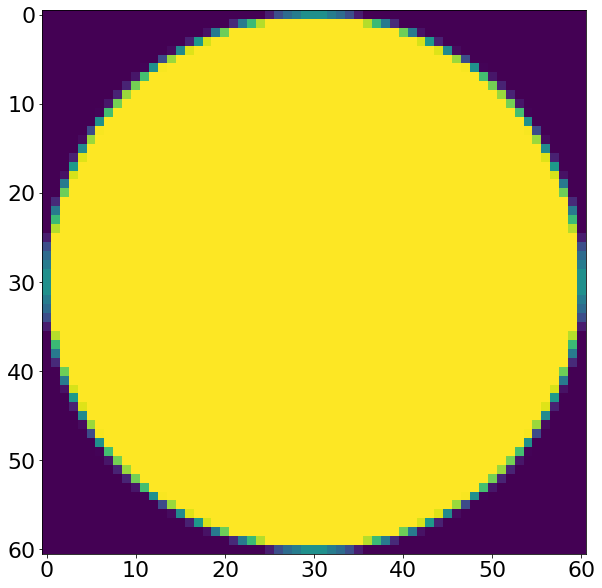

In [945]:
plt.imshow(fiber1)

In [902]:
optPsf_cut_pixel_response_convolved=scipy.signal.fftconvolve(fiber,pix_arr, mode = 'full')

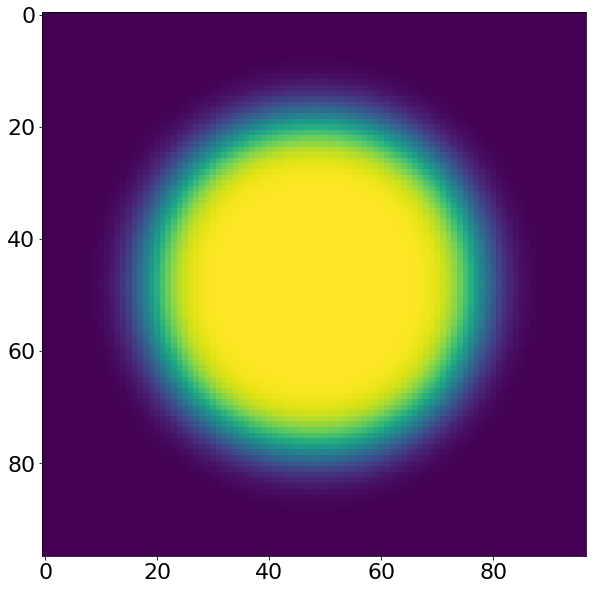

In [904]:
plt.imshow(optPsf_cut_pixel_response_convolved)

In [907]:
allparameters_proposal_test=np.copy(allparameters_proposal)
test_values=[0.4,0.45,0.5,0.55,0.6,0.65,0.7]
for i in range(len(test_values)):
    allparameters_proposal_test[-3]=test_values[i]
    model(allparameters_proposal_test)

17.687143998789512
-0.146179761588
17.687143998789512
-0.131650038821
17.687143998789512
-0.113330396235
17.687143998789512
-0.0913476192813
17.687143998789512
-0.0661475310064
17.687143998789512
-0.0380960340723
17.687143998789512
-0.00775699811908


In [948]:
allparameters_proposal_test=np.copy(allparameters_proposal)
test_values=[-0.4,-0.3,-0.2,-0.1,0.,0.1,0.2,0.3,0.4,0.5]
for i in range(len(test_values)):
    allparameters_proposal_test[0]=test_values[i]
    model(allparameters_proposal_test)

0.0146952135119
0.0089849830295
0.0124960829072
0.0169245316017
0.0172154733178
0.0178920243678
0.017261802385
0.0213735327353
0.0217638841285
0.02628580843


In [888]:
allparameters_proposal_test=np.copy(allparameters_proposal)
test_values=[-0.4,-0.3,-0.2,-0.1,0.,0.1,0.2,0.3,0.4,0.5]
for i in range(len(test_values)):
    allparameters_proposal_test[1]=test_values[i]
    model(allparameters_proposal_test)

-0.0038460535929
-0.00863868694069
-0.00497928068436
-0.00079217810896
-0.0027893100056
0.0016234045653
0.00658507128375
0.0121063329721
0.0182277812523
0.0173278313525


In [980]:
from multiprocessing import Pool

In [1058]:
#cosmohammer
import cosmoHammer
from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,add_pupil_parameters_to_all_parameters,PFSLikelihoodModule
lower_limits=np.array([z4Input-3,-1,-1,-1,-1,-1,-1,-1,
             0.5,0.05,-0.8,-0.8,0,-0.5,
             0,-0.5,-0.8,-0.8,
             0.8,-np.pi/2,0.5,0,0.85,-0.8,
             1200,1,0.5,0,
             0.2,1.65,0.9])

higher_limits=np.array([z4Input+3,1,1,1,1,1,1,1,
              1.2,0.2,0.8,0.8,0.2,0.5,
              3,20,0.8,0.8,
              1,np.pi/2,1.01,0.05,1.15,0.8,
               120000,50,3.5,0.5,
               1.1,1.95,1.1])



parInit1=create_parInit(allparameters_proposal,None,None)

chain = cosmoHammer.LikelihoodComputationChain()
chain.addLikelihoodModule(PFSLikelihoodModule(model))

pso = cosmoHammer.ParticleSwarmOptimizer(chain, low=lower_limits, high=higher_limits,particleCount=10)

for i in range(len(pso.swarm)):
    pso.swarm[i].position=parInit1[i+3]
    
nsteps=10  
swarms=[]
gbests=[]
num_iter = 0
for swarm in pso.sample(nsteps):
    swarms.append(pso.swarm)
    gbests.append(pso.gbest.copy())
    print(pso.gbest.position)
    num_iter += 1
    if pso.isMaster():
        if num_iter % 2 == 0:
            print("First swarm: "+str(100*num_iter/nsteps))
            sys.stdout.flush()

OSError: [Errno 24] Too many open files

In [1039]:
gbests[0].fitness

-1472.811358196187

In [1045]:
minchain=gbests[0].position
minln=gbests[-1].fitness
print(minchain)
print(minln)

[    -0.73416642     -0.36886866      0.60548174      0.81470331
      0.03240037     -0.14795637     -0.61418748     -0.17524493
      0.68123436      0.10648428      0.17745882     -0.06985896
      0.06713553      0.13311485      1.36141705      1.16950093
      0.16280274      0.03607157      0.83107071      0.10299992
      0.77222366      0.02155099      0.95547273      0.22444441
  65046.30143454     27.91727871      2.33095783      0.05179978
      0.44658928      1.70783386      1.00166101]
-1472.8113582


In [1051]:
pso.sample

<bound method ParticleSwarmOptimizer.sample of <cosmoHammer.pso.ParticleSwarmOptimizer.ParticleSwarmOptimizer object at 0x135297e80>>

In [1027]:
res=[]
for i in range(len(swarms)):
    for j in range(len(swarms[0])):
        res.append(swarms[i][j].position)
        
res=np.array(res)
chains=res.reshape(len(swarms),len(swarms[0]),len(lower_limits))


res=[]
for i in range(len(swarms)):
    for j in range(len(swarms[0])):
        res.append(swarms[i][j].fitness)
        
res=np.array(res)
ln_chains=res.reshape(len(swarms),len(swarms[0]))

minchain=chains[np.abs(ln_chains)==np.min(np.abs(ln_chains))][0]

In [1030]:
print('minchain atm: '+str(minchain))
print(np.min(np.abs(ln_chains)))

minchain atm: [    -1.93779166     -0.58722494      0.4656441       0.95137706
     -0.08231991      0.58091568     -0.62882207     -0.52563621
      0.64051127      0.10273481     -0.05441019      0.15706124
      0.06713553      0.12395275      1.40692073      0.88029566
      0.09211129      0.17576551      0.84564043      0.33390867
      0.72453744      0.0249196       0.85783832      0.10734409
  78500.22771979     27.10803842      2.95491408      0.05383029
      0.4347003       1.73084297      1.00448058]
1615.96644063


In [91]:
chains=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Sep26/chainSep26_Single_P_8603755Swarm1.npy')
ln_chains=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Sep26/likechainSep26_Single_P_8603755Swarm1.npy')

In [202]:
chains=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Sep26/chainSep26_Single_P_8603755Swarm2.npy')
ln_chains=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Sep26/likechainSep26_Single_P_8603755Swarm2.npy')
like_min_swarm2=[]
for i in range(ln_chains.shape[0]):
    like_min_swarm2.append(np.min(np.abs(ln_chains[i]))  )  

In [207]:
ln_chains[200]

array([-1664.9143501 , -1664.91458446, -1664.93573221, -1664.96816259,
       -1671.31438463, -1665.04702535, -1665.26593913, -1664.92462843,
       -1664.98413354, -1665.11691193, -1665.09387577, -1666.63784965,
       -1665.12089061, -1664.94613386, -1664.95347005, -1664.9602889 ,
                 -inf, -1665.03424284, -1665.01593124, -1665.67705572,
       -1664.94057415, -1665.82627291, -1764.6573868 , -1665.32881206,
       -1665.31250284, -1665.21993446, -1665.23056448, -1665.1735455 ,
                 -inf, -1665.22924246, -1665.08480658, -1665.23192511,
       -1665.36758194, -1665.34921061, -1665.05297859, -1671.42696375,
       -1665.14291516,           -inf, -1665.22175795, -1666.48270932,
       -1665.29514114, -1667.38581163,           -inf, -1665.10106066,
       -1665.58742806,           -inf, -1666.73242602, -1671.00922418,
       -1666.50029761, -1664.98364993,           -inf, -1671.51607829,
       -1664.9216603 , -1664.90269539,           -inf, -1665.24573547,
      

In [204]:
like_min_swarm2

[1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359422605,
 1664.8810359

In [172]:
chains=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Sep26/chainSep26_Single_P_8603755Emcee3.npy')
ln_chains=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Sep26/likechainSep26_Single_P_8603755Emcee3.npy')
like_min_Emcee3=[]
for i in range(ln_chains.shape[0]):
    like_min_Emcee3.append(np.min(np.abs(ln_chains[i]))  )  

In [173]:
len(like_min_Emcee3)

248

In [121]:
ln_chains[:,1]

array([-1664.90310314, -1731.95123724, -1747.26704984, -1858.36052331,
       -1737.39436101, -1734.46126546, -1764.79113048, -1769.78106024,
       -1748.90952872, -1779.61268369, -1748.388828  , -1752.3976062 ,
       -1748.21495631, -1735.88464065, -1732.39341139, -1733.57443984,
       -1735.66058807, -1746.55810373, -1733.81836555, -1732.7078545 ,
       -1740.31607051, -1733.36871567, -1768.15090433, -1721.64240592,
       -1747.97332733, -1734.35881576, -1737.62547432, -1754.82794503,
       -1918.0336195 , -1759.28665372, -1786.81770643, -1758.44076831,
       -1771.95867127, -1740.56780981, -1785.54571471, -1859.5846801 ,
       -1788.02570871, -1757.93411098, -1764.50385792, -1764.92726155,
       -1742.46422223, -1739.47491458, -1733.59729924, -1746.34624247,
       -1736.70975385, -1795.55077343, -1722.27415084, -1743.87096693,
       -1743.21143133, -1757.403926  , -1736.26483679, -1753.26836973,
       -1834.40532272, -1737.50387617, -1744.79012886, -1750.78271777,
      

(array([  4.,   8.,  19.,  41.,  76.,  57.,  31.,   8.,   1.,   3.]),
 array([-1.01405278, -1.01340104, -1.01274931, -1.01209758, -1.01144584,
        -1.01079411, -1.01014238, -1.00949064, -1.00883891, -1.00818718,
        -1.00753544]),
 <a list of 10 Patch objects>)

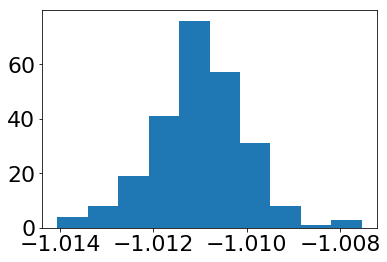

In [108]:
plt.hist(chains[:,0][0:,1])

In [564]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Images/Sep19/' + 'results_of_fit_many_interpolation.pkl', 'rb') as f:
    results_of_fit_many_interpolation=pickle.load(f)

allparameters_proposal=results_of_fit_many_interpolation[labelInput].loc[int(single_number)].values[:len(columns)]
#allparameters_proposal[0]=0

In [635]:
23*9

207

In [648]:
obs='8621'
single_number='75'
image_index=int(single_number)
eps=5
date='Sep26'

obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')
    
    
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1)   

    
    
    
#model(minchain)
model(allparameters_proposal)




-3270541.3945659334

In [618]:
obs='8555'
single_number='75'
image_index=int(single_number)
eps=5
date='Sep26'

obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')
    
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   

    
model(allparameters_proposal)

optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated258555=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum8555=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum8555=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
r8555=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy') 


optPsf258555=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPSF258555_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_downsampled258555=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved258555=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
optPsf_cut_grating_convolved258555=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
wf_grid8555=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
expwf_grid8555=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy') 
optPsf_downsampled_scattered258555=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved258555=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved258555=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved258555=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled258555=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus258555=optPsf_cut_fiber_convolved_downsampled258555   

Supplied pupil size is (pupil.size) [m]:0.1395327
pupil.scale: 0.0001049118045112782
pupil.illuminated.astype(np.float32).shape: (1330, 1330)


In [619]:
aper = galsim.Aperture(
    diam =  0.1395327,
    pupil_plane_im = pupililluminated258555,
    pupil_plane_scale = 0.0001049118045112782,
    pupil_plane_size = None)     

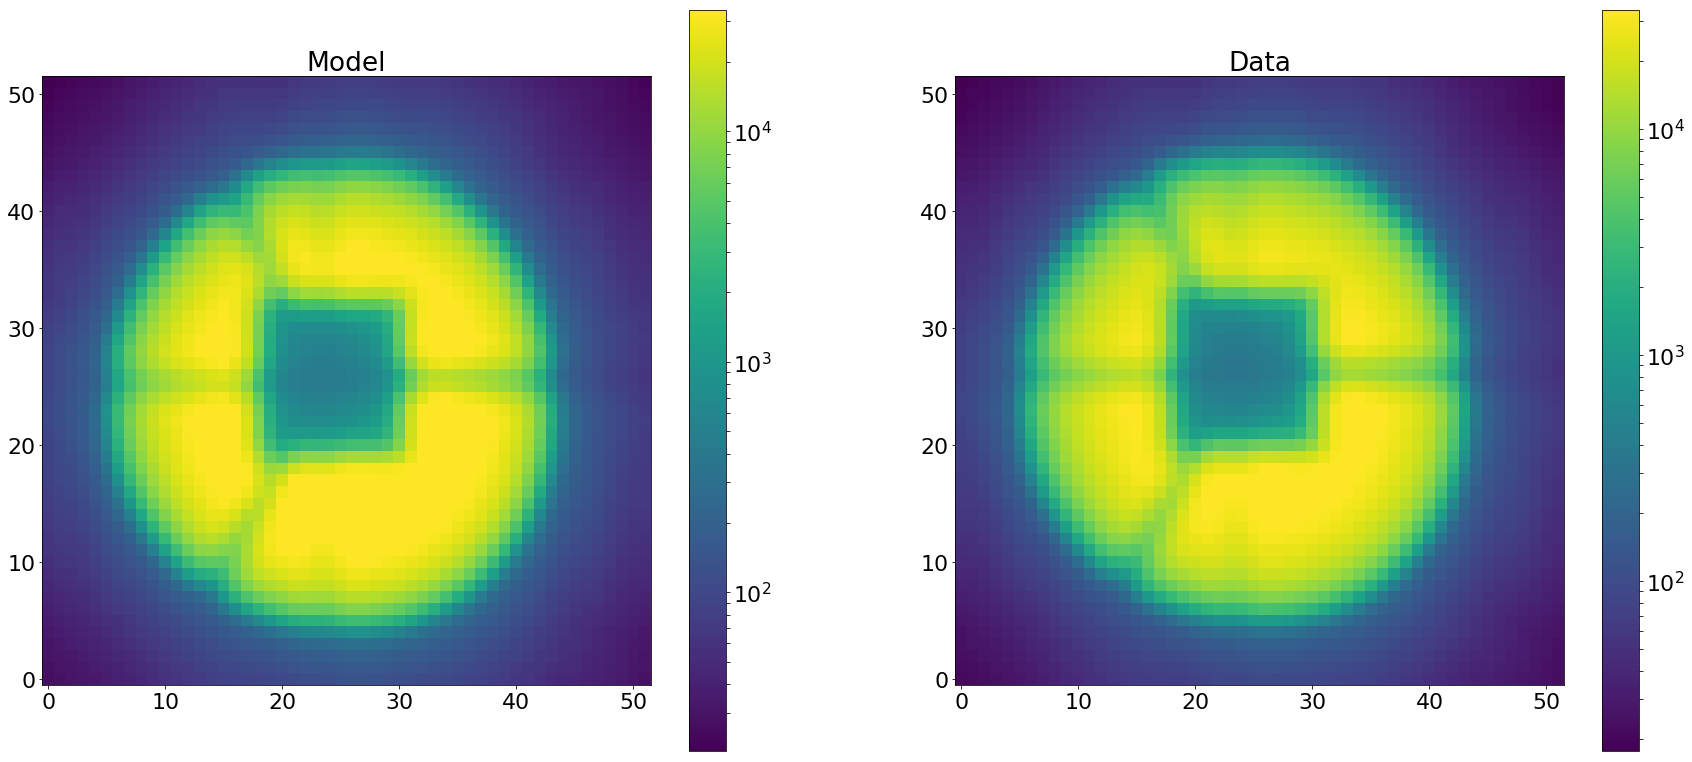

In [616]:
plt.figure(figsize=(30,30))
plt.subplot(221)
plt.imshow(res_iapetus258552[4:56,4:56],origin='lower',vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(res_iapetus258555,origin='lower',vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)

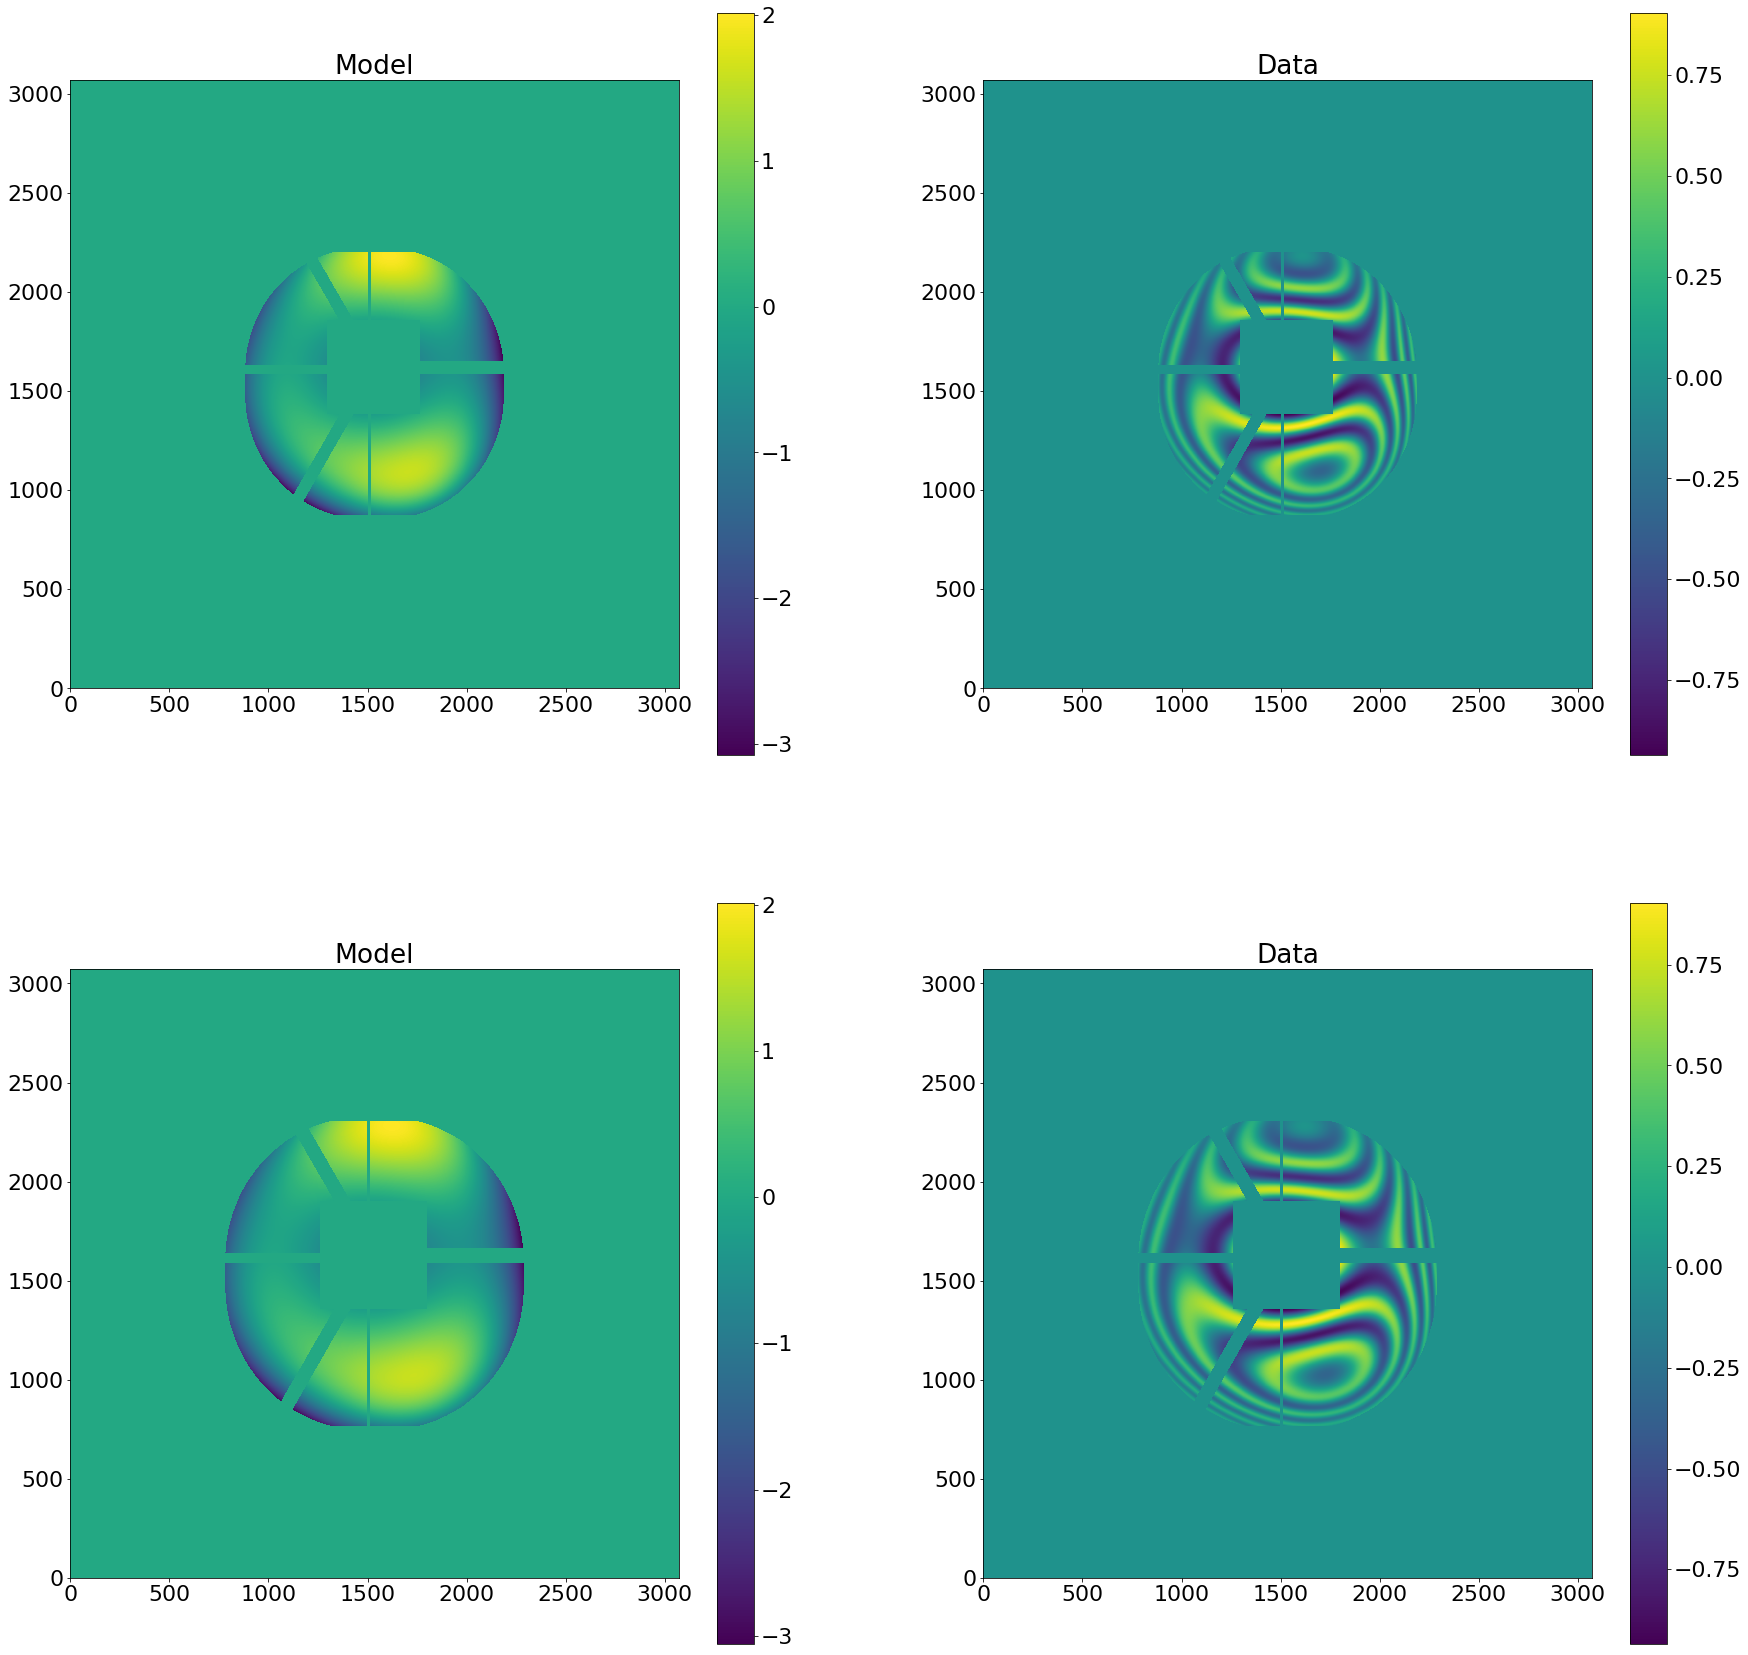

In [540]:
plt.figure(figsize=(30,30))
plt.subplot(221)
plt.imshow(wf_grid8555,origin='lower')
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(np.imag(expwf_grid8555),origin='lower')
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(wf_grid8552,origin='lower')
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(224)
plt.imshow(np.imag(expwf_grid8552),origin='lower')
plt.colorbar()
plt.title('Data')
plt.grid(False)

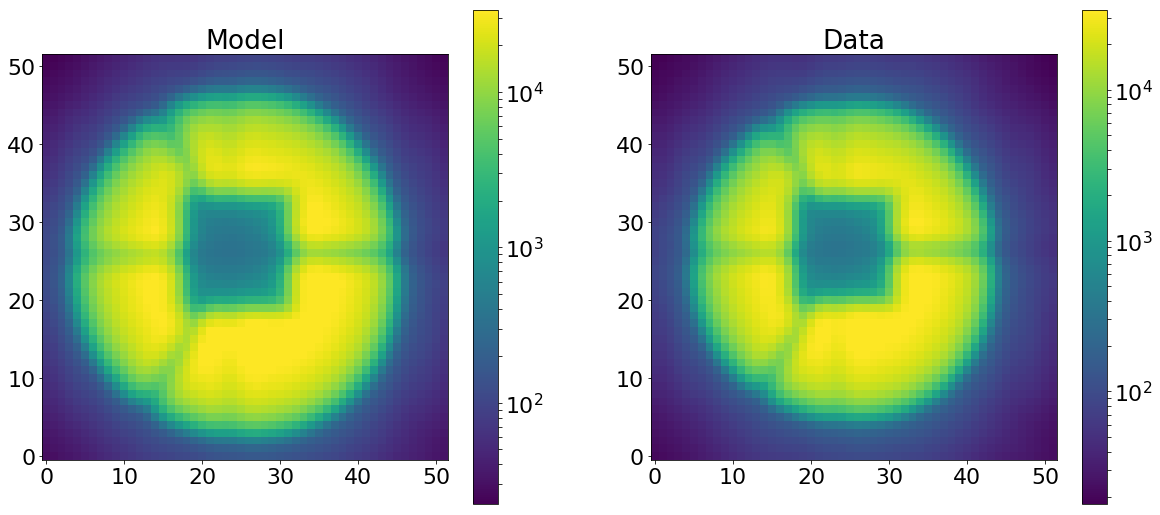

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(sci_image_8552[4:56,4:56],origin='lower',vmax=np.max(np.abs(sci_image)))
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image_8555,origin='lower',vmax=np.max(np.abs(sci_image)))
plt.colorbar()
plt.title('Data')
plt.grid(False)

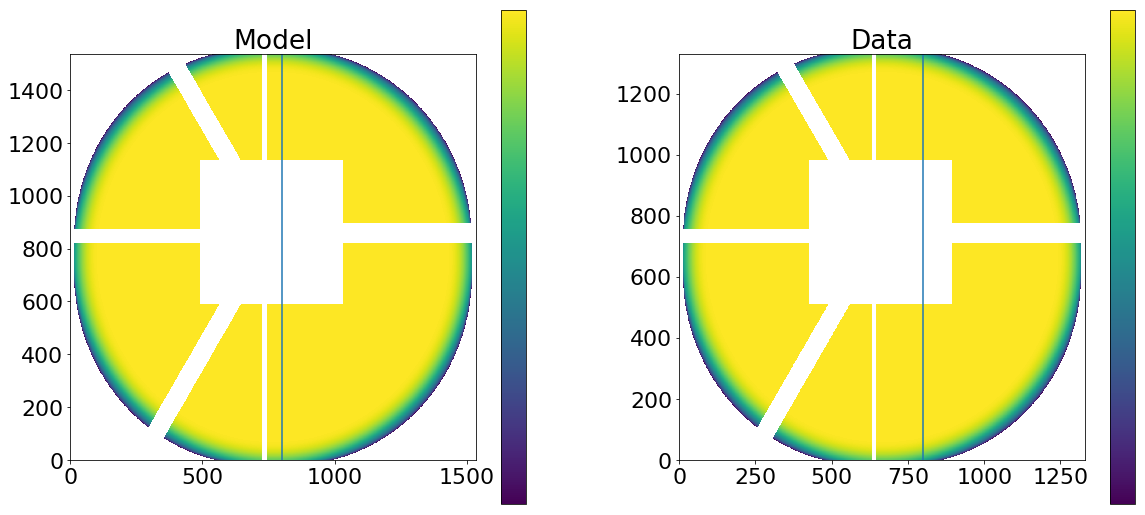

In [370]:
pupililluminated258555
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(np.real(pupililluminated258552),origin='lower',vmax=np.max(1),norm=LogNorm())
plt.axvline(800)
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.axvline(800)
plt.imshow(np.real(pupililluminated258555),origin='lower',vmax=np.max(1),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)

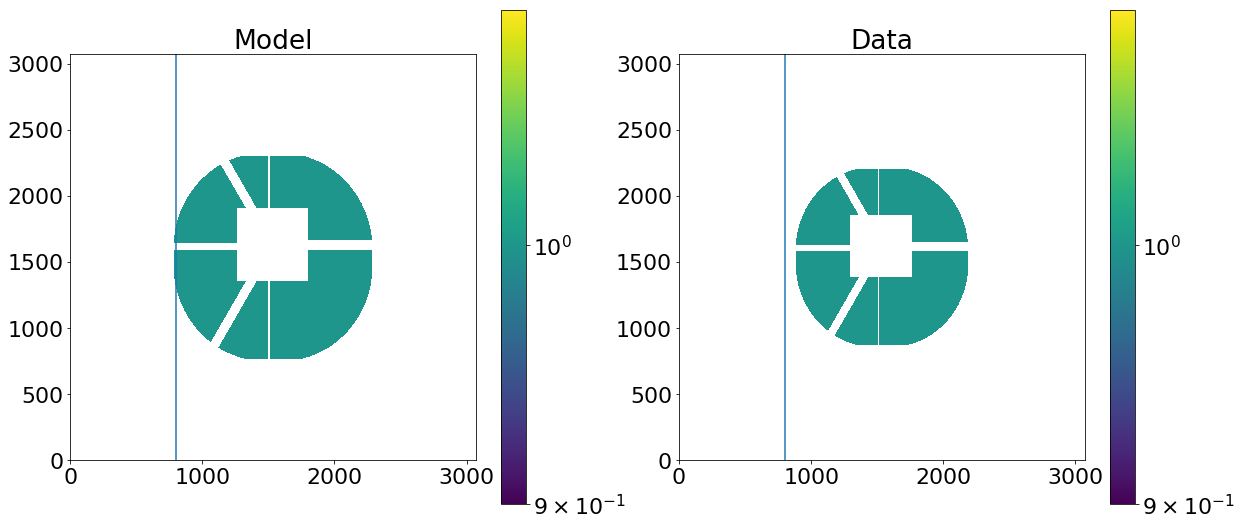

In [387]:
pupililluminated258555
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(np.real(ilum8552),origin='lower',vmax=np.max(1),norm=LogNorm())
plt.axvline(800)
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.axvline(800)
plt.imshow(np.real(ilum8555),origin='lower',vmax=np.max(1),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)

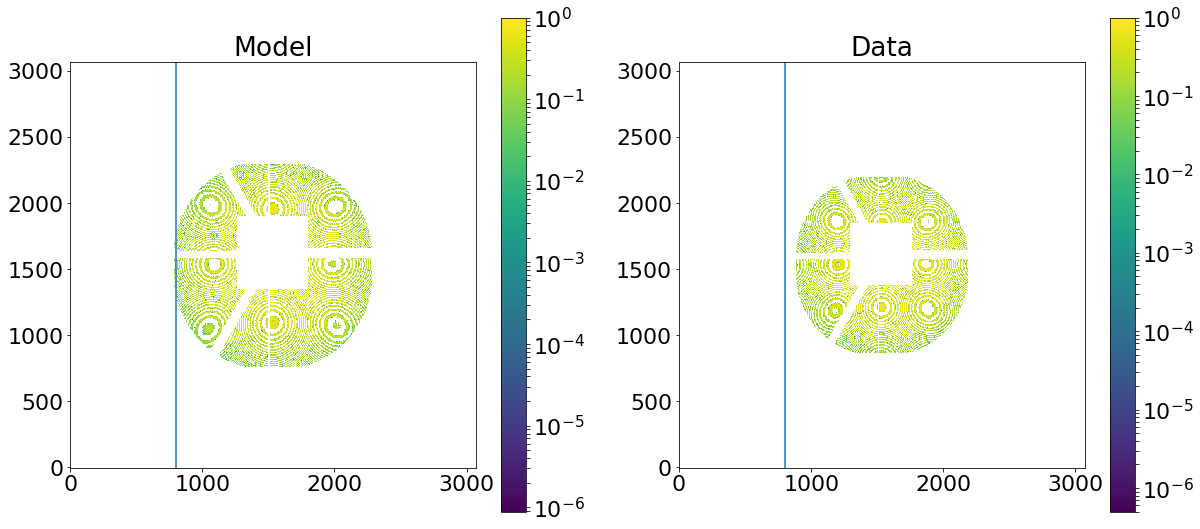

In [399]:
pupililluminated258555
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(np.real(expwf_grid8552),origin='lower',vmax=np.max(1),norm=LogNorm())
plt.axvline(800)
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.axvline(800)
plt.imshow(np.real(expwf_grid8555),origin='lower',vmax=np.max(1),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)

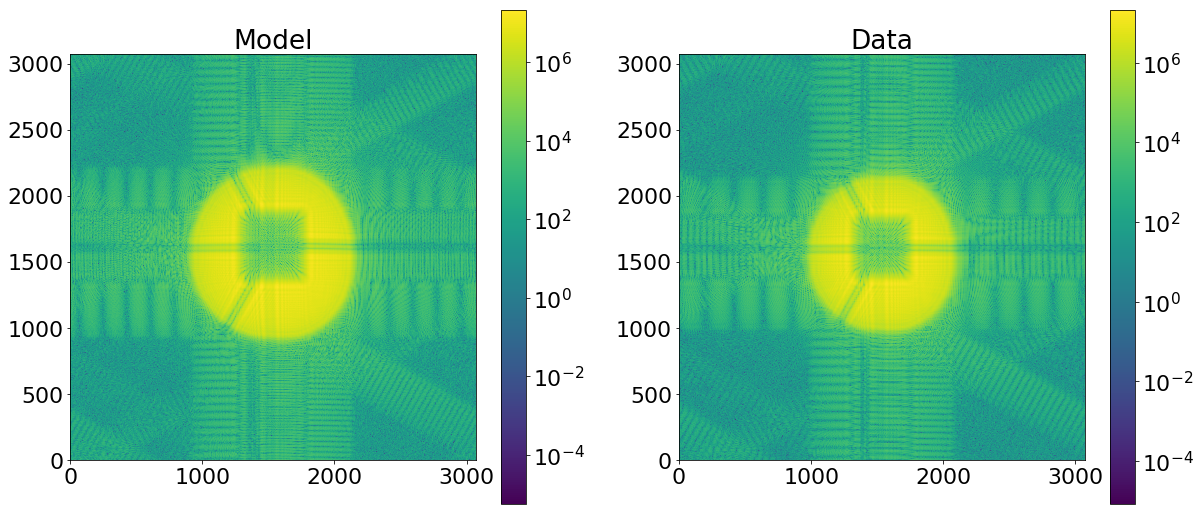

In [357]:
pupililluminated258555
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(optPsf258552,origin='lower',vmax=np.max(optPsf258555),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(optPsf258555,origin='lower',vmax=np.max(optPsf258555),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)

In [617]:
aper

NameError: name 'aper' is not defined

chi**2 reduced is: 2628.79429624
Abs of residual divided by total flux is: 0.334285467926
Abs of residual divided by largest value of a flux in the image is: 0.594252541111


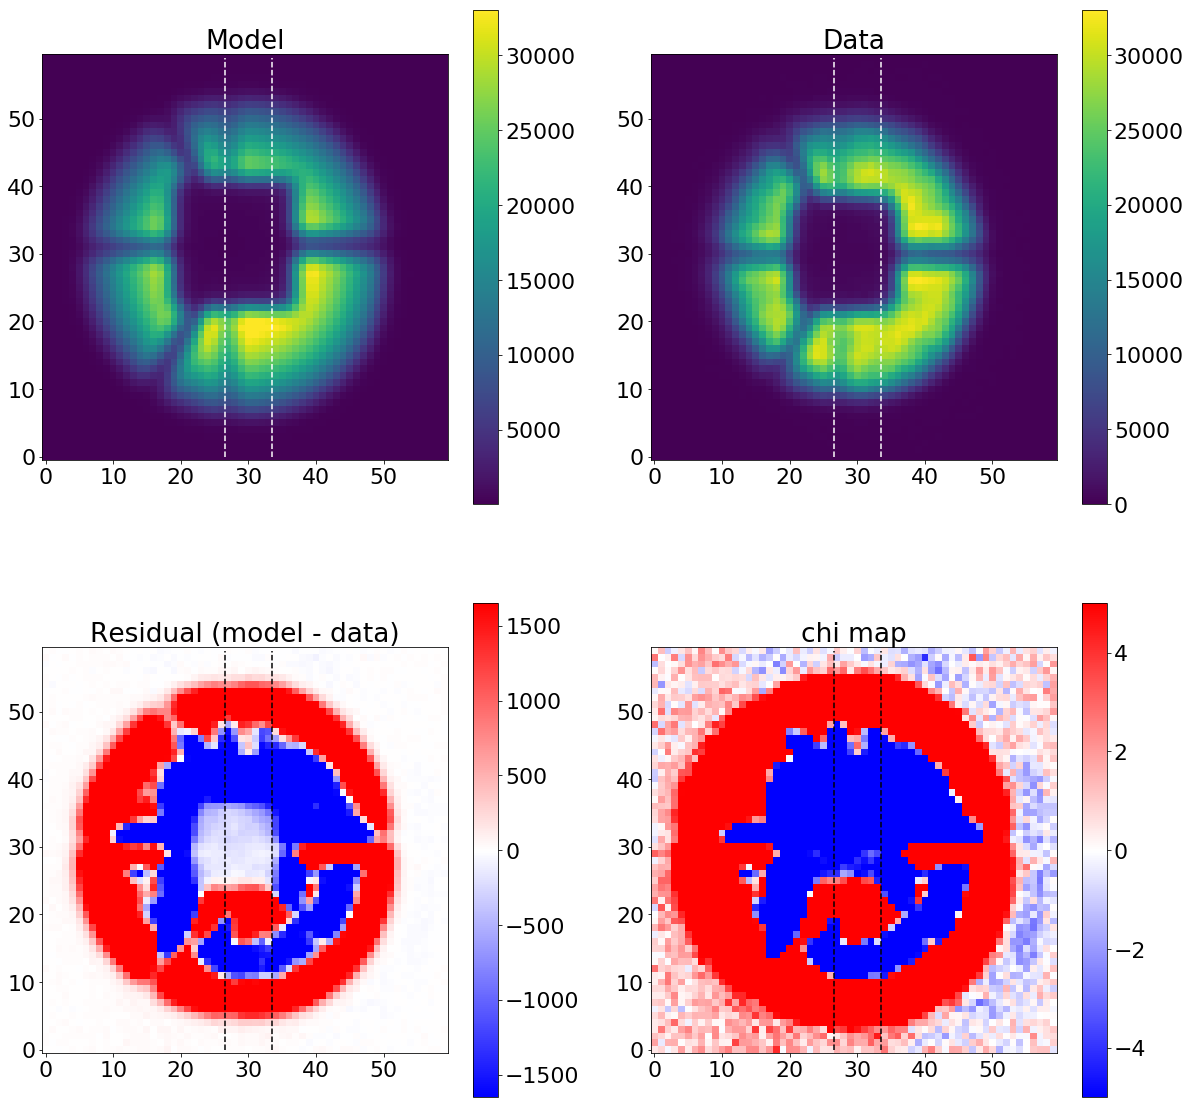

In [258]:
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled
sci_image=sci_image
var_image=var_image
size=sci_image.shape[0]
if size==40:
    dithering=2
else:
    dithering=1

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmax=np.max(np.abs(sci_image)))
plt.plot(np.ones(len(sci_image))*(size/2-3.5),np.array(range(len(sci_image))),'--',color='white')
plt.plot(np.ones(len(sci_image))*((size/2-dithering*3.5)+7*dithering),np.array(range(len(sci_image))),'--',color='white')
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmax=np.max(np.abs(sci_image)))
plt.plot(np.ones(len(sci_image))*(size/2-3.5),np.array(range(len(sci_image))),'--',color='white')
plt.plot(np.ones(len(sci_image))*((size/2-dithering*3.5)+7*dithering),np.array(range(len(sci_image))),'--',color='white')
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(res_iapetus-sci_image,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image))/20,vmax=np.max(np.abs(sci_image))/20)
plt.plot(np.ones(len(sci_image))*(size/2-3.5),np.array(range(len(sci_image))),'--',color='black')
plt.plot(np.ones(len(sci_image))*((size/2-dithering*3.5)+7*dithering),np.array(range(len(sci_image))),'--',color='black')
plt.colorbar()
plt.title('Residual (model - data)')
plt.grid(False)
plt.subplot(224)
#plt.imshow((res_iapetus-sci_image)/np.sqrt(var_image),origin='lower',cmap='bwr',vmax=np.max(np.abs((res_iapetus-sci_image)/np.sqrt(var_image))),vmin=-np.max(np.abs((res_iapetus-sci_image)/np.sqrt(var_image))))
plt.imshow((res_iapetus-sci_image)/np.sqrt(var_image),origin='lower',cmap='bwr',vmax=5,vmin=-5)

plt.plot(np.ones(len(sci_image))*(size/2-3.5),np.array(range(len(sci_image))),'--',color='black')
plt.plot(np.ones(len(sci_image))*((size/2-dithering*3.5)+7*dithering),np.array(range(len(sci_image))),'--',color='black')
plt.colorbar()
plt.title('chi map')
print('chi**2 reduced is: '+str(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image))))
print('Abs of residual divided by total flux is: '+str(np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))))
print('Abs of residual divided by largest value of a flux in the image is: '+str(np.max(np.abs((res_iapetus-sci_image)/np.max(res_iapetus)))))

# Analysis multi

## weight factors

In [3098]:
single_defocus_list=[8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627]    

res=[]
for obs in single_defocus_list:
    

    if obs==8600:
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
    else:       
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')

    
    res.append(len(sci_image))
    
res=np.array(res)

In [3099]:
weights=1/(res/10)
weights[single_defocus_list.index(8603)]=weights[single_defocus_list.index(8603)]*2
weights=weights/np.sum(weights)*len(weights)

In [3100]:
weights

array([ 0.47767288,  0.55116101,  0.71650931,  0.89563664,  0.95534575,
        1.19418219,  1.43301863,  1.43301863,  2.86603725,  0.71650931,
        1.43301863,  1.19418219,  0.95534575,  0.95534575,  0.71650931,
        0.55116101,  0.47767288,  0.47767288])

## scripts

### 999

In [1882]:
for single_spot in [999]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/P'+str(1)+'S'+str(single_spot)+'Sep_P.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    file.write("python /home/ncaplar/Code/ZernikeMulti_Sep.py "+'8552,8561,8573,8603,8606,8618,8627'+" "+str(single_spot)+" 100 1\n")
    file.close()     

In [1883]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for obs in [1]:
    for single_spot in [5,25,35,45,55,75,85,95,56,57,58,59,54,52,51,50]:
        file.write('sbatch /home/ncaplar/Scripts/P'+str(1)+'S'+str(single_spot)+'Sep_P.sh \n')

        
file.close()

### Sep 19

In [2436]:
for eps in [1,2,3,4,5,6]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(eps)+'S'+str(single_spot)+'Sep_P.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    file.write("python /home/ncaplar/Code/ZernikeMulti_Sep.py "+'8552,8561,8573,8603,8606,8618,8627'+" "+str(single_spot)+" 40 "+str(eps)+"\n")
    file.close()   
   

In [2437]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for eps in [1,2,3,4,5,6]:
    for single_spot in [999]:
        file.write('sbatch /home/ncaplar/Scripts/T'+str(eps)+'S'+str(single_spot)+'Sep_P.sh \n')

        
file.close()

### Sep20

In [2811]:
single_spot=999
for eps in [2,3,4,5,6,7,8,9,10]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(eps)+'S'+str(single_spot)+'Sep_P.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=2 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 0:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+'8558'+" "+str(single_spot)+" 50 "+str(eps)+"\n")
    file.close()

In [2802]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for eps in [2,3,4,5,6,7,8,9]:
    for single_spot in [999]:
        file.write('sbatch /home/ncaplar/Scripts/T'+str(eps)+'S'+str(single_spot)+'Sep_P.sh \n')

        
file.close()

In [2807]:
single_spot=999
for eps in [1]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(eps)+'S'+str(single_spot)+'Sep_P_MPI2.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=2 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 5:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+'8558'+" "+str(single_spot)+" 100 "+str(eps)+"\n")
    file.close()

In [2808]:
single_spot=999
for eps in [1]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(eps)+'S'+str(single_spot)+'Sep_P_MPI4.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 5:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+'8558'+" "+str(single_spot)+" 100 "+str(eps)+"\n")
    file.close()

In [2809]:
single_spot=999
for eps in [1]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(eps)+'S'+str(single_spot)+'Sep_P_MPI8.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=8 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 5:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI.py "+'8558'+" "+str(single_spot)+" 100 "+str(eps)+"\n")
    file.close()

In [2810]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for eps in [1]:
    for single_spot in [999]:
        file.write('sbatch /home/ncaplar/Scripts/T'+str(eps)+'S'+str(single_spot)+'Sep_P_MPI2.sh \n')
        file.write('sbatch /home/ncaplar/Scripts/T'+str(eps)+'S'+str(single_spot)+'Sep_P_MPI4.sh \n')
        file.write('sbatch /home/ncaplar/Scripts/T'+str(eps)+'S'+str(single_spot)+'Sep_P_MPI8.sh \n')

        
file.close()

### Test with 55

In [3107]:
single_spot=55
for eps in [5]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(eps)+'S'+str(single_spot)+'Sep_P_MPI8.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=8 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    file.write("mpirun python /home/ncaplar/Code/ZernikeMulti_Sep.py "+'8552,8558,8573,8603,8606,8621,8627'+" "+str(single_spot)+" 100 "+str(eps)+"\n")
    file.close()

In [3108]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for eps in [5]:
    for single_spot in [55]:
        file.write('sbatch /home/ncaplar/Scripts/T'+str(eps)+'S'+str(single_spot)+'Sep_P_MPI8.sh \n')

        
file.close()

## core

In [214]:
columns_multi=['z4a','z4b','z5a','z5b','z6','z6b','z7a','z7b','z8a','z8b','z9a','z9b','z10a','z10b','z11a','z11b',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
                      'minorAxis','pupilAngle','effective_radius_illumination',
                      'frd_sigma','det_vert','slitHolder_frac_dx',
                      'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
                      'pixel_effect','fiber_r','flux']  

columns_single=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent', 'x_ilum','y_ilum',
         'minorAxis','pupilAngle','effective_ilum_radiusInit','frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux'] 

In [215]:
columns_analysis=columns_single+['chi2','chi2max']

results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0.0','0.0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0'],columns=columns_analysis)
err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0.0','0.0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0'],columns=columns_analysis)

In [225]:
single_defocus_list=[8552,8555,8558,8561,8564,8567,8570,8573,8600,8603,8606,8609,8612,8615,8618,8621,8624,8627]
defocus_possibilites=np.array([-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0,0.5,1,1.5,2,2.5,3,3.5,4])
"""                          
minchain=np.array([     -8.25879094,     -0.33337701  ,   -0.99477364   ,  -0.11268186,
      0.11131805  ,   -0.61204972 ,     0.18359353,     -0.14847461,
      0.54591314 ,    -0.22926357 ,    -0.2532553 ,      0.2677665,
     -0.64783966 ,     0.24230453,      0.16822247,     -0.30494179,
      0.53706889 ,     0.13895487,     -0.71497617,     -0.3208953,
      0.08796459 ,     0.4068707 ,      0.12746871,     13.97103215,
     -0.05431669 ,     0.73278415,      0.9553491 ,      0.2877631,
      0.63800328 ,     0.02450602,      1.03800943,0.44952327,
 113616.03411672 ,    15.43600832,      2.43713231 ,     0.07982728,
      0.46133298 ,     1.73097684 ,     0.98591751])
""" 
minchain=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Sep19/chainSep19_Multi_P_8627555Emcee3.npy")[0][0]
minchain

array([    -7.45366831,     -1.25047483,      0.01862159,     -0.19248796,
            0.17392151,     -0.2580868 ,      0.06911504,      0.18055192,
           -0.02515285,     -0.1549945 ,     -0.01898421,     -0.15340938,
            0.00234427,     -0.24088743,      0.31393281,     -0.02172852,
            0.60634451,      0.05608081,     -0.02404247,     -0.02870407,
            0.0532578 ,     -0.01151219,      0.77044824,      2.0287096 ,
            0.0331451 ,     -0.04080671,      0.91575505,      0.28199072,
            0.9438821 ,      0.02950941,      1.01972779,     -0.05820181,
        53194.34453671,      1.20964588,      1.85343456,      0.18768816,
            0.3434896 ,      1.66855868,      0.95000046])

In [226]:
date='Sep19'
single_number=55
image_index=single_number
multi_analysis=Zernike_Analysis(date,obs,single_number,eps)
#minchain,like_min=multi_analysis.create_likelihood_multi()


In [227]:
for i in tqdm(range(len(single_defocus_list))):

    single_res=create_x(float(results_of_fit_single.index.values[i]),minchain)
    print(single_res)
    obs=single_defocus_list[i]

    if str(obs)=='8600':
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
    else:       
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')

    if str(obs)=='8600':
        model = LN_PFS_single(sci_image,var_image,dithering=2)
    else:
        model = LN_PFS_single(sci_image,var_image,dithering=1)  

    chi2_max=np.mean(sci_image**2/var_image)
    chi2=model(allparameters_proposal)*(-2)/(sci_image.shape[0])**2

    single_res_with_chi=np.concatenate((single_res,np.array([chi2,chi2_max])),axis=0)

    results_of_fit_single.iloc[i]=single_res_with_chi
    err_results_of_fit_single.iloc[i]=single_res_with_chi/10




  0%|                                                                  | 0/18 [00:00<?, ?it/s]

[    28.56419841     -0.26697431     -0.95377283     -0.09590823
     -0.05438311     -0.07747256     -0.25026452     -1.27745977
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





  6%|███▏                                                      | 1/18 [00:04<01:22,  4.83s/it]

[    24.83736426     -0.25766352     -0.86681208     -0.06135071
     -0.06695953     -0.08696466     -0.24909239     -1.12049337
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 11%|██████▍                                                   | 2/18 [00:09<01:12,  4.52s/it]

[    21.1105301      -0.24835273     -0.77985132     -0.02679319
     -0.07953596     -0.09645677     -0.24792025     -0.96352696
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 17%|█████████▋                                                | 3/18 [00:10<00:54,  3.64s/it]

[    17.38369595     -0.23904193     -0.69289057      0.00776433
     -0.09211238     -0.10594887     -0.24674811     -0.80656055
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 22%|████████████▉                                             | 4/18 [00:12<00:43,  3.13s/it]

[    13.65686179     -0.22973114     -0.60592981      0.04232185
     -0.1046888      -0.11544097     -0.24557598     -0.64959414
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 28%|████████████████                                          | 5/18 [00:13<00:35,  2.71s/it]

[     9.93002764     -0.22042034     -0.51896906      0.07687936
     -0.11726523     -0.12493307     -0.24440384     -0.49262774
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 33%|███████████████████▎                                      | 6/18 [00:14<00:29,  2.43s/it]

[     6.20319348     -0.21110955     -0.4320083       0.11143688
     -0.12984165     -0.13442518     -0.24323171     -0.33566133
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 39%|██████████████████████▌                                   | 7/18 [00:15<00:23,  2.15s/it]

[     2.47635933     -0.20179875     -0.34504755      0.1459944
     -0.14241807     -0.14391728     -0.24205957     -0.17869492
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 44%|█████████████████████████▊                                | 8/18 [00:15<00:19,  1.94s/it]

[    -1.25047483     -0.19248796     -0.2580868       0.18055192
     -0.1549945      -0.15340938     -0.24088743     -0.02172852
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 50%|█████████████████████████████                             | 9/18 [00:15<00:15,  1.78s/it]

[    -1.25047483     -0.19248796     -0.2580868       0.18055192
     -0.1549945      -0.15340938     -0.24088743     -0.02172852
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 56%|███████████████████████████████▋                         | 10/18 [00:16<00:13,  1.65s/it]

[    -4.97730898     -0.18317716     -0.17112604      0.21510944
     -0.16757092     -0.16290149     -0.2397153       0.13523789
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 61%|██████████████████████████████████▊                      | 11/18 [00:16<00:10,  1.54s/it]

[    -8.70414314     -0.17386637     -0.08416529      0.24966696
     -0.18014734     -0.17239359     -0.23854316      0.2922043
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 67%|██████████████████████████████████████                   | 12/18 [00:17<00:08,  1.50s/it]

[   -12.43097729     -0.16455557      0.00279547      0.28422448
     -0.19272377     -0.18188569     -0.23737102      0.4491707
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 72%|█████████████████████████████████████████▏               | 13/18 [00:19<00:07,  1.47s/it]

[   -16.15781145     -0.15524478      0.08975622      0.318782
     -0.20530019     -0.1913778      -0.23619889      0.60613711
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 78%|████████████████████████████████████████████▎            | 14/18 [00:20<00:05,  1.44s/it]

[   -19.8846456      -0.14593398      0.17671698      0.35333952
     -0.21787661     -0.2008699      -0.23502675      0.76310352
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 83%|███████████████████████████████████████████████▌         | 15/18 [00:22<00:04,  1.47s/it]

[   -23.61147976     -0.13662319      0.26367773      0.38789704
     -0.23045304     -0.210362       -0.23385461      0.92006992
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 89%|██████████████████████████████████████████████████▋      | 16/18 [00:26<00:03,  1.64s/it]

[   -27.33831391     -0.12731239      0.35063848      0.42245456
     -0.24302946     -0.21985411     -0.23268248      1.07703633
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





 94%|█████████████████████████████████████████████████████▊   | 17/18 [00:31<00:01,  1.84s/it]

[   -31.06514807     -0.1180016       0.43759924      0.45701208
     -0.25560588     -0.22934621     -0.23151034      1.23400274
      0.60634451      0.05608081     -0.02404247     -0.02870407
      0.0532578      -0.01151219      0.77044824      2.0287096
      0.0331451      -0.04080671      0.91575505      0.28199072
      0.9438821       0.02950941      1.01972779     -0.05820181
  53194.34453671      1.20964588      1.85343456      0.18768816
      0.3434896       1.66855868      0.95000046]





100%|█████████████████████████████████████████████████████████| 18/18 [00:36<00:00,  2.00s/it]




In [228]:
results_of_fit_single_full=np.copy(results_of_fit_single)
err_results_of_fit_single_full=np.copy(results_of_fit_single)

results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]

results_of_fit_single_without_focus=results_of_fit_single.copy()
err_results_of_fit_single_without_focus=err_results_of_fit_single.copy()
results_of_fit_single_without_focus=results_of_fit_single_without_focus[results_of_fit_single_without_focus.index.values!='0']
err_results_of_fit_single_without_focus=err_results_of_fit_single_without_focus[err_results_of_fit_single_without_focus.index.values!='0']

results_of_fit_single_only_focus=results_of_fit_single.copy()
err_results_of_fit_single_only_focus=err_results_of_fit_single.copy()
results_of_fit_single_only_focus=results_of_fit_single_only_focus[results_of_fit_single_only_focus.index.values=='0']
err_results_of_fit_single_only_focus=err_results_of_fit_single[err_results_of_fit_single_only_focus.index.values=='0']

In [229]:
index_arr=np.array(results_of_fit_single.index.values).astype(float)

q='z8'
z4_arr=np.array(results_of_fit_single[q])
z4_arr_err=np.array(err_results_of_fit_single[q])
#z4_arr_err=np.array(results_of_fit_single[q])/10
popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)

In [230]:
fit_res=[]
for i in np.linspace(-4.5,4.5,19):
    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))

In [231]:

IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

solution_at_0=[]
for q in columns_analysis:
    z4_arr=np.array(results_of_fit_single[q])
    z4_arr_err=np.array(err_results_of_fit_single[q])
    
    z4_arr_no0=np.array(results_of_fit_single_without_focus[q])
    z4_arr_no0_err=np.array(err_results_of_fit_single_without_focus[q])
    
    z4_arr_only0=np.array(results_of_fit_single_only_focus[q])
    z4_arr_only0_err=np.array(err_results_of_fit_single_only_focus[q])
  
    
    
    #popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)
    
    #index_arr=np.array(results_of_fit_single.index.values)
    #index_arr=np.array(map(float,index_arr))
    index_arr_plot=np.copy(index_arr)
    #index_arr_plot[5]=index_arr_plot[5]+0.01
    
    index_arr_no0=np.array(results_of_fit_single_without_focus.index).astype(float)

    if len(results_of_fit_single_only_focus.index)>10:
        index_arr_only0=np.array([0])
    else:
        index_arr_only0=np.array(results_of_fit_single_only_focus.index).astype(float)       
    

     
    
    fit_res=[]
    if q in columns[:8]:
        popt, pcov = curve_fit(lin_fit_1D, index_arr_no0, z4_arr_no0, sigma=z4_arr_no0_err)
        for i in np.linspace(-4.5,4.5,19):
            fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
        solution_at_0.append(fit_res[9])
    if q in np.concatenate((np.array(columns[8:21]),np.array(['pixel_effect'])),axis=0):
        popt, pcov = curve_fit(lin_fit_1DConstant, index_arr_no0, z4_arr_no0, sigma=z4_arr_no0_err)
        for i in np.linspace(-4.5,4.5,19):
            fit_res.append(lin_fit_1DConstant(i,popt[0]))
        solution_at_0.append(fit_res[9])
    if q in np.array(['grating_lines','scattering_radius', 'scattering_slope', 'scattering_amplitude','fiber_r','flux','chi2','chi2max']):
        if z4_arr_only0.size==1:
            for i in np.linspace(-4.5,4.5,19):
                fit_res.append(z4_arr_only0) 
            solution_at_0.append(fit_res[9])
        else:
            popt, pcov = curve_fit(lin_fit_1DConstant, index_arr_only0, z4_arr_only0, sigma=z4_arr_only0_err)
            for i in np.linspace(-4.5,4.5,19):
                fit_res.append(lin_fit_1DConstant(i,popt[0]))    
            solution_at_0.append(fit_res[9])
            

    #solution_at_0.append(fit_res[5])
    plt.figure(figsize=(20,10))
    plt.errorbar(index_arr_plot,z4_arr,yerr=z4_arr_err,color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
    #plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
    plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),'--',color='black')
    #plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red")
    plt.title(q,size=40)
    plt.legend(fontsize=25)
    plt.xlabel('defocus lab [mm]',size=30)
    plt.ylabel('defocus model',size=30)
    
    if not os.path.exists(IMAGES_FOLDER+'Defocus/'):
        os.makedirs(IMAGES_FOLDER+'Defocus/')
    plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q))
    plt.close()
    
solution_at_0=np.array(solution_at_0)

TypeError: Improper input: N=1 must not exceed M=0

## at single point

In [232]:
obs=8603
obs_int_array=np.array(obs)
obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
sorter = np.argsort(obs_possibilites)
defocus_array=defocus_possibilites[sorter[np.searchsorted(obs_possibilites, obs_int_array, sorter=sorter)]]


if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

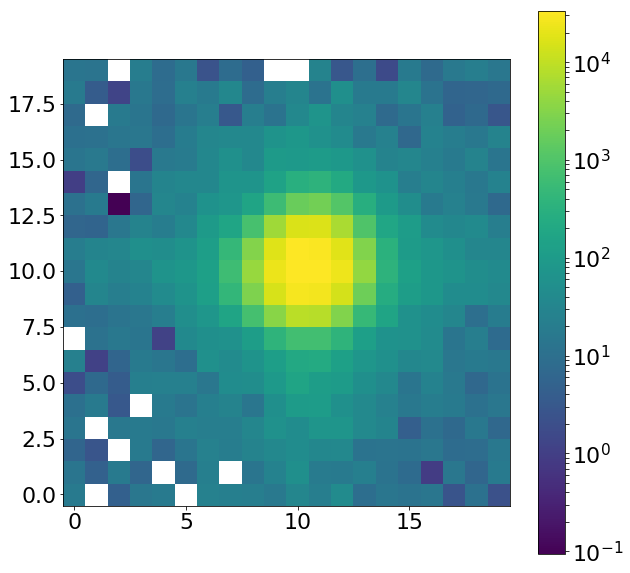

In [233]:
plt.figure(figsize=(10,10))
plt.imshow(sci_image,norm=LogNorm(),origin='lower')
plt.colorbar()

NameError: name 'like_min' is not defined

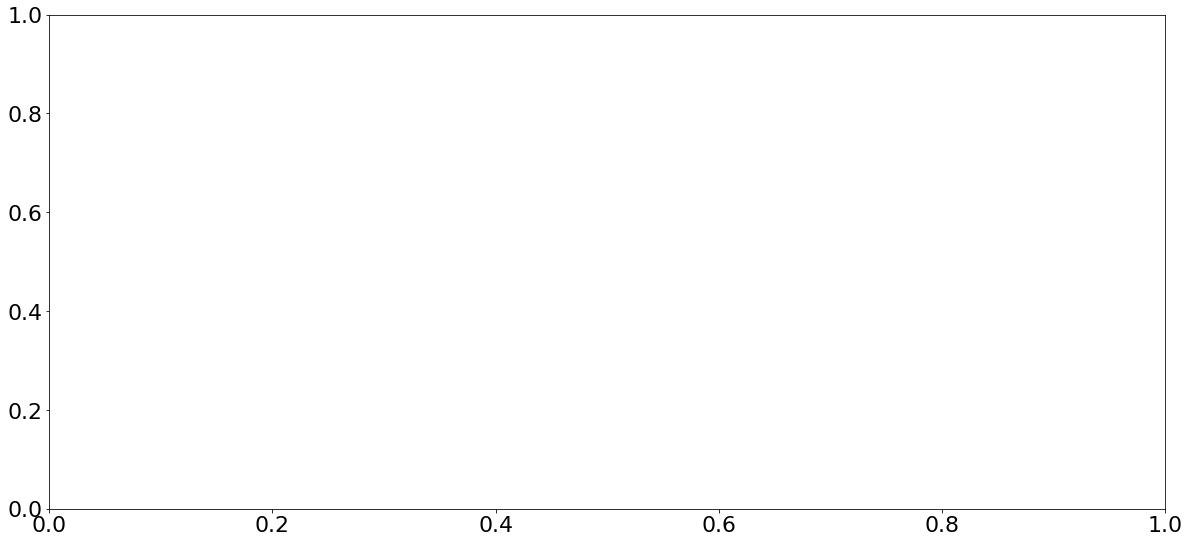

In [234]:
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(0,len(like_min),len(like_min)),like_min,'blue',ls='-')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.subplot(212)
plt.plot(np.linspace(0,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')

In [235]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps)
minchain=results_of_fit_single[results_of_fit_single.index.values==str(defocus_array)].iloc[0][:31]


In [236]:
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns_single[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns_single[8:])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(dfglobal)

         z4        z5        z6        z7        z8        z9       z10  \
0 -1.250475 -0.192488 -0.258087  0.180552 -0.154994 -0.153409 -0.240887   

        z11  
0 -0.021729  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.606345   0.056081 -0.024042 -0.028704  0.053258    -0.011512   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  minorAxis  \
0           0.770448              2.02871  0.033145 -0.040807   0.915755   

   pupilAngle  effective_ilum_radiusInit  frd_sigma  det_vert  \
0    0.281991                   0.943882   0.029509  1.019728   

   slitHolder_frac_dx  grating_lines  scattering_radius  scattering_slope  \
0           -0.058202   53194.344537           1.209646          1.853435   

   scattering_amplitude  pixel_effect   fiber_r  flux  
0              0.187688       0.34349  1.668559  0.95  


In [237]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   

model(minchain)


-6605.96811107962

In [238]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

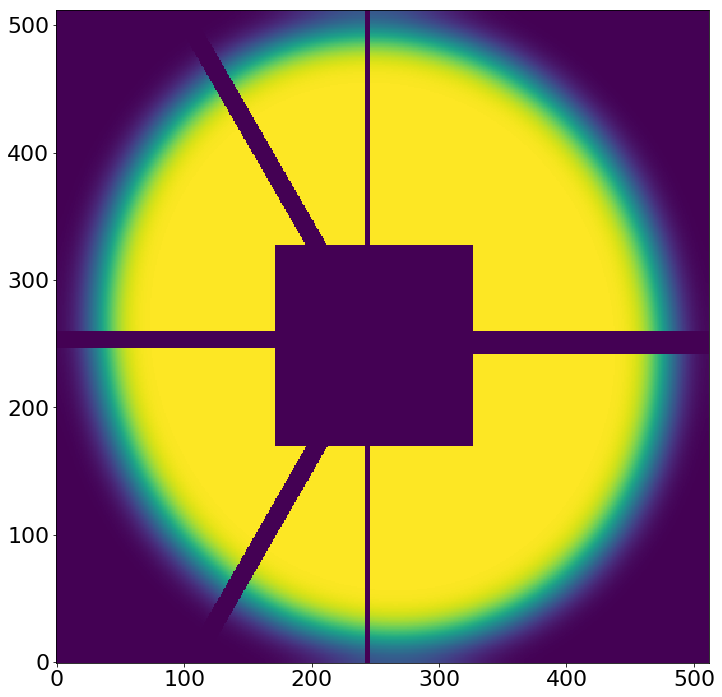

In [239]:
plt.figure(figsize=(12,12))
plt.imshow(pupililluminated,origin='lower')

chi**2 reduced is: 32.9932945137
Abs of residual divided by total flux is: 0.149244064124
Abs of residual divided by largest value of a flux in the image is: 0.13321546903


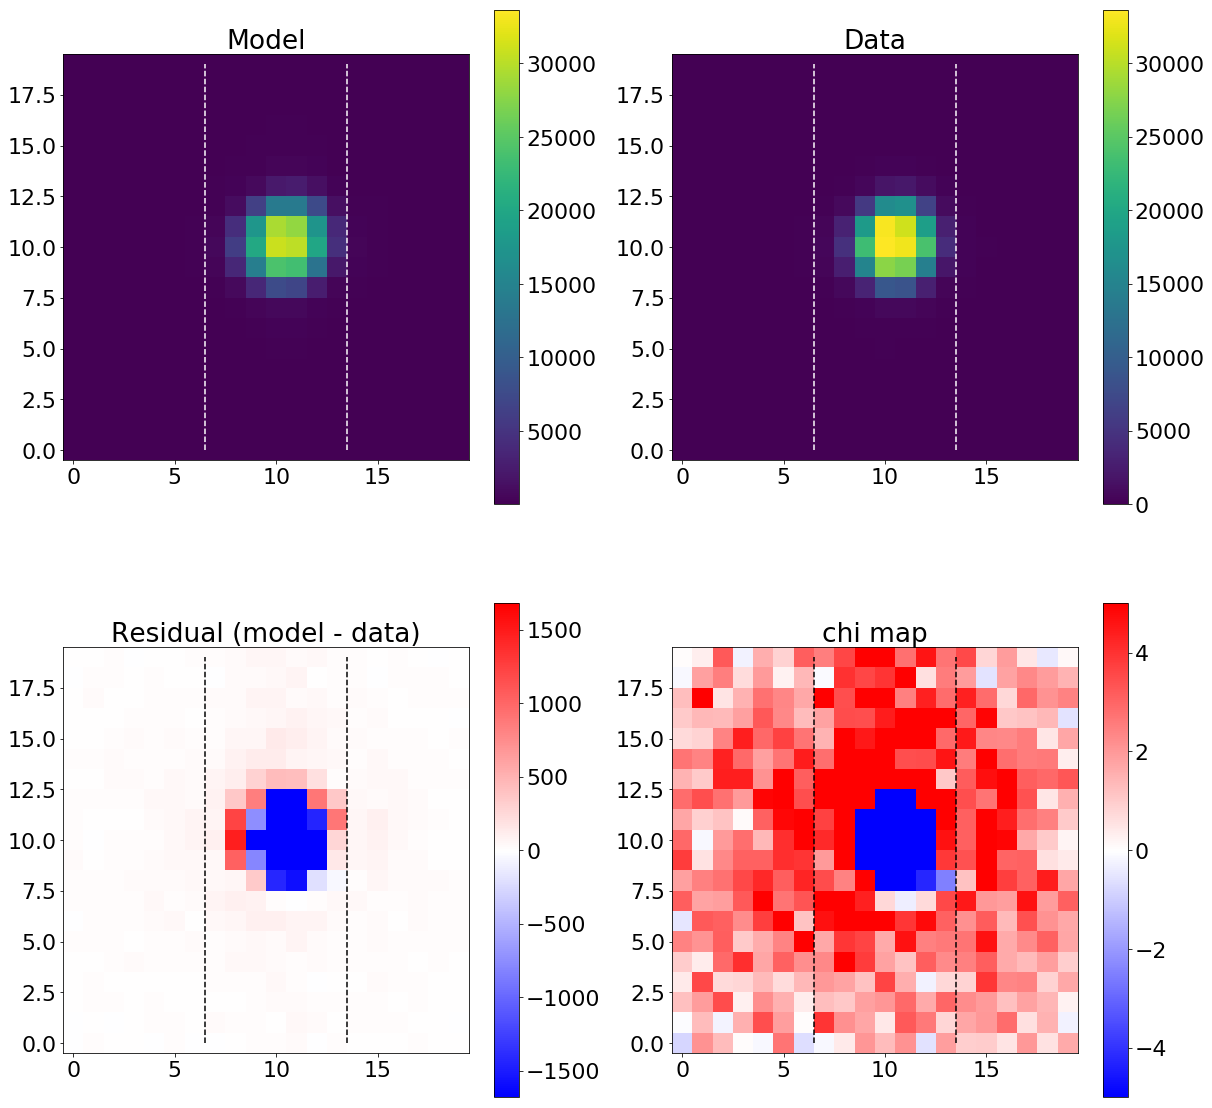

In [240]:
single_analysis.create_basic_comparison_plot()

32.9932945137
chi**2 reduced is: 32.9932945137
Abs of residual divided by total flux is: 0.149244064124
Abs of residual divided by largest value of a flux in the image is: 0.13321546903


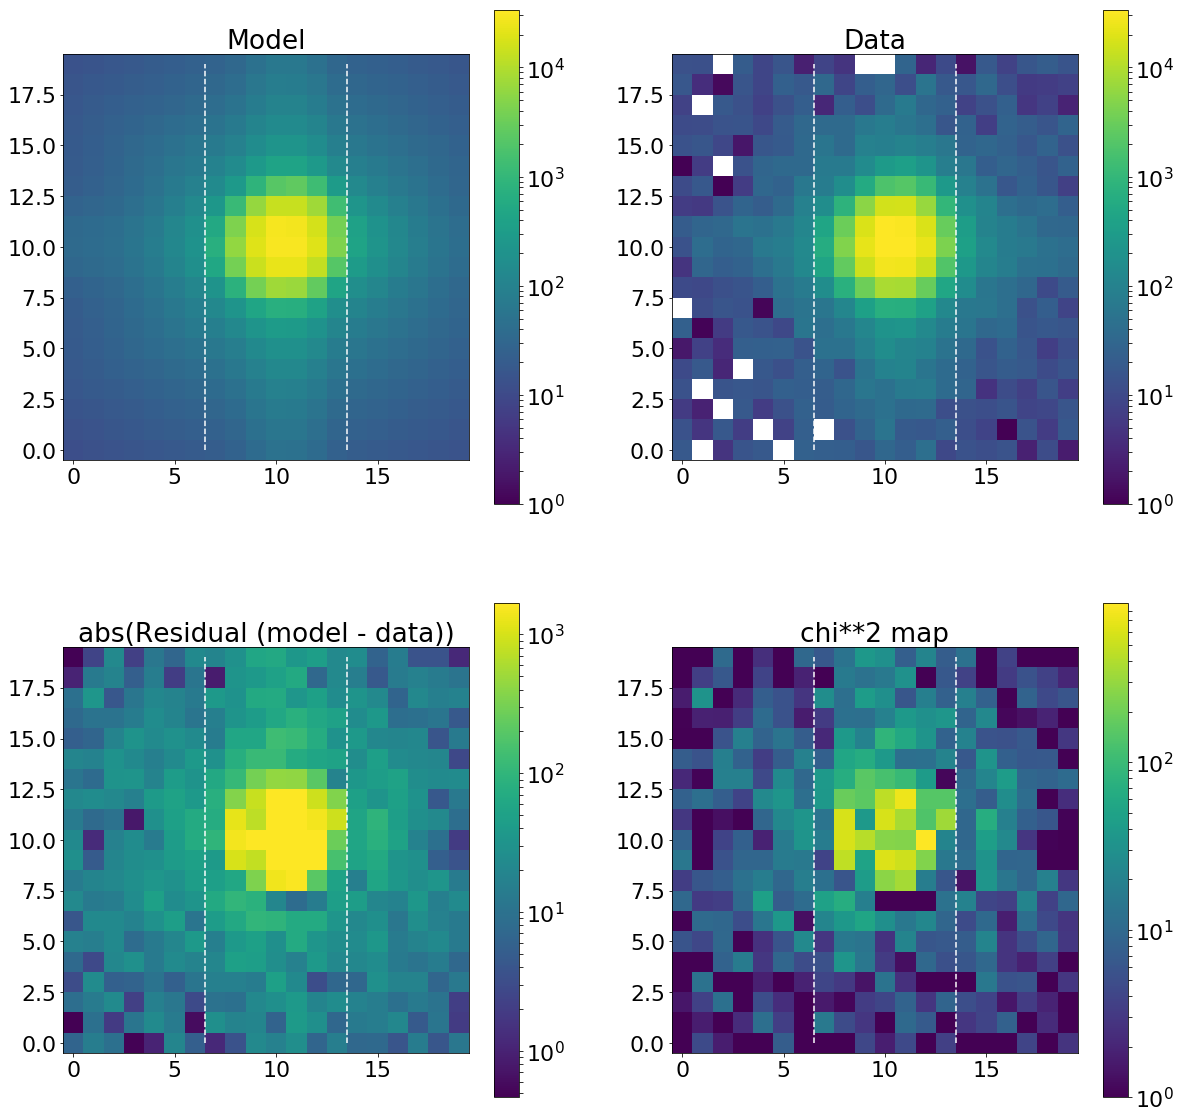

In [241]:
single_analysis.create_basic_comparison_plot_log()

In [242]:
artifical_noise=single_analysis.create_artificial_noise()

32.9932945137


0.14924406412403743

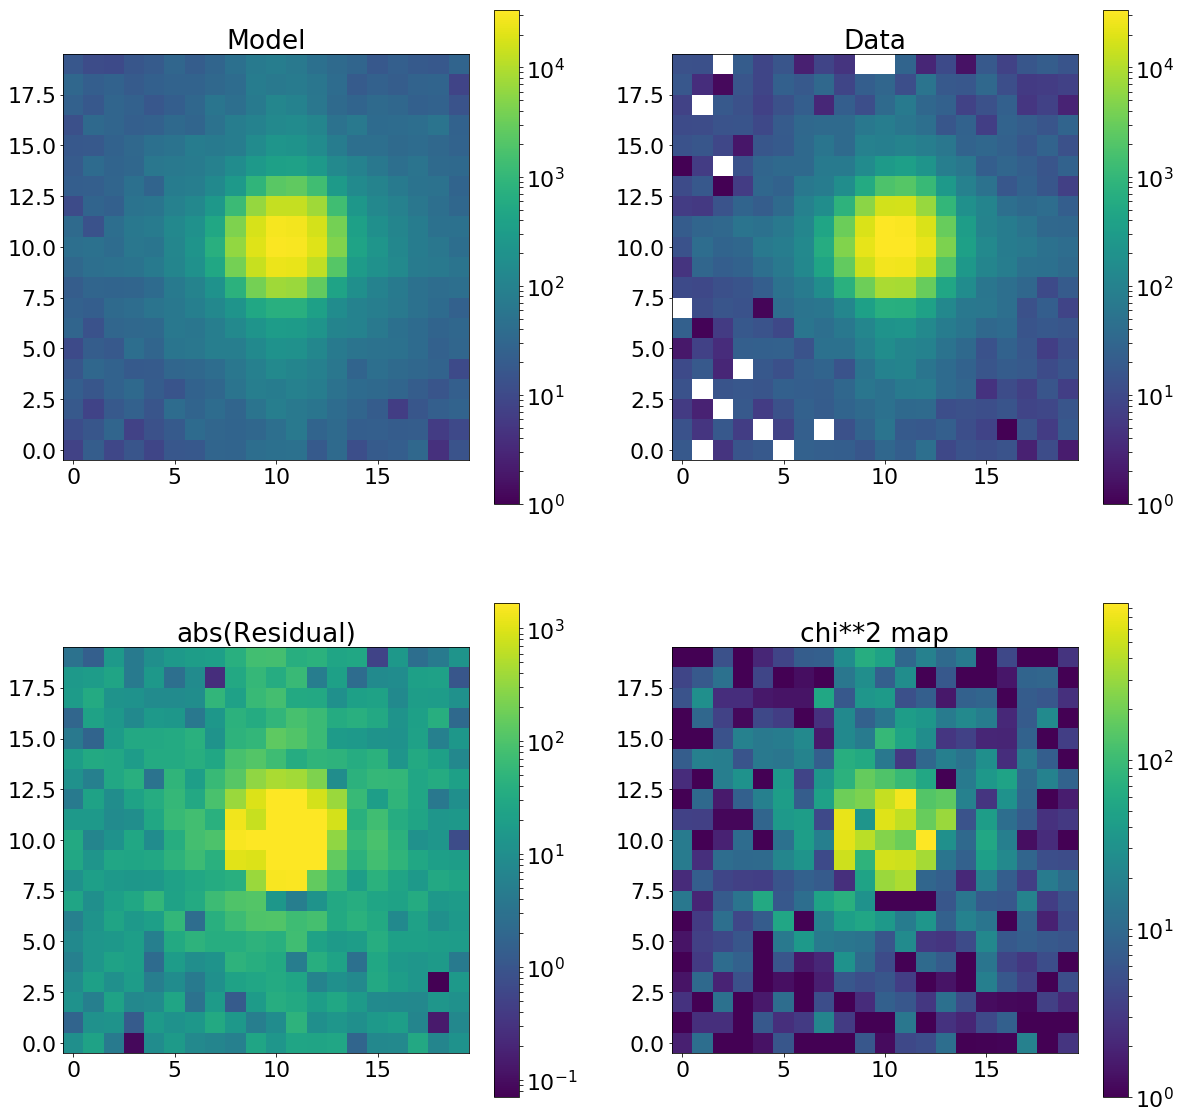

In [243]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

84.3164561243
224.347729258


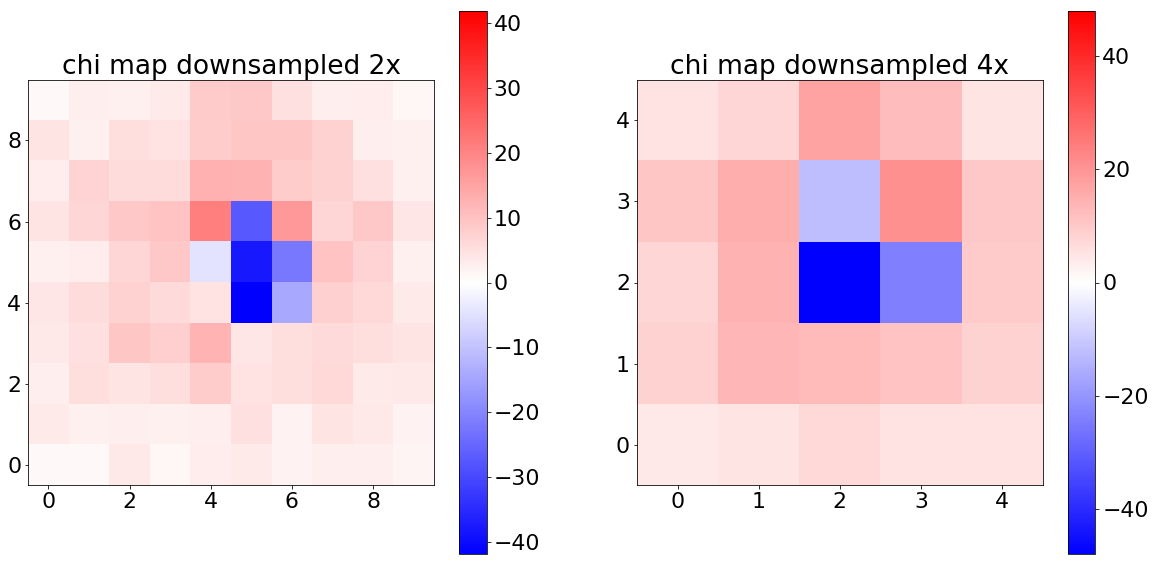

In [244]:
sci_image_2=downsample_manual_function(sci_image,int(sci_image.shape[0]/2))
sci_image_4=downsample_manual_function(sci_image,int(sci_image.shape[0]/4))

res_iapetus_2=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/2))
res_iapetus_4=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/4))

var_image_2=downsample_manual_function(var_image,int(var_image.shape[0]/2))
var_image_4=downsample_manual_function(var_image,int(var_image.shape[0]/4))

chi_downsample_2=(res_iapetus_2-sci_image_2)/np.sqrt(var_image_2)
chi_downsample_4=(res_iapetus_4-sci_image_4)/np.sqrt(var_image_4)

print(np.mean(chi_downsample_2**2))
print(np.mean(chi_downsample_4**2))


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(chi_downsample_2,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_2)),vmax=np.max(np.abs(chi_downsample_2)))
plt.colorbar()
plt.title('chi map downsampled 2x')
plt.subplot(122)
plt.imshow(chi_downsample_4,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_4)),vmax=np.max(np.abs(chi_downsample_4)))
plt.colorbar()
plt.title('chi map downsampled 4x')

In [ ]:
single_analysis.create_cut_plots()

# Illumination of both sides of focus

In [2337]:
single_number=55
obs=8627
sci_image_8627=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
var_image_8627=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

obs=8552
sci_image_8552=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
var_image_8552=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

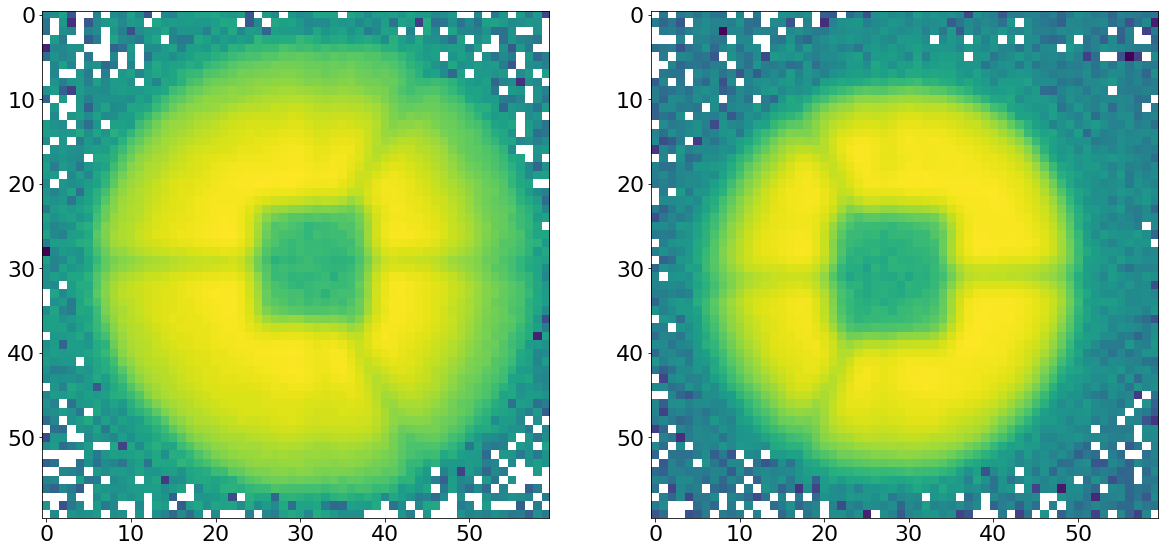

In [2338]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(sci_image_8627,norm=LogNorm())
plt.subplot(122)
plt.imshow(sci_image_8552,norm=LogNorm())

In [2331]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent', 'x_ilum','y_ilum',
         'minorAxis','pupilAngle','effective_ilum_radiusInit','frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux'] 
par

allparameters_proposal=np.array([-28 ,     0.0  ,    0.0  ,  0, 0  ,  0    , 0  , 0,
                                 0.8,0.1,0.0,0.3,0.08,0.4,
                                 0.4,2,-0.2,0.00,
                                 0.99,0.0,0.95,0.01,1,0,
                                 50000,50,2.5,0.1,
                                 0.47,1.85,1.0   ])

model = LN_PFS_single(sci_image_8627,var_image_8627,dithering=1,save=1)
model(allparameters_proposal)

pupililluminated_8627=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
optPsf_cut_fiber_convolved_downsampled_8627=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

allparameters_proposal[0]=28

model = LN_PFS_single(sci_image_8552,var_image_8552,dithering=1,save=1)
model(allparameters_proposal)

pupililluminated_8552=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
optPsf_cut_fiber_convolved_downsampled_8552=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

In [2332]:
par

array([    24.  ,     -0.  ,      0.  ,      0.  ,      0.  ,     -0.  ,
            0.  ,      0.  ,      0.8 ,      0.1 ,      0.  ,      0.3 ,
            0.08,      0.4 ,      0.7 ,      2.  ,     -0.2 ,      0.  ,
            0.99,      0.  ,      0.95,      0.01,      1.  ,      0.  ,
        50000.  ,     50.  ,      2.5 ,      0.1 ,      0.47,      1.85,
            1.  ])

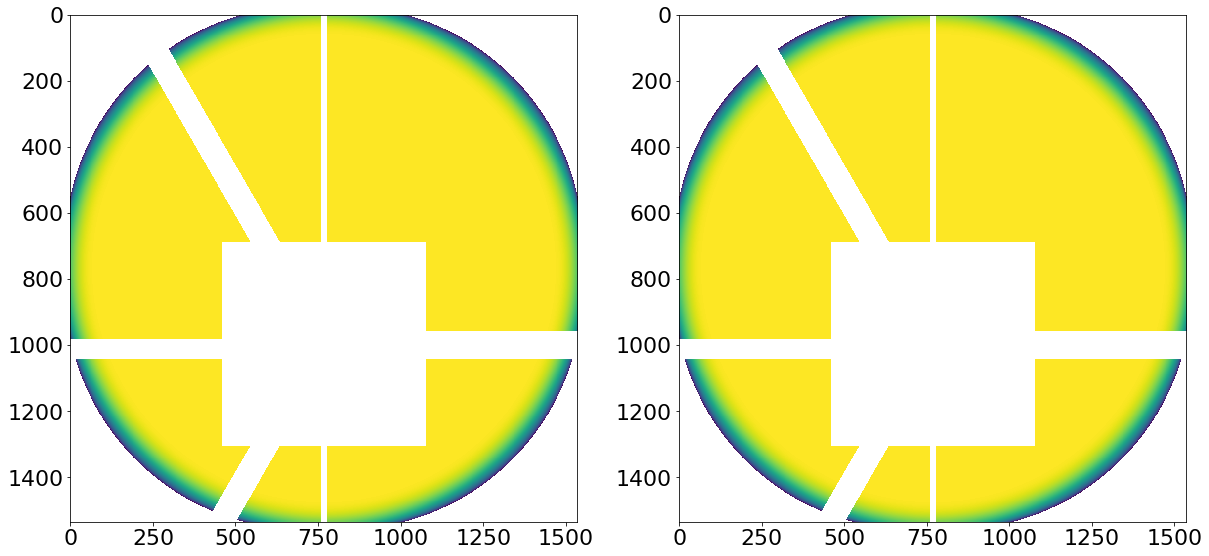

In [2325]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated_8627,norm=LogNorm())
plt.subplot(122)
plt.imshow(pupililluminated_8552,norm=LogNorm())

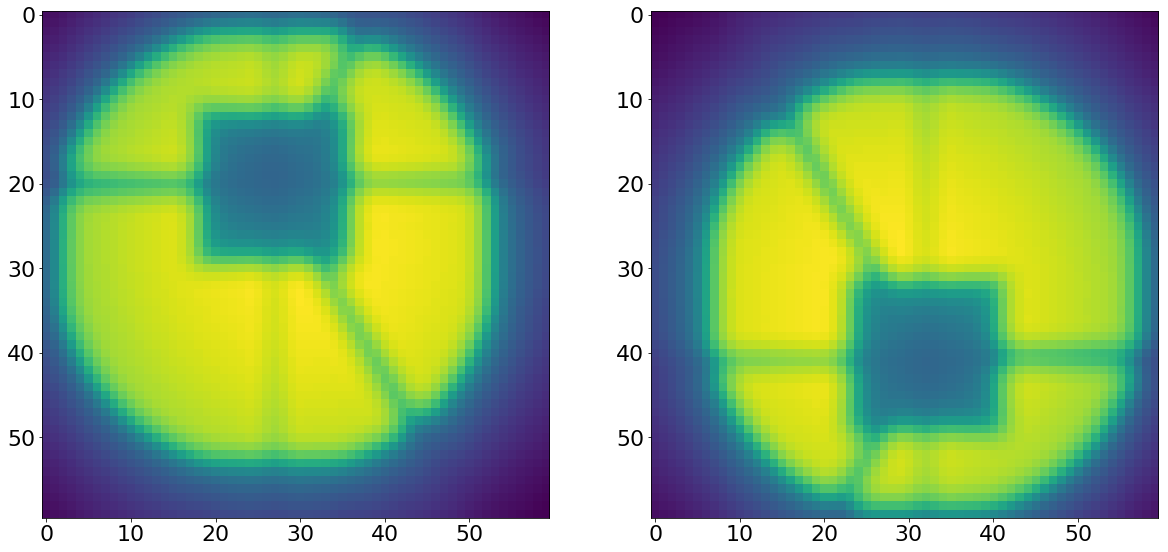

In [2326]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved_downsampled_8627,norm=LogNorm())
plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved_downsampled_8552,norm=LogNorm())

In [2327]:
obs=8603
sci_image_8603=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
var_image_8603=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

In [2306]:

allparameters_proposal[0]=0

model = LN_PFS_single(sci_image_8603,var_image_8603,dithering=1,save=1)
model(allparameters_proposal)

pupililluminated_8603=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
optPsf_cut_fiber_convolved_downsampled_8603=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

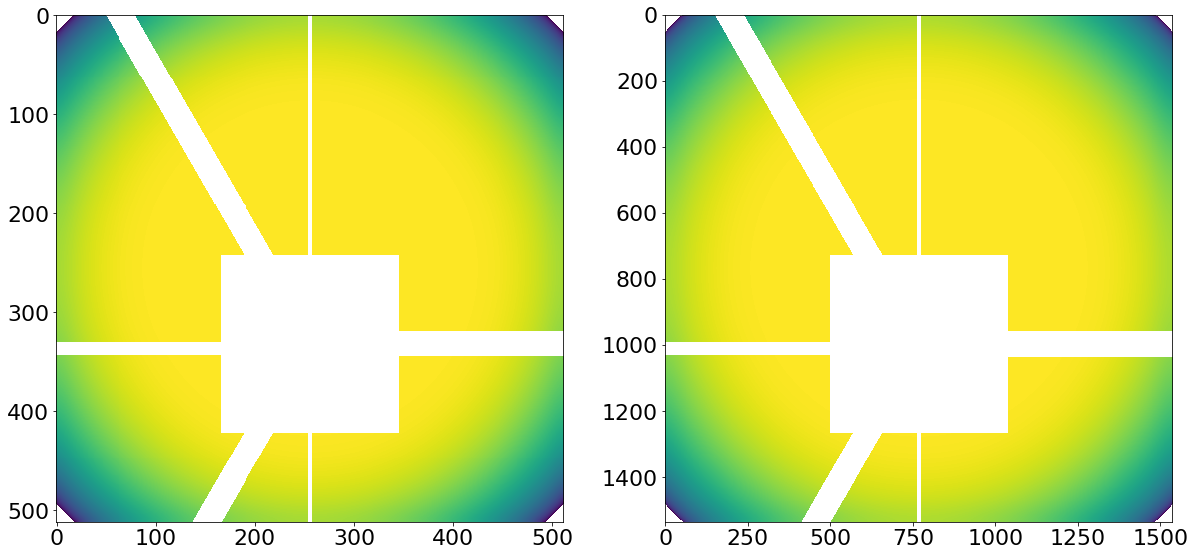

In [2307]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated_8603,norm=LogNorm())
plt.subplot(122)
plt.imshow(pupililluminated_8627,norm=LogNorm())

# Cosmohammer

In [2612]:
import cosmoHammer
from Zernike_Module import PFSLikelihoodModule

In [2613]:
#specify number of observation which you want to analyze
obs='8603'
#specify single number which specifies which spot you want to anallyze - values are from 0 to 100, '55' is in the center of the detector 
image_index=57
single_number=str(image_index)
#load scientific and variance image
#sci_image =np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
#var_image =np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')


if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')


#obs_int=int(obs)
#obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
#z4Input_possibilites=np.array([28,24.5,21,17.5,14,10.5,7,3.5,0,0,-3.5,-7,-10.5,-14,-17.5,-21,-24.5,-28])
#z4Input=z4Input_possibilites[obs_possibilites==obs_int][0]

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent', 'x_ilum','y_ilum',
         'minorAxis','pupilAngle','effective_ilum_radiusInit','frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux'] 
"""
@param z4                     defocus parameter - if you give the observations number it will automaticly adjust but you can also pass the value manually below
@param z5-z11                 Zernike coefficents, following Noel convention

# pupil parameters
@param hscFracInit               Value determined how much of the exit pupil obscured by the central obscuration(detector) 
@param strutFracInit             Value determining how much of the exit pupil is obscured by a single strut
@param focalPlanePositionInit    2-tuple for position of the central obscuration(detector) in the focal plane
@param slitFracInit              Value determining how much of the exit pupil is obscured by slit
@param slitFrac_dy_Init          Value determining what is the vertical position of the slit in the exit pupil

#non-uniform illumination
@param radiometricEffectInit     parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param radiometricExponentInit   parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param x_ilumInit                x-position of the center of illumination of the exit pupil
@param y_ilumInit                y-position of the center of illumination of the exit pupil

# further pupil parameters
@param minorAxisInit             which fraction of major axis is the minor axis the ellipsoid describing the illumination of the exit pupil
@param pupilAngleInit            angle of the ellipsoid describing the illumination of the exit pupil
@param effective_ilum_radiusInit fraction of the maximal radius of the illumination of the exit pupil   
@param frd_sigma                 sigma of Gaussian convolving only outer edge, mimicking FRD
@param det_vert                  multiplicative factor determining vertical size of the detector obscuration
@param slitHolder_frac_dx        dx position of slit holder

# convolving parameters
@param grating_lines             number of effective lines in the grating
@param scattering_radiusInit     minimal radius to which extended the scattering [in units of microns] 
@param scattering_slopeInit      slope of scattering
@param scattering_amplitudeInit  amplitude of scattering compared to optical PSF
@param pixel_effectInit          sigma describing charge diffusion effect [in units of 15 microns]
@param fiber_rInit               radius of perfect tophat fiber, as seen on the detector [in units of 15 microns]         
@param fluxInit                  total flux in generated image compared to input image (probably 1 or close to 1)
"""

allparameters_proposal=np.array( [    0.      ,       0.    ,         0.      ,      -0.,
     0.        ,     0.       ,      0.     ,        0.,
     0.65    ,       0.1     ,       0. ,            0.,
     0.08   ,        0. ,            0.7  ,          2.,
    -0.2   ,         0.  ,           0.99 ,          0.,
     1.  ,           0.02,           1.  ,           0.,
 50000.   ,         20. ,            2.5 ,           0.06309573,
     0.47  ,         1.85 ,          1.        ])

if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)  
    #model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,pupil_parameters=[0.65,0.1,0.,0.,0.08,0,0.99,0.0,1,0.04,1,0])   

modelP =LNP_PFS(sci_image,var_image)

lower_limits=[z4Input-5,-2,-2,-2,-2,-2,-2,-2,
             0.5,0.05,-0.8,-0.8,0,-0.5,
             0,-0.5,-0.8,-0.8,
             0.8,-np.pi/2,0.5,0,0.85,-0.8,
             1200,1,0.5,0,
             0.2,1.4,0.9]

higher_limits=[z4Input+5,2,2,2,2,2,2,2,
              1.2,0.2,0.8,0.8,0.2,0.5,
              3,20,0.8,0.8,
              1,np.pi/2,1.01,0.05,1.15,0.8,
               120000,50,3.5,0.5,
               1.1,2.4,1.1]

print('First value of the sci image: '+str(sci_image[0][0]))
print('First value of the var image: '+str(var_image[0][0]))

model(allparameters_proposal)




First value of the sci image: 1.9746
First value of the var image: 62.1862


-4482.6168505951637

In [2614]:
model([   -0.08094654   ,  0.07797644,    -0.12826185,    -0.22875746,
    -0.04393391,     0.05025636 ,   -0.09436121 ,    0.26840973,
     0.59631709,     0.15422071 ,   -0.04194558 ,   -0.04024492,
     0.14212256,     0.02105282,     0.59475499 ,    2.27468789,
     0.27628072,     0.26736234,     0.92131167 ,    0.10835015,
     0.97312159,     0.03780033,     0.90054144 ,    0.01363562,
 73573.93858286 ,   34.88725057,     1.94659959 ,    0.04287627,
     0.48167578 ,    1.64137257,     1.01178229])

/Users/nevencaplar/Documents/PFS/lsst_stack3/python/miniconda3-4.3.21/lib/python3.6/site-packages/IPython/core/displayhook.py:271: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


-inf

In [2615]:
model([     0.06076519 ,     0.21247918 ,     0.01637834 ,    -2.57623069,
     -0.16931152,     1.42324064,     -0.44074998  ,    1.07890777,
      0.7201668  ,     0.14219044,     -0.61131209  ,    0.03730777,
      0.03190697  ,    0.2702403  ,     1.92632734   ,  18.80762456,
     -0.25188569   ,   0.45750813  ,    0.90913399    ,  0.4039864,
      0.85989062    ,  0.02836047   ,   1.0193738     , -0.71070206,
 119648.7728008      ,21.02408126    ,  2.70072392    ,  0.08496114,
      0.46606685     , 1.64053156     , 0.9966299 ])

-inf

In [2663]:
model(allparameters_proposal)*2

-8965.2337011903273

In [2616]:
chain = cosmoHammer.LikelihoodComputationChain()
chain.addLikelihoodModule(PFSLikelihoodModule(model))

In [2669]:
pso = cosmoHammer.ParticleSwarmOptimizer(chain, low=np.array(lower_limits), high=higher_limits, particleCount=10)

In [2683]:
create_parInit(allparameters_proposal)[0]

array([     0.        ,      0.        ,      0.        ,     -0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.65      ,      0.1       ,      0.        ,      0.        ,
            0.08      ,      0.        ,      0.7       ,      2.        ,
           -0.2       ,      0.        ,      0.99      ,      0.        ,
            1.        ,      0.02      ,      1.        ,      0.        ,
        50000.        ,     20.        ,      2.5       ,      0.06309573,
            0.47      ,      1.85      ,      1.        ])

In [2684]:
for i in range(len(pso.swarm)):
    pso.swarm[i].position=create_parInit(allparameters_proposal)[i]

In [2685]:
import time

init_pos=allparameters_proposal
if not init_pos is None:
    pso.gbest.position = init_pos
    pso.gbest.velocity = [0]*len(init_pos)
    pso.gbest.fitness =model(allparameters_proposal)

X2_list = []
vel_list = []
pos_list = []
swarms=[]
gBests=[]
time_start = time.time()

num_iter = 0
n_iterations=7
for swarm in pso.sample(n_iterations):
    X2_list.append(pso.gbest.fitness*2)
    vel_list.append(pso.gbest.velocity)
    pos_list.append(pso.gbest.position)
    swarms.append(pso.swarm)
    gBests.append(pso.gbest.copy())
    num_iter += 1
    if pso.isMaster():
        if num_iter % 2 == 0:
            print(num_iter)

2
4
6
max iteration reached! stoping


In [2686]:
res=[]
for i in range(len(swarms)):
    for j in range(len(swarms[0])):
        res.append(swarms[i][j].position)
        
res=np.array(res)
chains=res.reshape(len(swarms),len(swarms[0]),len(lower_limits))

#chains[0] select one time step, in this case first

In [2687]:
chains.shape

(7, 10, 31)

In [2688]:
chains[0].shape

(10, 31)

In [2689]:
chains[0,:,0]

array([-0.96496196, -0.30071513, -0.18066033, -0.0117679 , -1.43925166,
       -1.968343  , -0.49446047, -1.15810925, -0.43531807, -0.11802172])

In [2648]:
lower_limits

[-5.0,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 0.5,
 0.05,
 -0.8,
 -0.8,
 0,
 -0.5,
 0,
 -0.5,
 -0.8,
 -0.8,
 0.8,
 -1.5707963267948966,
 0.5,
 0,
 0.85,
 -0.8,
 1200,
 1,
 0.5,
 0,
 0.2,
 1.4,
 0.9]

In [2219]:
res=[]
for i in range(len(swarms)):
    for j in range(len(swarms[0])):
        res.append(swarms[i][j].position)
        
res=np.array(res)
chains=res.reshape(len(swarms),len(swarms[0]),len(lower_limits))


res=[]
for i in range(len(swarms)):
    for j in range(len(swarms[0])):
        res.append(swarms[i][j].fitness)
        
res=np.array(res)
ln_chains=res.reshape(len(swarms),len(swarms[0]))

In [2220]:
ln_chains

array([[ -48874.64656122, -200943.34806631,             -inf,
         -35981.81676268, -176751.41386049, -257769.20922081,
                    -inf,  -31038.39407418, -149167.64005985,
         -77384.08008471],
       [            -inf,             -inf,             -inf,
                    -inf,             -inf,             -inf,
                    -inf,  -31038.39407418,             -inf,
                    -inf],
       [            -inf,             -inf,             -inf,
                    -inf,             -inf,             -inf,
                    -inf,  -31038.39407418,             -inf,
                    -inf],
       [            -inf,             -inf,             -inf,
                    -inf,             -inf,             -inf,
                    -inf,  -31038.39407418,             -inf,
                    -inf],
       [            -inf,             -inf,             -inf,
                    -inf,             -inf,             -inf,
                    -inf

In [2214]:
swarms[4][5].position

array([     0.61106683,      0.05677982,     -0.06093366,      0.40425077,
            0.86587223,     -0.97865839,      3.54664661,      0.29825418,
            0.50517252,      0.13258345,     -0.01823568,     -0.60589766,
            0.04821252,     -0.31744088,      2.14875126,     16.15781247,
           -0.2469399 ,     -0.12778491,      0.90577311,      0.99355226,
            0.9964121 ,      0.02718781,      1.05916556,     -0.19577565,
        94821.40218204,     72.93716411,      0.1867948 ,      0.20148872,
            0.27928616,      1.51531445,      1.1546838 ])

In [2064]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   


In [2139]:
columns_single=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent', 'x_ilum','y_ilum',
         'minorAxis','pupilAngle','effective_ilum_radiusInit','frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux'] 


model(np.array( [     0.06076519  ,    0.21247918    ,  0.01637834  ,   -2.57623069,
     -0.16931152   ,   1.42324064   ,  -0.44074998  ,    1.07890777,
      0.7201668 ,      0.14219044  ,   -0.61131209  ,    0.03730777,
      0.03190697   ,   0.2702403  ,     1.92632734 ,    18.80762456,
     -0.25188569  ,    0.45750813 ,     0.90913399,      0.4039864,
      0.85989062 ,     0.02836047 ,     1.0193738 ,     -0.71070206,
 119648.7728008   ,   21.02408126 ,     2.70072392 ,     0.08496114,
      0.46606685  ,    1.64053156 ,     0.9966299 ]))

-2851.5053191177726

In [2140]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

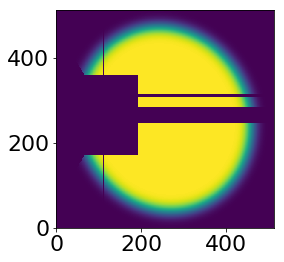

In [2141]:
plt.imshow(pupililluminated,origin='lower')

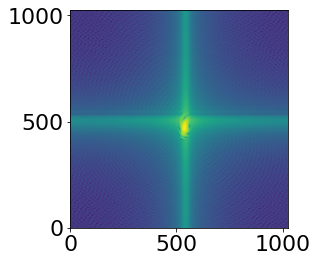

In [2142]:
plt.imshow(optPsf,origin='lower',norm=LogNorm())

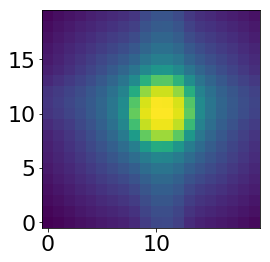

In [2148]:
plt.imshow(res_iapetus,origin='lower',norm=LogNorm())

In [2161]:
create_parInit(allparameters_proposal)[0]==allparameters_proposal

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [2224]:
minchain=np.array( [   -0.43468713 ,   -0.33432176,     0.00963056 ,   -0.58516572,
    -0.26514859,    -0.3496762,      0.34935486,    -0.78202402,
     0.83340101 ,    0.0911056 ,     0.70091886 ,   -0.14337799,
     0.13996205  ,   0.14638301 ,    2.16442786  ,   6.58298018,
     0.09269189   ,  0.33578258  ,   0.96277711   , -0.18746378,
     0.71207885    , 0.00037813   ,  0.95654288    , 0.65174145,
 81452.19663341     ,3.25125681    , 2.70986183     ,0.3877879,
     0.50425585     ,1.65562126     ,0.99638557])

In [2235]:
minchain= [   -0.43468713 ,   -0.33432176,     0.00963056 ,   -0.58516572,
    -0.26514859,    -0.3496762,      0.34935486,    -0.78202402,
     0.83340101 ,    0.0911056 ,     0.70091886 ,   -0.14337799,
     0.13996205  ,   0.14638301 ,    2.16442786  ,   6.58298018,
     0.09269189   ,  0.33578258  ,   0.96277711   , -0.18746378,
     0.71207885    , 0.00037813   ,  0.95654288    , 0.65174145,
 81452.19663341     ,3.25125681    , 2.70986183     ,0.3877879,
     0.50425585     ,1.65562126     ,0.99638557]

In [2236]:
minchain_err=np.array( [    1.60834094  ,   0.4284592 ,     0.40846479  ,   0.42783618,
     0.40595465   ,  0.45931248 ,    0.3896283  ,    0.44624545,
     0.17735111  ,   0.06395393  ,   0.11926922  ,   0.17359842,
     0.06997754 ,    0.1481776  ,    0.33935192 ,    0.71659284,
     0.12555674 ,    0.16648449 ,    0.08695385 ,    0.32741584,
     0.17233057 ,    0.01880397,     0.18530938 ,    0.13582877,
 41363.74650176,    22.7274713 ,     0.67390752 ,    0.16317434,
     0.23327529 ,    0.24360564   ,  0.04304658])

In [2237]:
lower_limits_inter=minchain-minchain_err
higher_limits_inter=minchain+minchain_err

In [2238]:
higher_limits_inter

array([      1.17365381,       0.09413744,       0.41809535,
            -0.15732954,       0.14080606,       0.10963628,
             0.73898316,      -0.33577857,       1.01075212,
             0.15505953,       0.82018808,       0.03022043,
             0.20993959,       0.29456061,       2.50377978,
             7.29957302,       0.21824863,       0.50226707,
             1.04973096,       0.13995206,       0.88440942,
             0.0191821 ,       1.14185226,       0.78757022,
        122815.94313517,      25.97872811,       3.38376935,
             0.55096224,       0.73753114,       1.8992269 ,
             1.03943215])

In [2239]:
higher_limits_2=np.minimum(higher_limits,higher_limits_inter)
higher_limits_2

array([      1.17365381,       0.09413744,       0.41809535,
            -0.15732954,       0.14080606,       0.10963628,
             0.73898316,      -0.33577857,       1.01075212,
             0.15505953,       0.8       ,       0.03022043,
             0.2       ,       0.29456061,       2.50377978,
             7.29957302,       0.21824863,       0.50226707,
             1.        ,       0.13995206,       0.88440942,
             0.0191821 ,       1.14185226,       0.78757022,
        120000.        ,      25.97872811,       3.38376935,
             0.5       ,       0.73753114,       1.8992269 ,
             1.03943215])

# Creating fake image for testing

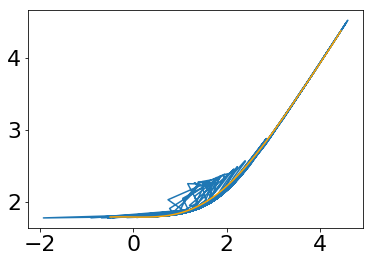

In [2690]:
from scipy.optimize import curve_fit

def var_fit_1D(x, a, b,c,d,e,f,g):
    return a*x**6+b*x**5+c*x**4+d*x**3+e*x**2+ f*x + g

popt, pcov = curve_fit(var_fit_1D, np.log10(sci_image.flatten()[sci_image.flatten()>0]), np.log10(var_image.flatten()[sci_image.flatten()>0]))

res=[]
for x in np.arange(-0.5,4.5,5/100):
    res.append(var_fit_1D(x,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6]))
    
res=np.array(res)

plt.plot(np.log10(sci_image.flatten()[sci_image.flatten()>0]),np.log10(var_image.flatten()[sci_image.flatten()>0]))
plt.plot(np.arange(-0.5,4.5,5/100),res,'orange')



In [2691]:
columns_single=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent', 'x_ilum','y_ilum',
         'minorAxis','pupilAngle','effective_ilum_radiusInit','frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux'] 

In [2708]:
allparameters_proposal=np.array([-7,0.00,0.50,-0.0,0.0,0.2,0.00,0.0,0,0.45,0.00,-0.0,0.0,0.0,0.05,0.0,
                                 0.8,0.1,0.0,0.3,0.08,0.2,
                                 0.7,2,-0.2,0.00,
                                 0.99,0.0,0.9,0.015,1.0,0.0,
                                 50000,50,2.5,0.05,
                                 0.47,1.85,1.0]) 

par=create_x(defocus_possibilites[0],allparameters_proposal)
par

array([    28.   ,     -2.   ,      0.2  ,      0.   ,      0.45 ,
           -0.   ,      0.   ,     -0.2  ,      0.8  ,      0.1  ,
            0.   ,      0.3  ,      0.08 ,      0.2  ,      0.7  ,
            2.   ,     -0.2  ,      0.   ,      0.99 ,      0.   ,
            0.9  ,      0.015,      1.   ,      0.   ,  50000.   ,
           50.   ,      2.5  ,      0.05 ,      0.47 ,      1.85 ,      1.   ])

In [2709]:
obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
z4Input_possibilites=np.array([28,24.5,21,17.5,14,10.5,7,3.5,0,0,-3.5,-7,-10.5,-14,-17.5,-21,-24.5,-28])
defocus_possibilites=np.array([-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0,0.5,1,1.5,2,2.5,3,3.5,4])

image_index=55

for i in range(len(obs_possibilites)):
    par=create_x(defocus_possibilites[i],allparameters_proposal)
    
    obs=str(obs_possibilites[i])
    print(obs)
    if obs=='8600':
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
    else:    
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')
    
    
    if obs=='8600':
        model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
    else:
        model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)  
        
    model(par) 
        
    optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
    res_iapetus=optPsf_cut_fiber_convolved_downsampled
        
    var_res_iapetus=10**var_fit_1D(np.log10(np.abs(res_iapetus)),popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6])
    fake_data=res_iapetus+np.random.standard_normal(res_iapetus.shape[0]*res_iapetus.shape[1]).reshape(res_iapetus.shape[0],res_iapetus.shape[1])*np.sqrt(var_res_iapetus)
    var_fake_data=10**var_fit_1D(np.log10(np.abs(fake_data)),popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6])   
    

    if obs=='8600':
        np.save('/Users/nevencaplar/Documents/PFS/TigerAnalysis/FakeData/Sep19/sci'+str(obs)+str(999)+'Stacked_Cleaned_Dithered.npy',fake_data)
        np.save('/Users/nevencaplar/Documents/PFS/TigerAnalysis/FakeData/Sep19/var'+str(obs)+str(999)+'Stacked_Dithered.npy',var_fake_data)   
    else:
        np.save('/Users/nevencaplar/Documents/PFS/TigerAnalysis/FakeData/Sep19/sci'+str(obs)+str(999)+'Stacked_Cleaned.npy',fake_data)
        np.save('/Users/nevencaplar/Documents/PFS/TigerAnalysis/FakeData/Sep19/var'+str(obs)+str(999)+'Stacked.npy',var_fake_data)   
    # this is to check what is the chi**2
    print('obs: '+str(np.mean((res_iapetus-fake_data)**2/var_fake_data)))

8552
obs: 1.01378233457
8555
obs: 0.981862140187
8558
obs: 1.02920700098
8561
obs: 1.0292521323
8564
obs: 1.08381216125
8567
obs: 0.961361420685
8570
obs: 0.841034359434
8573
obs: 0.919625763585
8603
obs: 0.959182046741
8600
obs: 1.01487367705
8606
obs: 1.09385954052
8609
obs: 0.906548836547
8612
obs: 0.988641635049
8615
obs: 1.02922654653
8618
obs: 0.993376616809
8621
obs: 0.92894976267
8624
obs: 0.951967426238
8627
obs: 0.985275770204


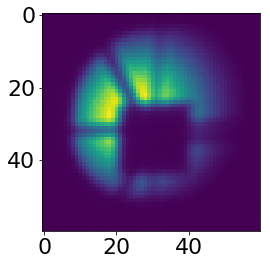

In [2710]:
fake8552=plt.imshow(np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/FakeData/Sep19/sci8552999Stacked_Cleaned.npy'))

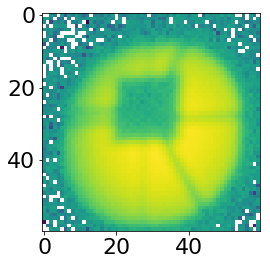

In [2711]:
fake8627=plt.imshow(np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/FakeData/Sep19/sci8627999Stacked_Cleaned.npy'),norm=LogNorm())

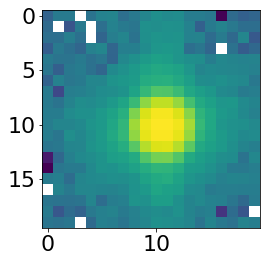

In [2712]:
plt.imshow(np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/FakeData/Sep19/sci8603999Stacked_Cleaned.npy'),norm=LogNorm())

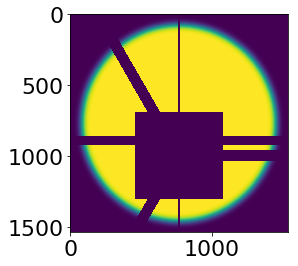

In [2713]:
pupililluminated_8552=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
plt.imshow(pupililluminated_8552)

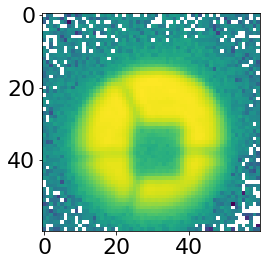

In [2714]:
sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(8552)+str(57)+'Stacked_Cleaned.npy')
plt.imshow(sci_image,norm=LogNorm())

## checkign that model actually gives chi2=1 for correct parameters

In [2759]:
    obs=8627
    image_index=999
    
    if obs=='8600':
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/FakeData/Sep19/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/FakeData/Sep19/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
    else:    
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/FakeData/Sep19/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/FakeData/Sep19/var"+str(obs)+str(image_index)+'Stacked.npy')
    
    
    if obs=='8600':
        model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
    else:
        model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)  
        
    

In [2750]:
allparameters_proposal=np.array([-7,0.00,0.50,-0.0,0.0,0.2,0.00,0.0,0,0.45,0.00,-0.0,0.0,0.0,0.05,0.0,
                                 0.8,0.1,0.0,0.3,0.08,0.2,
                                 0.7,2,-0.2,0.00,
                                 0.99,0.0,0.9,0.015,1.0,0.0,
                                 50000,50,2.5,0.05,
                                 0.47,1.85,1.0]) 

par=create_x(defocus_possibilites[-1],allparameters_proposal)
par

array([   -28.   ,      2.   ,      0.2  ,      0.   ,      0.45 ,
            0.   ,      0.   ,      0.2  ,      0.8  ,      0.1  ,
            0.   ,      0.3  ,      0.08 ,      0.2  ,      0.7  ,
            2.   ,     -0.2  ,      0.   ,      0.99 ,      0.   ,
            0.9  ,      0.015,      1.   ,      0.   ,  50000.   ,
           50.   ,      2.5  ,      0.05 ,      0.47 ,      1.85 ,      1.   ])

In [2751]:
columns_single=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent', 'x_ilum','y_ilum',
         'minorAxis','pupilAngle','effective_ilum_radiusInit','frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux'] 



par_custom=[   23.3943495  ,   -1.33986921  ,  -0.58854799  ,  -0.20528608,   0.69405023,    -0.02384153 ,    0.00211502 ,    0.29131787,
     0.67168509,     0.0850233  ,    0.03237931,     0.21909508,    0.06513327 ,    0.14621363 ,  
            0.353475  ,    14.00037492,    -0.14036416 ,    0.00202469 ,
            0.93104316 ,    0.94457292,     0.66508725 ,    0.00747344,     0.95398429 ,    0.05138985,
 40894.19351292 ,   13.16029025,     2.81159642 ,    0.09395866,
     0.61640475 ,    1.81758906 ,    0.99548012]

In [2752]:
model(par) 

-1782.0879635843949

In [2753]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

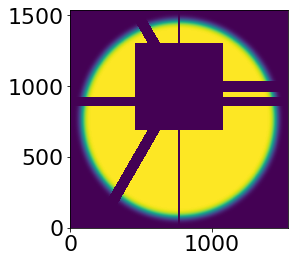

In [2754]:
plt.imshow(pupililluminated,origin='lower')

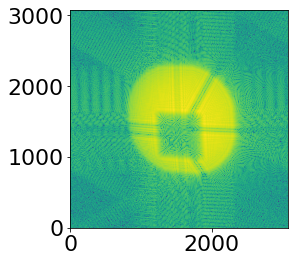

In [2755]:
plt.imshow(optPsf,origin='lower',norm=LogNorm())

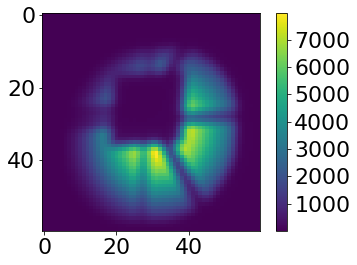

In [2756]:
plt.imshow(res_iapetus)
plt.colorbar()

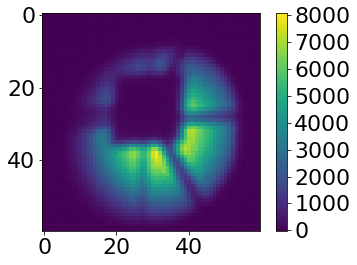

In [2757]:
plt.imshow(sci_image)
plt.colorbar()

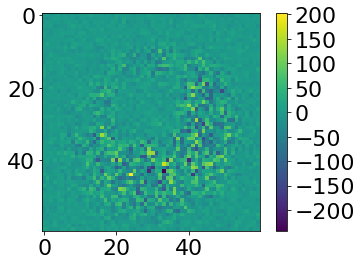

In [2758]:
plt.imshow(res_iapetus-sci_image)
plt.colorbar()

In [2564]:
# which one is the brightest
obs=8600
res=[]
for image_index in [50,51,52,53,54,55,55,57,58,59]:
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    res.append([image_index,np.sum(sci_image)])
    
res=np.array(res)

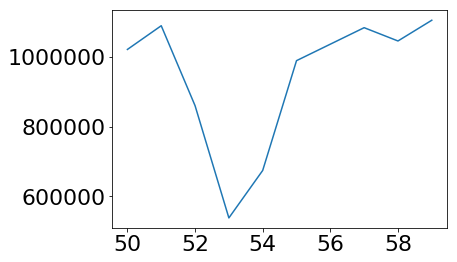

In [2565]:
plt.plot(res[:,0],res[:,1])

In [2566]:
res

array([[      50.        ,  1021269.48546416],
       [      51.        ,  1089340.03189889],
       [      52.        ,   859867.35025921],
       [      53.        ,   537588.82996151],
       [      54.        ,   673852.38080308],
       [      55.        ,   989056.95663559],
       [      55.        ,   989056.95663559],
       [      57.        ,  1083740.70074195],
       [      58.        ,  1045585.20765865],
       [      59.        ,  1105099.04549655]])

In [2569]:
# which one is the brightest
obs=8600
res=[]
for image_index in [1,11,21,31,41,51,61,71,81,91]:
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    res.append([image_index,np.sum(sci_image)])
    
res=np.array(res)

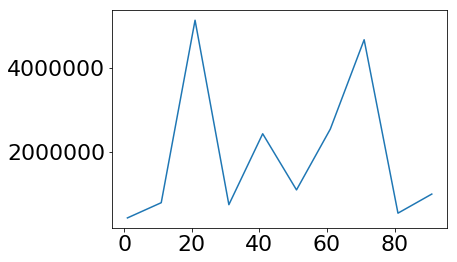

In [2570]:
plt.plot(res[:,0],res[:,1])

In [2783]:
pupil_parameters=None

allparameters_proposal=np.array([0,0.00,0.00,-0.0,0.0,0.0,0.00,0.0,
                                 0.8,0.1,0.0,0.0,0.08,0.0,
                                 0.7,2,-0.2,0.00,
                                 0.99,0.0,1,
                                 0.02,1,0,
                                 50000,20,2.5,10**-1.2,
                                 0.47,1.85,1.0])

parInit1=create_parInit(allparameters_proposal,None,pupil_parameters)



0.8
0.1
[ 0.77759163  0.78759723  0.79948899 ...,  0.85426268  0.6944104
  0.92116442]
[ 0.8         0.77759163  0.78759723  0.79948899  0.75720676  0.71269474
  0.76306068  0.80959015  0.89508627  0.85216149  0.89320807  0.85523874
  0.69538978  0.87249696  0.87541125  1.07529247  0.78962952  0.8314388
  0.751561    0.8573215   0.73761054  0.84628945  0.8996337   0.834907
  0.73777831  0.85135124  0.76499048  0.91461138  0.95105962  0.6957364
  0.81367899  0.77729377  0.86817828  0.89305304  0.72059226  0.99272412
  0.90894286  0.74217497  0.77262389  0.86293498  0.79991861  0.66491344
  0.94893856  0.88231335  0.81481945  0.74491474  0.68743534  0.72506144
  0.80235555  0.93800285  0.6570873   0.81640724  0.81466209  0.7929915
  0.92240872  0.85651662  0.8372298   0.80678857  0.71784408  0.7671229
  0.89515283  0.65173503  0.86813449  0.84161184  0.92520137  0.79978391
  0.82285492  0.88761664  0.72786319  0.87461094  0.77658973  0.91898076
  0.6893828   0.85356119  0.79750933  0.801

In [ ]:
columns_single=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent', 'x_ilum','y_ilum',
         'minorAxis','pupilAngle','effective_ilum_radiusInit','frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux'] 

In [ ]:
globalparameters_flatten_err=0.1

In [2772]:
        globalparameters_flat_22=np.random.normal(1,0.01,100*20)
        globalparameters_flat_22=np.concatenate(([1],
                                                 globalparameters_flat_22[np.all((globalparameters_flat_22>0.95,globalparameters_flat_22<1.05),axis=0)][0:100-1]))


In [2781]:
allparameters_proposal

array([    -7.   ,      0.   ,      0.5  ,     -0.   ,      0.   ,
            0.2  ,      0.   ,      0.   ,      0.   ,      0.45 ,
            0.   ,     -0.   ,      0.   ,      0.   ,      0.05 ,
            0.   ,      0.8  ,      0.1  ,      0.   ,      0.3  ,
            0.08 ,      0.2  ,      0.7  ,      2.   ,     -0.2  ,
            0.   ,      0.99 ,      0.   ,      0.9  ,      0.015,
            1.   ,      0.   ,  50000.   ,     50.   ,      2.5  ,
            0.05 ,      0.47 ,      1.85 ,      1.   ])

In [2787]:

parInit1=create_parInit(allparameters_proposal,None,pupil_parameters)
while len(parInit1)<400:
    parInit1_2=create_parInit(allparameters_proposal,None,pupil_parameters)
    parInit1=np.vstack((parInit1,parInit1_2))
    
len(parInit1)

496

In [2788]:
parInit1[300]

array([    -1.77485105,      0.10266772,      0.18873357,      0.05758708,
            0.0691514 ,      0.03528612,     -0.60353262,      0.1194951 ,
            0.75464208,      0.09267405,     -0.0438882 ,     -0.01538997,
            0.02164632,      0.03710283,      0.79749908,      2.36852052,
            0.04259527,      0.04219121,      0.8379332 ,     -0.00489161,
            0.95014855,      0.00099584,      0.93845427,     -0.16151367,
        90273.05920799,     11.79290772,      2.81911488,      0.04792537,
            0.48912484,      1.94202923,      0.99351615])

In [2722]:
len(parInit1)

496